# IMPORTS #

In [ ]:
pip install supervision

In [1]:
import torch
import pandas as pd
import numpy as np
from ultralytics.utils.ops import xyxy2xywh, xywh2xyxy
from ultralytics.utils.plotting import Annotator, colors
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import shutil
import os
import random
from ultralytics import YOLO
# no longer required
#import fiftyone as fo
#import fiftyone.zoo as foz
import supervision as sv
import math
import io
import contextlib
import sys

# Getting the OpenImagesV7 dataset ready for use #

We are going to use the fiftyone lib to get the only the penguin data. \
Then we are going to need to make sure the data is compatible and in the right format for the YOLOv8 model.

## Get only the penguin data from the OpenImagesV7 dataset ##

### Using the fiftyone - this requires the MongaDB so I am going to just work with the dataset directly ###

In [ ]:
# test
# to be removed
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    max_samples=100,
    seed=51,
    shuffle=True,
)

session = fo.launch_app(dataset.view())
# fiftyone is not working working off the bat so I am going to try something else and come back to this


### working with the dataset and annotations directly ###

data is found here: https://storage.googleapis.com/openimages/web/download_v7.html \
\
The goal is to create a list with all the image ids that specify that a penguin has been detected\
The downloader.py function that is supplied by OIV7 (and is saved it the colab directory) can be called and will only download the images in that list\
We then need to check those images and adjust the relevant annotations to only include those ids and save them.\


In [9]:
# path to the parent folder of the raw data

ROOT_RAW_OI7_PATH = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'

#### Getting the data annotations in a dataframe and filtering to only penguins ####

In [97]:
# load csvs to dataframes to work with
raw_image_labels = pd.read_csv(f'{ROOT_RAW_OI7_PATH}/validation-annotations-human-imagelabels-boxable.csv')
raw_bbox_labels = pd.read_csv(f'{ROOT_RAW_OI7_PATH}/validation-annotations-bbox.csv')

In [43]:
raw_image_labels.head()

ImageID        Source  LabelName  Confidence
0  0001eeaf4aed83f9  verification   /m/0cmf2           1
1  0004886b7d043cfd  verification  /m/01g317           0
2  0004886b7d043cfd  verification  /m/04hgtk           0
3  0004886b7d043cfd  verification   /m/09j2d           0
4  0004886b7d043cfd  verification  /m/0463sg           0

In [44]:
raw_bbox_labels.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0001eeaf4aed83f9  xclick  /m/0cmf2           1  0.022673  0.964201   
1  000595fe6fee6369  xclick  /m/02wbm           1  0.000000  1.000000   
2  000595fe6fee6369  xclick  /m/02xwb           1  0.141384  0.179676   
3  000595fe6fee6369  xclick  /m/02xwb           1  0.213549  0.253314   
4  000595fe6fee6369  xclick  /m/02xwb           1  0.232695  0.288660   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.071038  0.800546           0            0          0            0   
1  0.000000  1.000000           0            0          1            0   
2  0.676275  0.731707           0            0          0            0   
3  0.299335  0.354767           1            0          0            0   
4  0.490022  0.545455           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

the penguin id (found from the oldv7-class-descriptions-boxable.csv file):\
/m/05z6w

In [6]:
# below you can also just make it image labels where LabelName is the same but the confidence score is also equal to 1
# then you dont need to do the removing the rows thing

In [98]:
# create datasets that only contain entries with images in them
penguin_image_labels = raw_image_labels[raw_image_labels['LabelName'] == '/m/05z6w']
penguin_bbox_labels = raw_bbox_labels[raw_bbox_labels['LabelName'] == '/m/05z6w']

In [93]:
penguin_image_labels.head(97)

ImageID        Source LabelName  Confidence
6084    01e8e6894bf88777  verification  /m/05z6w           1
7654    025dfa9ea18bcb18  verification  /m/05z6w           0
14090   045f2a7a01277369  verification  /m/05z6w           0
17172   0555911ee31d049f  verification  /m/05z6w           0
24612   07ca230691eec10e  verification  /m/05z6w           1
...                  ...           ...       ...         ...
482309  9ee32a851eba0eea  verification  /m/05z6w           1
492643  a25a74a471183cee  verification  /m/05z6w           1
495405  a32f24bc0220911f  verification  /m/05z6w           0
516197  a9ddfcc0e100968c  verification  /m/05z6w           1
516312  a9e4a8ab99442e99  verification  /m/05z6w           1

[97 rows x 4 columns]

In [64]:
# get number of rows (number of images)
penguin_image_labels.shape

(1356, 4)

In [95]:
penguin_bbox_labels.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
7934   01e8e6894bf88777  xclick  /m/05z6w           1  0.050186  0.899628   
30971  07ca230691eec10e  xclick  /m/05z6w           1  0.000000  0.466814   
30972  07ca230691eec10e  xclick  /m/05z6w           1  0.327434  0.761062   
30973  07ca230691eec10e  xclick  /m/05z6w           1  0.396018  0.818584   
37464  099862b891b82c9a  xclick  /m/05z6w           1  0.526549  0.621681   

           YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
7934   0.014035  0.843860           0            0          0            0   
30971  0.625369  1.000000           1            1          0            0   
30972  0.122419  0.501475           1            0          0            0   
30973  0.215339  0.971976           0            0          0            0   
37464  0.309735  0.401180           0            0          0            1   

       IsInside  
7934          0  
30971         0  
30972         0  
30973         0  
37464         0

In [65]:
# get number of rows (number of bboxs)
penguin_bbox_labels.shape

(4197, 21)

In [66]:
# First I would like to just check that all the ids appear in both lists (sanity check)
# I will remove anything that does not appear in both 
def check_id_presence_in_dfs(df1, df2, id_column, df1_name='df1', df2_name='df2'):
    """
    Check and print IDs that are not present in both dataframes and put them in a list. prints and returns nothing if all ids are present.
    """
    # Set of ids from each df
    ids_df1 = set(df1[id_column])
    ids_df2 = set(df2[id_column])

    # create lists for ids to be removefd
    df1_list_2remove = []
    df2_list_2remove = []

    # Find IDs that are only in df1
    only_in_df1 = ids_df1 - ids_df2
    if only_in_df1:
        #print(f"IDs only in {df1_name}:")
        for id_ in only_in_df1:
            #print(id_)
            df1_list_2remove.append(id_)

    # Find IDs that are only in df2
    only_in_df2 = ids_df2 - ids_df1
    if only_in_df2:
        #print(f"IDs only in {df2_name}:")
        for id_ in only_in_df2:
            #print(id_)
            df2_list_2remove.append(id_)

    return df1_list_2remove, df2_list_2remove

In [99]:
# if returns nothing then all images are present in both dfs
penguin_image_labels_2remove, penguin_bbox_labels_2remove = check_id_presence_in_dfs(penguin_image_labels, penguin_bbox_labels, 'ImageID', 'label', 'bbox')

In [100]:
print(len(penguin_image_labels_2remove))
print(len(penguin_bbox_labels_2remove))

11
0


In [101]:
# function to remove ids that don't appear in both lists
def remove_entries_by_ids(df, id_list, id_column):
    '''Removes rows from the DataFrame where the ID is in the provided list.'''
    filtered_df = df[~df[id_column].isin(id_list)]
    return filtered_df

In [102]:
penguin_image_labels = remove_entries_by_ids(penguin_image_labels, penguin_image_labels_2remove, 'ImageID')
penguin_bbox_labels = remove_entries_by_ids(penguin_bbox_labels, penguin_bbox_labels_2remove, 'ImageID')

In [103]:
penguin_image_labels.shape

(42, 4)

In [104]:
penguin_bbox_labels.shape

(88, 13)

In [105]:
# remove bounding boxes that have 'is group' column = 1
def remove_entries_where_one(df, column_name):
    """
    Removes all entries from the DataFrame where the value in the specified column is 1.
    """
    # Filter the DataFrame to exclude rows where the column value is 1
    filtered_df = df[df[column_name] != 1]
    return filtered_df

In [106]:
penguin_bbox_labels = remove_entries_where_one(penguin_bbox_labels, 'IsGroupOf')

In [107]:
penguin_bbox_labels.shape

(79, 13)

In [108]:
# check that all the same ids appear in both lists
# if returns nothing then all images are present in both dfs
penguin_image_labels_2remove, penguin_bbox_labels_2remove = check_id_presence_in_dfs(penguin_image_labels, penguin_bbox_labels, 'ImageID', 'label', 'bbox')

In [109]:
print(len(penguin_image_labels_2remove))
print(len(penguin_bbox_labels_2remove))

7
0


In [110]:
# remove ids that don't appear in both lists
penguin_image_labels = remove_entries_by_ids(penguin_image_labels, penguin_image_labels_2remove, 'ImageID')
penguin_bbox_labels = remove_entries_by_ids(penguin_bbox_labels, penguin_bbox_labels_2remove, 'ImageID')

In [111]:
penguin_image_labels.shape

(35, 4)

In [112]:
penguin_bbox_labels.shape

(79, 13)

#### creating the text file with a list of all the images the contain penguins and getting all the images from that and downloading those images to a folder - you only need to do this once for the test, train and val datasets on the ####

In [25]:
# create a text file with the following layout:
#$SPLIT/$IMAGE_ID, where $SPLIT is either "train", "test", "validation", or "challenge2018"; and $IMAGE_ID is the image ID that uniquely identifies the image
# so the text file will look like this:
#train/f9e0434389a1d4dd
#train/1a007563ebc18664
#test/ea8bfd4e765304db
# the following function should create the required text file:
def write_ids_to_file(location, name, df):
    """
    Writes entries to a text file where each entry is 'name/id' from the DataFrame's ID column.

    :param location: String, the directory where the text file will be saved.
    :param name: String, the name to be prefixed before each ID.
    :param df: DataFrame, the dataframe containing an 'id' column.
    """
    # Open a file at the specified location to write
    with open(f"{location}/{name}_ids.txt", "w") as file:
        # Loop through each id in the DataFrame
        for id_ in df['ImageID']:
            # Write formatted string to file
            file.write(f"{name}/{id_}\n")

In [113]:
# call the above function for the test images
# call the above function for the test images
# call the above function for the test images
write_ids_to_file(ROOT_RAW_OI7_PATH, 'validation', penguin_image_labels)

Now run the following command in the terminal:\
python3 /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/OpenImagesV7_downloader.py /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/image_list_file.txt --download_folder=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images --num_processes=5

but replace image_list_file.txt with the name of the test file you just created.\
\
The images should be copied to the /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images directory 

In [21]:
# this will allow you to see the row corresponding to the id provided
input_id = '0d6a527e509d7e6e'
matching_row = penguin_image_labels[penguin_image_labels['ImageID'] == input_id]
print(matching_row)

Empty DataFrame
Columns: [ImageID, Source, LabelName, Confidence]
Index: []


In [22]:
# this will allow you to see the row corresponding to the id provided
input_id = '0d6a527e509d7e6e'
matching_row = penguin_bbox_labels[penguin_bbox_labels['ImageID'] == input_id]
print(matching_row)

Empty DataFrame
Columns: [ImageID, Source, LabelName, Confidence, XMin, XMax, YMin, YMax, IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y]
Index: []

[0 rows x 21 columns]


#### Create the annotation files ####
here we need to create a text file for each image with the following format for each bounding box in that image, where each bounding box is on a new line:\
0 x_centre_value y_centre_value width height \
\
note that all values are normalised between zero and 1

##### convert the bboxs to Yolo format: XCentre YCentre Width Height and save these as new columns to the df and save that dataframe to a .json file 

In [114]:
# first we need to create a function to get bounding boxes in an array in a format:
# x1 y1 x2 y2
# since the origin is in the top left corner, that is to say it must be:
# XMin Ymin XMax YMax
# test
def extract_values_to_array(df, column_names):
    """
    Extracts values from specified columns in a DataFrame and returns them as a numpy array.
    
    :param df: pandas DataFrame from which to extract values.
    :param column_names: List of column names whose values are to be extracted.
    :return: A numpy array with each row corresponding to the values from the specified columns in the DataFrame.
    """ 
    # Extract the values as a numpy array
    array_values = df[column_names].to_numpy()
    
    return array_values


In [115]:
# use the above function to obtain the desired array
list_col_to_extract = ['XMin', 'YMin', 'XMax', 'YMax']

penguin_bbox_labels_arr = extract_values_to_array(penguin_bbox_labels,list_col_to_extract)

print(penguin_bbox_labels_arr[0:10])

[[          0    0.037611      0.9174           1]
 [  0.0088496    0.027982     0.77876           1]
 [    0.12708    0.071875     0.86875      0.9375]
 [    0.31061     0.11532      0.9072      0.9191]
 [     0.1418     0.40618     0.26145     0.84106]
 [      0.226     0.38411     0.34121     0.81457]
 [    0.41654     0.46358     0.54653     0.85872]
 [    0.56573     0.50993     0.70162     0.88079]
 [          0     0.10417     0.19531     0.97292]
 [    0.18594     0.66667     0.27187     0.86458]]


In [116]:
print(penguin_bbox_labels.iloc[1])
# checking the output of the arrayh and it looks good

ImageID        0d2d4e6cefec6f87
Source                   xclick
LabelName              /m/05z6w
Confidence                    1
XMin                    0.00885
XMax                   0.778761
YMin                   0.027982
YMax                        1.0
IsOccluded                    0
IsTruncated                   0
IsGroupOf                     0
IsDepiction                   0
IsInside                      0
Name: 15896, dtype: object


In [117]:
# using the function from Yolo to convert from xyxy to xywh
penguin_bbox_labels_arr_xywh = xyxy2xywh(penguin_bbox_labels_arr)

In [118]:
print(penguin_bbox_labels_arr_xywh[0:10])

[[     0.4587     0.51881      0.9174     0.96239]
 [    0.39381     0.51399     0.76991     0.97202]
 [    0.49792     0.50469     0.74167     0.86562]
 [     0.6089     0.51721     0.59659     0.80379]
 [    0.20162     0.62362     0.11965     0.43488]
 [     0.2836     0.59934     0.11521     0.43046]
 [    0.48154     0.66115     0.12999     0.39514]
 [    0.63368     0.69536     0.13589     0.37086]
 [   0.097656     0.53854     0.19531     0.86875]
 [    0.22891     0.76562    0.085937     0.19792]]


In [119]:
# check the first entry is correct
# check centre x 
print(((penguin_bbox_labels_arr[0, 2] - penguin_bbox_labels_arr[0, 0])/2)+penguin_bbox_labels_arr[0, 0])
# check centre y 
print(((penguin_bbox_labels_arr[0, 3] - penguin_bbox_labels_arr[0, 1])/2)+penguin_bbox_labels_arr[0, 1])
# check centre w 
print((penguin_bbox_labels_arr[0, 2] - penguin_bbox_labels_arr[0, 0]))
# check centre h
print((penguin_bbox_labels_arr[0, 3] - penguin_bbox_labels_arr[0, 1]))

0.45870205
0.51880531
0.9174041
0.96238938


In [120]:
# convert arr to df and specify the column names
new_cols = ['XCentre', 'YCentre', 'Width', 'Height']
penguin_bbox_labels_arr_xywh_df = pd.DataFrame(penguin_bbox_labels_arr_xywh, columns=new_cols, index=penguin_bbox_labels.index)

In [121]:
penguin_bbox_labels_arr_xywh_df.head()

XCentre   YCentre     Width    Height
3242   0.458702  0.518805  0.917404  0.962389
15896  0.393805  0.513991  0.769912  0.972018
26473  0.497917  0.504687  0.741667  0.865625
35636  0.608902  0.517212  0.596591  0.803787
36350  0.201625  0.623620  0.119645  0.434879

In [122]:
penguin_bbox_labels.shape

(79, 13)

In [123]:
penguin_bbox_labels_arr_xywh_df.shape

(79, 4)

In [124]:
# concat new df to the end of the original df
penguin_bbox_labels_xywh = pd.concat([penguin_bbox_labels, penguin_bbox_labels_arr_xywh_df], axis=1)

In [125]:
penguin_bbox_labels_xywh.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
3242   028d762d6716abdf  xclick  /m/05z6w           1  0.000000  0.917404   
15896  0d2d4e6cefec6f87  xclick  /m/05z6w           1  0.008850  0.778761   
26473  1654d220ef8dfb40  xclick  /m/05z6w           1  0.127083  0.868750   
35636  1e20429aac140db6  xclick  /m/05z6w           1  0.310606  0.907197   
36350  1ed640a7fc509e10  xclick  /m/05z6w           1  0.141802  0.261448   

           YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
3242   0.037611  1.000000           0            1          0            0   
15896  0.027982  1.000000           0            0          0            0   
26473  0.071875  0.937500           0            0          0            0   
35636  0.115318  0.919105           0            0          0            0   
36350  0.406181  0.841060           0            0          0            0   

       IsInside   XCentre   YCentre     Width    Height  
3242          0  0.458702  0.518805  0.917404  0.962389  
15896         0  0.393805  0.513991  0.769912  0.972018  
26473         0  0.497917  0.504687  0.741667  0.865625  
35636         0  0.608902  0.517212  0.596591  0.803787  
36350         0  0.201625  0.623620  0.119645  0.434879

In [126]:
penguin_bbox_labels_xywh.shape

(79, 17)

In [127]:
# now save it as a .json file so we dont have to do this again
# we will use the orient = 'records' as this is the default and
# the most common
json_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'
json_path = f'{json_path_parent}/validation_full_annotation_NG.json'

penguin_bbox_labels_xywh.to_json(json_path, orient='records')

##### Run the below to load the full annotations to a df #####

In [22]:
# the following code will read a .json file to a df
# just uncomment and run the code below changing the name of the json file
json_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_full_annotation.json'
df = pd.read_json(json_path, orient='records')


In [23]:
df.shape

(88, 17)

##### step through the df and create a text file for each unique instance of an image id then add: 0 XCentre YCentre Width Height as a new line for each bounding box for a specific image id #####

In [182]:
# create a function 
def df_to_YOLO_txt_file(df, txt_file_path_parent):
    # step through the df
    for index, entry in df.iterrows():
        # get info from entry
        ImageID = entry['ImageID']
        XCentre = entry['XCentre']
        YCentre = entry['YCentre']
        Width = entry['Width']
        Height = entry['Height']

        txt_file_path = f'{txt_file_path_parent}/{ImageID}.txt'

        # write info to text file in desired format
        with open(txt_file_path, 'a') as file:
            file.write(f'0 {XCentre} {YCentre} {Width} {Height}\n')


In [129]:
# before running the below you need to check the number of files
# in the destination folder so you can see that the correct number of 
# txt files have been made (should = number of penguin_image_label)
penguin_image_labels.shape

(35, 4)

In [84]:
txt_file_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
df_to_YOLO_txt_file(penguin_bbox_labels_xywh, txt_file_path_parent)

In [ ]:
# now check the number of files in the folder (just use file explorer)

#### View the results to check they are correct ####

##### attempt to use supervision #####

In [91]:
image = cv.imread('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images/3df173193a2bac8b.jpg')
ann = Annotator(image)
txt_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations/3df173193a2bac8b.txt'
bbox_arr = np.loadtxt(txt_path, dtype=np.float16, delimiter=' ', usecols=(1,2,3,4))
bbox_tensor = torch.from_numpy(bbox_arr)
bbox_dict = {'predictions': tuple(row[:]) for row in bbox_arr}

In [92]:
print(bbox_arr)
print(bbox_tensor)
print(bbox_dict)

[[    0.40332     0.75977    0.051636     0.16589]
 [    0.51172     0.79297    0.097351     0.16589]
 [    0.58545     0.77637    0.061951     0.15491]]
tensor([[0.4033, 0.7598, 0.0516, 0.1659],
        [0.5117, 0.7930, 0.0974, 0.1659],
        [0.5854, 0.7764, 0.0620, 0.1549]], dtype=torch.float16)
{'predictions': (0.5854, 0.7764, 0.06195, 0.1549)}


In [93]:
detect1 = sv.Detections.from_inference(bbox_dict)

KeyError: 'image'

In [82]:
box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = box_annotator.annotate(image.copy(), detections=bbox_tensor)
sv.plot_image(image=annotated_frame, size=(16, 16))

AttributeError: 'Tensor' object has no attribute 'xyxy'

##### Attempt to use cv #####

In [3]:
# display images inline
%matplotlib inline

In [4]:
image_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images/381820d77d917c77.jpg'
txt_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations/381820d77d917c77.txt'
bbox_arr = np.loadtxt(txt_path, dtype=np.float16, delimiter=' ', usecols=(1,2,3,4))

In [5]:
print(bbox_arr)

[    0.50195     0.55469      0.6665     0.89062]


In [14]:
def draw_bboxes_and_show(image_path, bboxes):
    """
    Draws bounding boxes on an image and displays it inline in a Jupyter Notebook.

    :param image_path: Path to the image file.
    :param bboxes: NumPy array of bbox in the format [x_center, y_center, width, height] as normalized values.
    """
    # Load the image
    img = cv2.imread(image_path)
    
    # Ensure the image was loaded
    if img is None:
        print("Image not loaded; please check the path.")
        return
    
    # Ensure bboxes is at least 2D (cam't work with 1d arrays)
    if bboxes.ndim == 1:
        bboxes = bboxes[np.newaxis, :]  # Convert 1D array to a 2D array with one row

    
    # Convert bounding box coordinates from normalized to absolute pixel values
    height, width = img.shape[:2]
    print(height, width)
    scaled_bboxes = np.zeros_like(bboxes) # creating emptry array of correct size
    print(scaled_bboxes.shape)
    print(scaled_bboxes[:, 0])
    scaled_bboxes[:, 0] = (bboxes[:, 0] - (bboxes[:, 2] / 2))* width   # x_min
    scaled_bboxes[:, 1] = (bboxes[:, 1] - bboxes[:, 3] / 2)* height  # y_min
    scaled_bboxes[:, 2] = (bboxes[:, 0] + bboxes[:, 2] / 2)* width   # x_max
    scaled_bboxes[:, 3] = (bboxes[:, 1] + bboxes[:, 3] / 2)* height  # y_max
    
    #print(scaled_bboxes)
    # Draw each bounding box on the image
    for (x_min, y_min, x_max, y_max) in scaled_bboxes:
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
    
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

1024 768
(1, 4)
[          0]


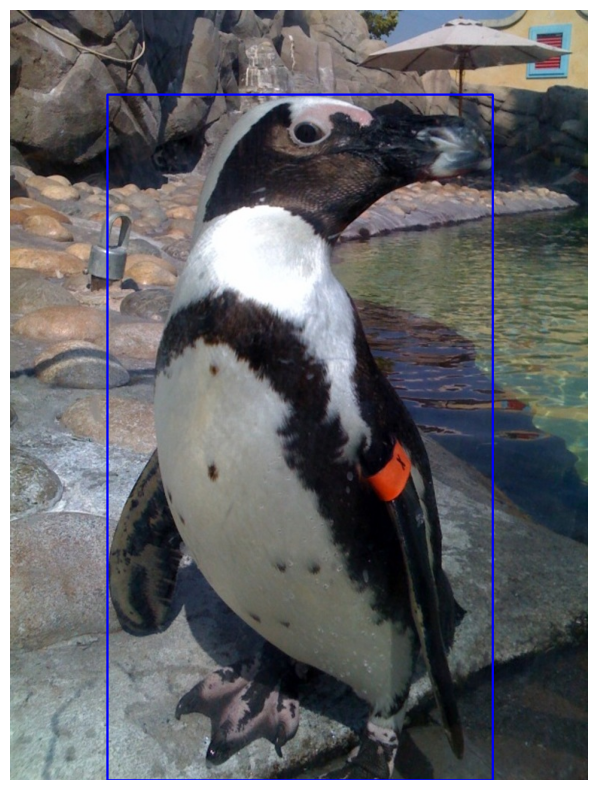

In [15]:
#print(bbox_arr)
draw_bboxes_and_show(image_path, bbox_arr)

## Get the OI7 images in a train, validation and test datasets ##


### original split as per the OI7 dataset ###
I am going to use the original train set. I am going to use the original test images for the validation set (there are more images in the test set than validation) and the original validation for the test set\
train = 894 images, 4197 bboxes \
validation = 97 images, 165 bboxes \
test = 42 images, 88 bboxes

In [1]:
# function to copy all the images that ids appear in a file to the desired location (specified for the yolo format)

def copy_images_based_on_ids(text_file_path, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs listed in a text file.
    
    :param text_file_path: Path to the text file containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Open the text file and read line by line
    with open(text_file_path, 'r') as file:
        for line in file:
            # Extract the ID from each line (assuming format 'some_text/<id>')
            line = line.strip()
            id_ = line.split('/')[-1]  # Splits the line at '/' and takes the last part as the ID

            # Construct the filename and the paths
            filename = f"{id_}.jpg"
            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(destination_dir, filename)

            # Check if the file exists and copy it to the destination directory
            if os.path.exists(source_path):
                shutil.copy(source_path, destination_path)
                print(f"Copied {filename} to {destination_dir}")
            else:
                print(f"File {filename} not found in {source_dir}")

In [ ]:
# copy images for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest images and will be used for my test set
text_file_path_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_ids.txt'
image_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
Yolo_image_folder_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/test'

copy_images_based_on_ids(text_file_path_test, image_source, Yolo_image_folder_test)

In [ ]:
# copy images for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest images and will be used for my test set
text_file_path_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_ids.txt'
image_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
Yolo_image_folder_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/val'

copy_images_based_on_ids(text_file_path_val, image_source, Yolo_image_folder_val)

In [ ]:
# copy images for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest images and will be used for my test set
text_file_path_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_ids.txt'
image_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
Yolo_image_folder_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/images/train'

copy_images_based_on_ids(text_file_path_train, image_source, Yolo_image_folder_train)

In [12]:
# function to copy all the text files that ids appear in a file to the desired location (specified for the yolo format)

def copy_annotation_based_on_ids(text_file_path, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs listed in a text file.
    
    :param text_file_path: Path to the text file containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Open the text file and read line by line
    with open(text_file_path, 'r') as file:
        for line in file:
            # Extract the ID from each line (assuming format 'some_text/<id>')
            line = line.strip()
            id_ = line.split('/')[-1]  # Splits the line at '/' and takes the last part as the ID

            # Construct the filename and the paths
            filename = f"{id_}.txt"
            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(destination_dir, filename)

            # Check if the file exists and copy it to the destination directory
            if os.path.exists(source_path):
                shutil.copy(source_path, destination_path)
                print(f"Copied {filename} to {destination_dir}")
            else:
                print(f"File {filename} not found in {source_dir}")

In [ ]:
# copy annotations for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest annotation and will be used for my test set
text_file_path_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_ids.txt'
annotation_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
Yolo_annotation_folder_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/test'

copy_annotation_based_on_ids(text_file_path_test, annotation_source, Yolo_annotation_folder_test)

In [ ]:
# copy annotations for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest annotation and will be used for my test set
text_file_path_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_ids.txt'
annotation_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
Yolo_annotation_folder_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/val'

copy_annotation_based_on_ids(text_file_path_val, annotation_source, Yolo_annotation_folder_val)

In [ ]:
# copy annotations for test files (the least amount of files first as a test)
# I am using the val ids as they have the fewest annotation and will be used for my test set
text_file_path_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_ids.txt'
annotation_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
Yolo_annotation_folder_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent/YoloV8_dataset_OI7/labels/train'

copy_annotation_based_on_ids(text_file_path_train, annotation_source, Yolo_annotation_folder_train)

### Data split as a 80%, 10%, 10% ###

#### first get all the annotation data in a single df and save it as a single json file

In [151]:
json_path_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/validation_full_annotation_NG.json'
json_path_test = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_full_annotation_NG.json'
json_path_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_full_annotation_NG.json'

In [152]:
# load the jsons to df for the different jsons saved
df_val_full_annotation = pd.read_json(json_path_val, orient='records')
df_test_full_annotation = pd.read_json(json_path_test, orient='records')
df_train_full_annotation = pd.read_json(json_path_train, orient='records')
print(df_val_full_annotation.shape)
print(df_test_full_annotation.shape)
print(df_train_full_annotation.shape)

(79, 17)
(137, 17)
(4050, 25)


In [153]:
# remove the addtiional col from the train df

# Find the common columns 
common_columns = df_test_full_annotation.columns.intersection(df_train_full_annotation.columns)
print(common_columns)

# Filter to only include columns that
df_train_full_annotation = df_train_full_annotation[common_columns]

Index(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin',
       'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction',
       'IsInside', 'XCentre', 'YCentre', 'Width', 'Height'],
      dtype='object')


In [154]:
print(df_val_full_annotation.shape)
print(df_test_full_annotation.shape)
print(df_train_full_annotation.shape)

(79, 17)
(137, 17)
(4050, 17)


In [155]:
# combine the dfs
df_full_annotations = pd.concat([df_val_full_annotation, df_test_full_annotation, df_train_full_annotation], ignore_index=True)

In [156]:
print(df_full_annotations.shape)

(4266, 17)


In [157]:
# save as a .json file so have all annotations in one place
json_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'
json_path = f'{json_path_parent}/full_annotation_NG.json'

df_full_annotations.to_json(json_path, orient='records')

#### create a list of all the unique ids and save that as a text file

In [158]:
# create a list of all the unique ids
unique_ids = df_full_annotations['ImageID'].unique()
unique_ids_list = list(unique_ids)

In [173]:
print(unique_ids_list[0:10])
print(len(unique_ids_list))

['028d762d6716abdf', '0d2d4e6cefec6f87', '1654d220ef8dfb40', '1e20429aac140db6', '1ed640a7fc509e10', '2285e2bc33ba20f5', '51e33647f123f1f2', '5c70eafd580d8b7a', '5e6e0fee02c9b9d9', '603e9c69b38bc96c']
979


In [168]:
# List to hold the names of image files
image_filenames = []

# location of images
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images_NG'

# Walk through the directory
for entry in os.listdir(path):
    # Check if the file is an image by checking its extension
    if entry.lower().endswith('.jpg'):
        name_without_extension = os.path.splitext(entry)[0]
        image_filenames.append(name_without_extension)

In [169]:
print(len(image_filenames))

979


In [170]:
image_filenames[0:10]

['39490cfbd98cc60d',
 '61b0469619ed2595',
 '09bd3fb57655e32b',
 '8c801e6a5c71bc33',
 'cadf13d8c9d2191f',
 '45e70a4e1c129610',
 '0c96f032ab729f02',
 '01ede19e59212780',
 '1a4a467531afcdef',
 'e8c038acb605c1a6']

In [9]:
def print_unique_names(list1, list2):
    """
    Compares two lists and prints the names that don't appear in both.

    :param list1: First list of names.
    :param list2: Second list of names.
    """
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)

    # Find names that are in either one of the lists but not both
    unique_names = set1.symmetric_difference(set2)

    # Print the unique names
    if unique_names:
        print("Names that don't appear in both lists:")
        for name in unique_names:
            print(name)
    else:
        print("All names appear in both lists.")

In [172]:
print_unique_names(unique_ids_list, image_filenames)

All names appear in both lists.


In [8]:
# save unique ids list as a text file
def save_list_to_file(list_data, file_path):
    """
    Saves a list to a text file with each entry on a new line.

    :param list_data: List of strings to be saved to a file.
    :param file_path: Path to the file where the list should be saved.
    """
    # Open the file for writing
    with open(file_path, 'w') as file:
        # Write each item on a new line
        for item in list_data:
            file.write(f"{item}\n")  # Add a newline after each item

In [175]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/full_list_ids.txt'
save_list_to_file(unique_ids_list, path)

#### use a seeded random spilt to split the list into 80, 10, 10 split

In [176]:
# use a seeded random spilt to split the list into 80, 10, 10 split
def split_data(ids, train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):
    """
    Splits a list into training, validation, and testing sets with specified proportions.

    :param ids: List of entries (ids) to be split.
    :param train_frac: Fraction of the list to be used as the training set.
    :param val_frac: Fraction of the list to be used as the validation set.
    :param test_frac: Fraction of the list to be used as the test set.
    :param seed: Seed for the random number generator to ensure reproducibility.
    :return: A tuple containing the training set, validation set, and testing set.
    """
    # Set the random seed for reproducibility
    random.seed(seed)

    # Shuffle the list randomly
    random.shuffle(ids)

    # Calculate split indices
    total = len(ids)
    train_end = int(total * train_frac)
    val_end = train_end + int(total * val_frac)

    # Split the data
    train_ids = ids[:train_end]
    val_ids = ids[train_end:val_end]
    test_ids = ids[val_end:]

    return train_ids, val_ids, test_ids

In [179]:
train_ids_NG, val_ids_NG, test_ids_NG = split_data(unique_ids_list)

In [180]:
print(len(train_ids_NG),len(val_ids_NG), len(test_ids_NG))

783 97 99


In [181]:
# save those lists
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/train_list_ids_NG.txt'
save_list_to_file(train_ids_NG, path)
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/val_list_ids_NG.txt'
save_list_to_file(val_ids_NG, path)
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_list_ids_NG.txt'
save_list_to_file(test_ids_NG, path)

#### create annotation text files and copy images and text files across to correct directories

In [183]:
# create images text files for all annotations
txt_file_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
df_to_YOLO_txt_file(df_full_annotations, txt_file_path_parent)

In [16]:
# copy images across according to what is in the list
# function to copy all the images that ids appear in a file to the desired location (specified for the yolo format)

def copy_images_based_on_ids_in_list(list, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs in list.
    
    :param text_file_path: list containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)


    for id_ in list:
        # Construct the filename and the paths
        filename = f"{id_}.jpg"
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if the file exists and copy it to the destination directory
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            #print(f"Copied {filename} to {destination_dir}")
        else:
            print(f"File {filename} not found in {source_dir}")

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/images/test'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
copy_images_based_on_ids_in_list(test_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/images/val'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
copy_images_based_on_ids_in_list(val_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/images/train'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images'
copy_images_based_on_ids_in_list(train_ids_NG, path_source, path_destination)

In [17]:
# copy txt files across according to what is in the list
# function to copy all the images that ids appear in a file to the desired location (specified for the yolo format)

def copy_annotation_based_on_ids_in_list(list, source_dir, destination_dir):
    """
    Copies images from source directory to destination directory based on IDs in list.
    
    :param text_file_path: list containing IDs.
    :param source_dir: Directory where images are stored (images should be named as <id>.jpg).
    :param destination_dir: Directory to which images will be copied.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)


    for id_ in list:
        # Construct the filename and the paths
        filename = f"{id_}.txt"
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if the file exists and copy it to the destination directory
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            #print(f"Copied {filename} to {destination_dir}")
        else:
            print(f"File {filename} not found in {source_dir}")

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/test'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
copy_annotation_based_on_ids_in_list(test_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/val'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
copy_annotation_based_on_ids_in_list(val_ids_NG, path_source, path_destination)

In [ ]:
path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/train'
path_source = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations_NG'
copy_annotation_based_on_ids_in_list(train_ids_NG, path_source, path_destination)

### K-5 test data split ###

#### randomly split the list of ids into 5 equal sized lists of ids ####

In [2]:
# load ids into list 
def load_file_to_list(file_path):
    """
    loads a text file to a list with each entry on a new line becoming a new entry in the list.

    :param file_path: Path to the file where the list should be saved.
    :return list of data from file
    """
    # Open the file for writing
    lst = []
    with open(file_path, 'r') as file:
        # Write each item on a new line
        for line in file:
            lst.append(line.strip())
    return lst

In [7]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/full_list_ids_NG.txt'
ids_full_list = load_file_to_list(path)

In [8]:
len(ids_full_list)

979

In [9]:
# use a seeded random spilt to split the list equal sized portions
def split_data_k5(ids, split_num=5, seed=42):
    """
    Splits a list into specified number of equal amounts of data.

    :param ids: List of entries (ids) to be split.
    :param split_num: number of equal portions to split into
    :param seed: Seed for the random number generator to ensure reproducibility.
    :return: A tuple containing the training set, validation set, and testing set.
    """
    # Set the random seed for reproducibility
    random.seed(seed)

    # Shuffle the list randomly
    random.shuffle(ids)

    # Calculate split indices
    total = len(ids)
    split_size = math.ceil(total/split_num)

    # create the sublist (a list that will contain the other lists)
    sublist = []

    # Split the data
    start = 0
    for step in range (split_num):
        
        if step == split_num:
            sublist.append(ids[start:])
            
        end = start + split_size
        sublist.append(ids[start:end])
        start = end

    return sublist 

In [10]:
split_lists_k5 = split_data_k5(ids=ids_full_list)

In [20]:
print(len(split_lists_k5))
print(split_lists_k5[0][-10:])
print(len(split_lists_k5[0]))
print(len(split_lists_k5[1]))
print(split_lists_k5[1][0:10])
print(len(split_lists_k5[2]))
print(len(split_lists_k5[3]))
print(len(split_lists_k5[4]))

5
['3fa24eb0ac5f2920', '381820d77d917c77', '0fc9c39c0088fb44', '1fb2510178f6691a', '8b36e2151062a1a6', '08d15153dc7c4f3c', '059df03cecae9277', 'cc1b65537217b5ac', 'edd290e03daea8a1', '05d9a787bf5fce80']
196
196
['f2fc7360d0ffa32e', 'a9e4a8ab99442e99', 'dfbf6d1f38fd1b13', '1d502c12cae60c03', '6b74810255f981f4', '4fd50dedb16f19c0', '499091cedafcda03', '1b43f0e9a4b94d4f', 'b7c1e8d8a7bd96d8', '49a0e3e402838c24']
196
196
195


In [23]:
# save the lists to file to keep the same lists everytime you are training
parent_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/'
count = 1
for sub_lst in split_lists_k5:
    path = f'{parent_path}k5_data_split_list_{count}'
    save_list_to_file(sub_lst, path)
    count += 1

# Train YOLOv8 model

## Trials ##

In [2]:
# NANO MODEL FROM SCRATCH
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.yaml')

In [3]:
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'

In [4]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
results = model.train(data=data_path, cfg=cfg_path)

In [6]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# SMALL MODEL FROM SCRATCH
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8s.yaml')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [8]:
del model

In [11]:
del results

In [13]:
del colors

In [15]:
import gc

In [21]:
gc.collect()

13704

In [19]:
1/0

ZeroDivisionError: division by zero

In [22]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# MEDIUM MODEL FROM SCRATCH
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8m.yaml')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [ ]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# NANO MODEL PRETRAINED
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [ ]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# SMALL MODEL PRETRAINED
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8s.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

In [ ]:
# delete tensors that are not in use and clear cache
torch.cuda.empty_cache()

In [ ]:
# MEDIUM MODEL PRETRAINED
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8m.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_NG.yaml')
cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, cfg=cfg_path)

## K-5 Experiment development ##

### create the l=ist of the text file list names

In [2]:
# create the l=ist of the text file list names
PARENT_PATH_RAW_DATA = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/'
K5ParentList = ['k5_data_split_list_1', 'k5_data_split_list_2','k5_data_split_list_3','k5_data_split_list_4','k5_data_split_list_5']

### for loop

In [3]:
# for loop
for K5_curr_Split in K5ParentList:
    print(PARENT_PATH_RAW_DATA+K5_curr_Split)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/k5_data_split_list_1
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/k5_data_split_list_2
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/k5_data_split_list_3
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/k5_data_split_list_4
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/k5_data_split_list_5


### load chosen split to val and rest of the ids to a train list

In [10]:
# load chosen split to val and rest of the ids to a train list
K5_val_id_list = load_file_to_list(PARENT_PATH_RAW_DATA+K5_curr_Split)
K5_train_id_list = []
for split in K5ParentList:
    if split != K5_curr_Split:
        K5_train_id_list.extend(load_file_to_list(PARENT_PATH_RAW_DATA+split))

In [11]:
print(len(K5_train_id_list), len(K5_val_id_list))
#print(K5_train_id_list)
# check that lists only contain unique ids
bool(set(K5_train_id_list) & set(K5_val_id_list))

784 195


False

### del the contents of the train and val folders for both the images and annotations

In [4]:
# create paths
K5_YOLO_DATA_PATH = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/'
list_of_dir_to_clear = ['YoloV8_dataset_OI7_K5/images/train', 'YoloV8_dataset_OI7_K5/images/val', 'YoloV8_dataset_OI7_K5/labels/train', 'YoloV8_dataset_OI7_K5/labels/val']

In [6]:
def clear_directory(dir_path):
    """
    Removes all files and subdirectories within the specified directory without deleting the directory itself.

    :param dir_path: Path to the directory to clear.
    """
    # Check if the directory exists
    if not os.path.isdir(dir_path):
        print("The specified path is not a directory.")
        return

    # Iterate over each item in the directory
    for item_name in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item_name)  # Full path to the item

        # Check if the item is a file or directory and remove it
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.remove(item_path)  # Remove the file or link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove the directory and all its contents

In [7]:
for dir in list_of_dir_to_clear:
    dir_to_clear = K5_YOLO_DATA_PATH+dir
    # clear dir
    clear_directory(dir_to_clear)

### move images to the train and val folders

In [15]:
list_yolo_image_dirs = list_of_dir_to_clear[:2]
#print(list_yolo_image_dirs)
path_source =PARENT_PATH_RAW_DATA+'OpenImageV7_raw_images'
#print(path_source)
for dir in list_yolo_image_dirs:
    dir_to_copy_to = K5_YOLO_DATA_PATH+dir
    if 'train' in dir:
        print(dir_to_copy_to)
        copy_images_based_on_ids_in_list(K5_train_id_list, path_source, dir_to_copy_to)
    else:
        print(dir_to_copy_to)
        copy_images_based_on_ids_in_list(K5_val_id_list, path_source, dir_to_copy_to)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5/images/train
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5/images/val


### move annotations to the train and val folders

In [16]:
#path_destination = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_NG/YoloV8_dataset_OI7_NG/labels/test'
list_yolo_anno_dirs = list_of_dir_to_clear[2:]
#print(list_yolo_image_dirs)
path_source = PARENT_PATH_RAW_DATA+'OI7_Yolo_annotations_NG'
#copy_annotation_based_on_ids_in_list(test_ids_NG, path_source, path_destination)
for dir in list_yolo_anno_dirs:
    dir_to_copy_to = K5_YOLO_DATA_PATH+dir
    if 'train' in dir:
        print(dir_to_copy_to)
        copy_annotation_based_on_ids_in_list(K5_train_id_list, path_source, dir_to_copy_to)
    else:
        print(dir_to_copy_to)
        copy_annotation_based_on_ids_in_list(K5_val_id_list, path_source, dir_to_copy_to)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5/labels/train
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5/labels/val


### Validation of k-5

In [10]:
# create a function to save the results structured as a dict to a json file
def save_dict_to_json(data, save_dir, file_name):
    '''
    saves a dictionary to a json file
    param:data: the dictionary to be saved
    param:save_dir: path to the directory that the json file will be saved to
    param:file_name: name of the json file that you want to save (MUST NOT INCLUDE EXTENSION)
    '''
    # convert dict to dataframe
    df = pd.DataFrame(data)

    # create save dir if doesn't already exist
    os.makedirs(save_dir, exist_ok=True)

    # create output file path
    json_file_path = os.path.join(save_dir, f'{file_name}.json')

    # save df to json
    df.to_json(json_file_path, orient='records', indent=4)


In [29]:
def Val(model_path, run_name):
    data_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5.yaml'
    model = YOLO(model_path)
    #results, maps, times = model.val(data=data_path, device=0, name=run_name)
    # capture the terminal output
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        results = model.val(data=data_path, device=0, name=run_name)

    # Ensure all output is written to the StringIO buffer
    sys.stdout.flush()
    
    # get the output as a string
    term_output = f.getvalue()

    # save the results
    data = {
        'results': [results],
        #'maps' : [maps],
        #'times' : [times]
    }

    save_dir = os.path.join('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect', run_name)

    file_name = run_name.split('.')[0]+'_val_results'

    save_dict_to_json(data, save_dir, file_name)

    # save the terminal output as a text file
    text_file_output_name = file_name+'_term.txt'
    text_file_output_path = os.path.join(save_dir, text_file_output_name)
    with open(text_file_output_path, 'w') as output_file:
        output_file.write(term_output)



In [ ]:
model_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/k5_data_split_list_2_yolov8n.pt/weights/best.pt'
run_name = 'k5_data_split_list_2_yolov8n.pt/val'
Val(model_path, run_name)

## Hyperparameter Tuning

### create new dataset with 90% train and 10% val

In [4]:
PARENT_PATH_RAW_DATA = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/'

In [5]:
# load chosen split to val and rest of the ids to a train list
val_id_list = load_file_to_list(PARENT_PATH_RAW_DATA+'val_list_ids_NG.txt')
train_id_list = load_file_to_list(PARENT_PATH_RAW_DATA+'train_list_ids_NG.txt')
train_id_list.extend(load_file_to_list(PARENT_PATH_RAW_DATA+'test_list_ids_NG.txt'))

In [21]:
print(val_id_list[0:5])

['1e20429aac140db6', 'd94d694c79b4545d', '079f2e40e344032f', '3bd97943dbf2c585', 'e110b181363ee54b']


In [6]:
len(val_id_list)

97

In [7]:
len(train_id_list)

882

In [11]:
def check_unique_values(list1, list2):
    """
    Checks if the values in two lists are unique (i.e., no duplicates between the two lists).

    :param list1: First list of values.
    :param list2: Second list of values.
    :return: True if all values are unique across both lists, False otherwise.
    """
    # Convert lists to sets to remove any duplicates within each list
    set1 = set(list1)
    set2 = set(list2)

    # Check if there are any common elements between the two sets
    common_elements = set1.intersection(set2)

    # If common_elements is empty, all values are unique across both lists
    return len(common_elements) == 0

In [12]:
check_unique_values(train_id_list, val_id_list)

True

In [13]:
# save to file
save_list_to_file(list_data=train_id_list, file_path=PARENT_PATH_RAW_DATA+"train_id_list_HPTune.txt")

In [14]:
# save to file
save_list_to_file(list_data=val_id_list, file_path=PARENT_PATH_RAW_DATA+"val_id_list_HPTune.txt")

In [ ]:
# create the directories manually

In [ ]:
# load file to list (use the below funciton)
#K5_val_id_list = load_file_to_list(PARENT_PATH_RAW_DATA+K5_curr_Split)

In [ ]:
# create paths
K5_YOLO_DATA_PATH = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/'
list_of_dir_to_clear = ['YoloV8_dataset_OI7_K5/images/train', 'YoloV8_dataset_OI7_K5/images/val', 'YoloV8_dataset_OI7_K5/labels/train', 'YoloV8_dataset_OI7_K5/labels/val']

In [25]:
path_source =PARENT_PATH_RAW_DATA+'OpenImageV7_raw_images'
path_to_image_dir_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/images/train'
path_to_image_dir_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/images/val'

copy_images_based_on_ids_in_list(train_id_list, path_source, path_to_image_dir_train)

copy_images_based_on_ids_in_list(val_id_list, path_source, path_to_image_dir_val)

In [24]:
path_source =PARENT_PATH_RAW_DATA+'OI7_Yolo_annotations_NG'
path_to_annotation_dir_train = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train'
path_to_annotation_dir_val = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val'

copy_annotation_based_on_ids_in_list(train_id_list, path_source, path_to_annotation_dir_train)
copy_annotation_based_on_ids_in_list(val_id_list, path_source, path_to_annotation_dir_val)

### Finding the default parameters for each optimisation function

#### Straight default ####
AdamW, lr=0.002, momentum=0.9

In [ ]:
# NANO MODEL PRETRAINED 
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(data=data_path, name='HPTune_straight_default', epochs=100, device=0, batch=8)

In [2]:
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(
    data= data_path,
    optimizer='AdamW',
    lr0=0.00583, # (float) initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
    lrf=0.009, # (float) final learning rate (lr0 * lrf)
    momentum=0.7, # (float) SGD momentum/Adam beta1
    epochs=200,
    patience=50,
    batch=8,
    name='AdamW_Train',
    project='Select_Optimiser',
    single_cls = True,
    device=0,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    hsv_h=0.015, # (float) image HSV-Hue augmentation (fraction)
    hsv_s=0.7, # (float) image HSV-Saturation augmentation (fraction)
    hsv_v=0.4, # (float) image HSV-Value augmentation (fraction)
    translate=0.1, # (float) image translation (+/- fraction)
    scale=0.55, # (float) image scale (+/- gain)
    fliplr=0.5, # (float) image flip left-right (probability)
    mosaic=0.3, # (float) image mosaic (probability)
    )

New https://pypi.org/project/ultralytics/8.2.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=200, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Select_Optimiser, name=AdamW_Train6, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to Select_Optimiser/AdamW_Train6/labels.jpg... 
optimizer: AdamW(lr=0.00583, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to Select_Optimiser/AdamW_Train6
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       1.5G      1.808      2.192      1.698          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]

                   all         97        461      0.282      0.206      0.139     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      1.37G      2.095      2.251      2.007         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]

                   all         97        461      0.082      0.156     0.0381     0.0136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      1.44G      2.076      2.158      1.956          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]

                   all         97        461      0.309      0.299      0.184     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      1.47G      2.021      2.075      1.912          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]

                   all         97        461      0.344       0.33      0.269       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.49G      1.896      1.972      1.831          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]

                   all         97        461      0.448      0.215      0.195      0.092



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      1.53G      1.855      1.856      1.752          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.46it/s]

                   all         97        461      0.419      0.322       0.29      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200     0.308G       1.79      1.793      1.725          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]

                   all         97        461      0.432      0.296      0.283      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      1.52G      1.848      1.818      1.738         18        640: 100%|██████████| 111/111 [00:11<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

                   all         97        461      0.387      0.291       0.26      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.52G      1.717      1.712      1.695         24        640: 100%|██████████| 111/111 [00:10<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.34it/s]

                   all         97        461      0.565      0.351      0.368       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      1.49G      1.709      1.647      1.651         17        640: 100%|██████████| 111/111 [00:11<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]

                   all         97        461      0.517      0.399      0.433      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      1.38G      1.665       1.61      1.637         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]

                   all         97        461      0.585      0.419      0.459      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      1.44G      1.619      1.557      1.604          7        640: 100%|██████████| 111/111 [00:11<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.93it/s]

                   all         97        461      0.503      0.423      0.369      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      1.41G      1.674      1.548      1.596          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]

                   all         97        461      0.606      0.419      0.452       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       1.4G      1.601      1.505      1.568          4        640: 100%|██████████| 111/111 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.45it/s]

                   all         97        461      0.646      0.414      0.459      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      1.41G      1.601      1.502      1.575         20        640: 100%|██████████| 111/111 [00:10<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]

                   all         97        461      0.604      0.412      0.461      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      1.44G      1.574      1.463      1.546          7        640: 100%|██████████| 111/111 [00:10<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

                   all         97        461       0.66      0.434      0.479      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200       1.5G      1.578      1.457      1.562          4        640: 100%|██████████| 111/111 [00:11<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.559      0.445      0.476      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      1.51G      1.566        1.4      1.529          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]

                   all         97        461      0.688       0.46      0.517      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      1.56G      1.553      1.451      1.536         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]

                   all         97        461      0.574      0.453      0.477      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200     0.325G      1.557      1.391      1.513          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]

                   all         97        461      0.669      0.462      0.509      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      1.44G       1.52      1.369      1.495          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]

                   all         97        461      0.682      0.464      0.549      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      1.57G       1.51      1.358      1.501          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]

                   all         97        461      0.656      0.484      0.535      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.44G      1.498      1.313      1.477         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]

                   all         97        461      0.692      0.472      0.538      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      1.37G      1.473      1.353      1.491         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]

                   all         97        461      0.686      0.492      0.555      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      1.44G      1.487      1.316      1.474          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461       0.74      0.484       0.57      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.44G      1.474      1.282      1.474          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]

                   all         97        461      0.722       0.46      0.537      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      1.41G       1.44      1.283      1.466          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]

                   all         97        461      0.707      0.471      0.555       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      1.32G      1.443      1.222      1.442          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]

                   all         97        461      0.651      0.512      0.558      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      1.43G      1.394      1.224       1.42          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

                   all         97        461      0.663      0.513      0.567      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      1.48G      1.401      1.222      1.438          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

                   all         97        461      0.722      0.479      0.547      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      1.37G      1.419      1.232      1.439         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

                   all         97        461      0.638      0.515      0.568      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      1.52G      1.396      1.218      1.419         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

                   all         97        461      0.629      0.514      0.577      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      1.45G      1.446      1.228      1.434         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]

                   all         97        461      0.693      0.488      0.572      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      1.45G      1.377      1.197      1.419          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.715      0.464      0.552       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      1.44G      1.382      1.196      1.432          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]

                   all         97        461       0.69      0.521      0.571      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      1.44G       1.39      1.198      1.414          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]

                   all         97        461      0.715      0.473      0.547      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      1.47G       1.35      1.145      1.398          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.34it/s]

                   all         97        461      0.643      0.486       0.54      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      1.53G      1.381      1.148      1.407          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

                   all         97        461      0.641      0.499      0.564      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      1.37G      1.366      1.155      1.414          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]

                   all         97        461      0.654      0.518      0.582      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      1.42G      1.374      1.151      1.402          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]

                   all         97        461      0.658      0.525      0.579       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200       1.4G      1.381       1.16      1.399          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]

                   all         97        461      0.649       0.53      0.578      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      1.48G      1.339      1.105      1.375          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

                   all         97        461      0.705      0.534      0.599      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      1.44G       1.33      1.103       1.37          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.04it/s]

                   all         97        461      0.721      0.501      0.599      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      1.53G      1.324      1.083      1.374          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all         97        461      0.712      0.521      0.596      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.42G      1.324      1.113      1.365          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]

                   all         97        461      0.748      0.482      0.586      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      1.59G      1.337      1.095      1.376          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

                   all         97        461      0.747      0.512      0.593      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      1.45G      1.311      1.093      1.362         24        640: 100%|██████████| 111/111 [00:11<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]

                   all         97        461       0.62      0.564      0.605       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      1.49G      1.296      1.091       1.37         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]

                   all         97        461      0.642       0.57      0.602      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.52G      1.313      1.055      1.343          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461      0.662      0.529      0.613      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      1.42G      1.307      1.055      1.351          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.65it/s]

                   all         97        461      0.686      0.516      0.578      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      1.46G      1.331      1.088       1.37         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

                   all         97        461      0.707      0.534      0.604      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200     0.325G       1.32       1.02       1.34         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]

                   all         97        461      0.635      0.584      0.618       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200     0.308G      1.259      1.029      1.341          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]

                   all         97        461      0.715      0.512      0.599      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      1.35G      1.279      1.017      1.342         17        640: 100%|██████████| 111/111 [00:11<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]

                   all         97        461      0.724      0.552      0.608      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.56G      1.265      1.028      1.336          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]

                   all         97        461      0.682       0.54       0.61      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      1.51G      1.278      1.023      1.326         16        640: 100%|██████████| 111/111 [00:11<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

                   all         97        461      0.734      0.508      0.605      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      1.29G      1.284      1.011      1.348          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.26it/s]

                   all         97        461      0.591      0.579      0.595      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.44G      1.255      1.009      1.314         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.30it/s]

                   all         97        461      0.615      0.564      0.619      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      1.52G      1.265      1.015       1.34          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]

                   all         97        461       0.69      0.575      0.633      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.49G      1.243     0.9969      1.325         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

                   all         97        461      0.687      0.551      0.614      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      1.52G      1.257     0.9958      1.329          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]

                   all         97        461      0.686      0.539      0.596      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      1.35G      1.212     0.9733      1.301         12        640: 100%|██████████| 111/111 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]

                   all         97        461      0.692      0.507      0.595      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      1.38G      1.236     0.9798      1.323          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]

                   all         97        461      0.675      0.597      0.656      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      1.52G       1.23     0.9836      1.307          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]

                   all         97        461      0.628       0.56      0.611      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200     0.321G      1.229      1.013      1.305          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.674       0.52      0.612      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      1.49G      1.197     0.9565      1.285          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.651      0.581      0.634      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      1.53G      1.228     0.9737      1.304          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

                   all         97        461      0.687      0.568      0.624      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      1.39G      1.207     0.9586      1.286          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]

                   all         97        461      0.679       0.61      0.657      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      1.28G      1.199      0.949      1.286         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]

                   all         97        461      0.664      0.597      0.642       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.56G      1.247     0.9491      1.294         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]

                   all         97        461      0.704      0.553      0.638       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       1.4G      1.235     0.9547      1.295          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]

                   all         97        461       0.68      0.582      0.647      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      1.46G      1.182     0.9254      1.284          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.674      0.564      0.633      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      1.44G      1.184     0.9305      1.271          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]

                   all         97        461      0.641      0.582      0.634      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      1.43G      1.209     0.9309      1.276          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]

                   all         97        461      0.694      0.565       0.61      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      1.43G      1.193     0.9268      1.265         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]

                   all         97        461      0.667      0.594      0.642      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      1.47G      1.209     0.9248      1.272          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

                   all         97        461      0.697      0.592      0.642      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      1.51G      1.185     0.9094      1.261         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

                   all         97        461      0.711       0.59      0.658      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      1.38G      1.179     0.9006      1.265          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]

                   all         97        461      0.646      0.584      0.636      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       1.4G      1.184     0.9033      1.258          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]

                   all         97        461      0.696      0.592       0.64      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      1.48G      1.176     0.9046      1.276          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

                   all         97        461      0.672       0.56      0.638      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      1.52G      1.182     0.9185      1.272          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

                   all         97        461       0.68       0.57      0.629      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      1.42G      1.157     0.8817       1.25         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]

                   all         97        461      0.704      0.568      0.636      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      1.61G      1.186     0.9019      1.265          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461      0.695      0.592      0.644      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      1.44G      1.145     0.8827      1.254          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

                   all         97        461      0.776      0.532      0.638      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      1.48G      1.179     0.8699      1.268          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]

                   all         97        461      0.641      0.601      0.627      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      1.43G       1.13     0.8632      1.235         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

                   all         97        461      0.698      0.617      0.662      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      1.51G      1.127     0.8598      1.239          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]

                   all         97        461      0.697      0.614      0.667      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      1.49G      1.151     0.8759      1.244         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]

                   all         97        461      0.651      0.636      0.646      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      1.34G      1.161     0.8702      1.251         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]

                   all         97        461      0.673      0.614      0.654      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      1.51G      1.134     0.8645       1.24          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]

                   all         97        461      0.711      0.594      0.666      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      1.31G      1.148     0.8524       1.24          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

                   all         97        461      0.703      0.591       0.66      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      1.42G      1.115     0.8105      1.228          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.722      0.594      0.652      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      1.46G      1.155     0.8596      1.234         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]

                   all         97        461      0.705      0.651      0.689       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      1.51G      1.157     0.8574       1.24          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]

                   all         97        461      0.726      0.626      0.693      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      1.47G       1.14     0.8518       1.24          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]

                   all         97        461      0.727      0.588      0.669      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200       1.4G      1.125     0.8378      1.237          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]

                   all         97        461      0.689      0.603       0.66      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      1.49G      1.154      0.852      1.238         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]

                   all         97        461      0.664      0.575      0.644      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      1.51G       1.13     0.8255      1.234          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]

                   all         97        461      0.737      0.601      0.687      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200     0.319G      1.133     0.8282      1.218          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]

                   all         97        461       0.72      0.557      0.641      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      1.51G      1.102     0.8037       1.22          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

                   all         97        461      0.755      0.592      0.676      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      1.42G       1.14     0.8402       1.22         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]

                   all         97        461      0.721      0.605      0.686      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200     0.342G      1.099      0.798      1.199         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]

                   all         97        461      0.697      0.614      0.667      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      1.44G      1.092     0.7876      1.189          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]

                   all         97        461      0.731      0.619      0.686      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.38G       1.11     0.8233      1.226         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]

                   all         97        461      0.694      0.592      0.644        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      1.44G       1.06     0.7961      1.194          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]

                   all         97        461      0.744      0.603      0.674      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      1.39G       1.09     0.7937      1.209          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]

                   all         97        461        0.7       0.59       0.66      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      1.46G      1.096     0.7929      1.208          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461       0.73      0.616      0.681      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      1.54G       1.09     0.8026      1.199          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

                   all         97        461      0.712      0.627      0.684      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      1.44G       1.07     0.7849      1.185          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

                   all         97        461      0.682      0.629      0.682      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       1.4G      1.087     0.7825      1.207          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

                   all         97        461      0.717      0.599      0.685      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      1.39G      1.067     0.7609      1.192          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.29it/s]

                   all         97        461      0.747      0.627      0.699       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200     0.308G      1.089     0.7788      1.205         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]

                   all         97        461      0.712      0.642      0.688      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      1.36G      1.087     0.7821      1.197          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

                   all         97        461      0.733      0.627      0.684      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      1.42G      1.061     0.7671      1.185          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all         97        461      0.675      0.633      0.676      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      1.51G      1.069      0.779      1.195          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

                   all         97        461      0.746       0.61      0.682      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      1.38G      1.043     0.7578      1.179          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]

                   all         97        461      0.728      0.588      0.669      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200     0.323G      1.068     0.7673      1.186          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]

                   all         97        461       0.73      0.616      0.703      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      1.42G      1.082     0.7834      1.193          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]

                   all         97        461      0.708      0.618      0.676       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      1.44G       1.06     0.7581      1.195         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]

                   all         97        461       0.71       0.61      0.678      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      1.31G      1.083     0.7892      1.201          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]

                   all         97        461      0.671      0.633       0.67      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       1.4G      1.061     0.7435       1.18          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]

                   all         97        461      0.694      0.614      0.682      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      1.38G      1.028     0.7173      1.171          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

                   all         97        461      0.677      0.623      0.681      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      1.41G      1.044     0.7427      1.171         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]

                   all         97        461      0.681      0.616      0.677      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      1.46G      1.048     0.7324      1.174         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]

                   all         97        461       0.71      0.616      0.682      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.44G       1.04     0.7457      1.161         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]

                   all         97        461       0.71      0.594      0.676      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       1.3G      1.039     0.7195      1.184         27        640:  41%|████      | 45/111 [00:04<00:07,  9.31it/s]


KeyboardInterrupt: 

##### Continue interrupted training

In [10]:
# continue interrupted training 
model = YOLO('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/Select_Optimiser/AdamW_Train6/weights/best.pt')
results = model.train(resume=True)

Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/Select_Optimiser/AdamW_Train6/weights/best.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=200, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Select_Optimiser, name=AdamW_Train6, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to Select_Optimiser/AdamW_Train6/labels.jpg... 
optimizer: AdamW(lr=0.00583, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training from /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/Select_Optimiser/AdamW_Train6/weights/best.pt from epoch 123 to 200 total epochs
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to Select_Optimiser/AdamW_Train6
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       1.5G      1.058     0.7521       1.17          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]

                   all         97        461      0.706      0.616      0.669      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      1.38G      1.045     0.7468      1.183         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]

                   all         97        461       0.75      0.592      0.674       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.44G      1.035     0.7267      1.167          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.29it/s]

                   all         97        461      0.669      0.644       0.69      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      1.47G      1.037     0.7327      1.167          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.75it/s]

                   all         97        461      0.727      0.618      0.687      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      1.49G      1.029     0.7235      1.177          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.85it/s]

                   all         97        461      0.688      0.637      0.678      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      1.53G      1.038     0.7178      1.159          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.15it/s]

                   all         97        461      0.699      0.623      0.669       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200     0.308G      1.027     0.7183      1.169          4        640: 100%|██████████| 111/111 [00:10<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]

                   all         97        461       0.73      0.603      0.672      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      1.51G      1.053     0.7453      1.162         18        640: 100%|██████████| 111/111 [00:10<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]

                   all         97        461      0.716      0.612      0.679      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      1.52G      1.014     0.7089      1.169         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]

                   all         97        461      0.708      0.636      0.685      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      1.49G      1.056      0.742      1.177         17        640: 100%|██████████| 111/111 [00:10<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]

                   all         97        461      0.692      0.638      0.689      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      1.38G      1.024     0.7255      1.165         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.52it/s]

                   all         97        461      0.751      0.601      0.688      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      1.44G      1.007     0.7023      1.157          7        640: 100%|██████████| 111/111 [00:10<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]

                   all         97        461      0.725      0.612      0.683      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      1.41G      1.064     0.7194      1.159          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]

                   all         97        461      0.699      0.568       0.65      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200       1.4G      1.017     0.6945      1.149          4        640: 100%|██████████| 111/111 [00:10<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

                   all         97        461      0.701       0.62      0.673      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      1.41G     0.9969     0.7041      1.147         20        640: 100%|██████████| 111/111 [00:10<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.714      0.616      0.679      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      1.44G      1.006      0.695      1.142          7        640: 100%|██████████| 111/111 [00:10<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all         97        461      0.773       0.59      0.677      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200       1.5G      1.004     0.6922       1.15          4        640: 100%|██████████| 111/111 [00:10<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]

                   all         97        461      0.722      0.614      0.677      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      1.51G      1.031     0.6945      1.152          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]

                   all         97        461      0.738      0.607      0.687      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200     0.327G     0.9891     0.6855      1.136         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]

                   all         97        461      0.754       0.61      0.695      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      1.31G      1.043     0.6916      1.149          8        640: 100%|██████████| 111/111 [00:10<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]

                   all         97        461      0.753       0.61      0.701      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      1.44G      1.014     0.7051      1.142          6        640: 100%|██████████| 111/111 [00:10<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

                   all         97        461      0.733      0.627       0.69      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200     0.325G      1.009     0.6928      1.155          9        640: 100%|██████████| 111/111 [00:10<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.59it/s]

                   all         97        461      0.761      0.618      0.695      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      1.44G      1.002     0.6766      1.131         16        640: 100%|██████████| 111/111 [00:10<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.85it/s]

                   all         97        461      0.747      0.628      0.691      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      1.37G     0.9717      0.672      1.129         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]

                   all         97        461      0.756      0.603      0.687      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      1.44G      1.011     0.6876      1.145          3        640: 100%|██████████| 111/111 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

                   all         97        461      0.734      0.612      0.677       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      1.44G     0.9888     0.6729      1.135          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]

                   all         97        461      0.718      0.618      0.677      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      1.41G     0.9655     0.6624      1.129          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

                   all         97        461       0.76      0.581      0.678      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      1.32G      0.987     0.6644      1.125          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.25it/s]

                   all         97        461      0.739      0.613      0.678      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      1.43G     0.9614     0.6548       1.12          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]

                   all         97        461      0.753      0.616      0.697      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      1.47G     0.9593     0.6477      1.118          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.32it/s]

                   all         97        461      0.752      0.592      0.669      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      1.37G     0.9754     0.6662       1.13         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.723      0.614      0.682      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      1.52G     0.9584     0.6607      1.117         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]

                   all         97        461      0.786      0.598      0.694      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      1.45G      1.007     0.6633      1.129         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]

                   all         97        461      0.781      0.599      0.693      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      1.45G     0.9448     0.6589      1.117          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]

                   all         97        461      0.737      0.612      0.683      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      1.44G     0.9446     0.6556      1.117          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]

                   all         97        461      0.781       0.59      0.687      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      1.44G     0.9784     0.6517      1.131          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]

                   all         97        461      0.757      0.577      0.671      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      1.47G     0.9405     0.6305      1.111          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]

                   all         97        461      0.762      0.604      0.686      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      1.53G     0.9626     0.6374      1.121          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]

                   all         97        461      0.732      0.603      0.674      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      1.37G     0.9408     0.6323      1.127          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

                   all         97        461      0.803      0.592      0.697      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      1.42G      0.956     0.6403      1.116          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]

                   all         97        461      0.789      0.593      0.694      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200       1.4G     0.9552     0.6596      1.111          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

                   all         97        461      0.762      0.597      0.688      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      1.48G     0.9325     0.6314      1.103          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]

                   all         97        461      0.744      0.607      0.682      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      1.44G     0.9325     0.6305      1.104          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.63it/s]

                   all         97        461      0.746      0.618      0.691      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      1.53G     0.9185     0.6115      1.098          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]

                   all         97        461      0.768      0.612       0.68      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      1.42G     0.9428     0.6301      1.107          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]

                   all         97        461      0.745      0.625      0.689      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200     0.323G     0.9342     0.6196        1.1          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]

                   all         97        461      0.702       0.64      0.691      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      1.45G     0.9338     0.6187       1.11         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]

                   all         97        461      0.749      0.601      0.678      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      1.49G      0.902     0.6187      1.097         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]

                   all         97        461      0.745      0.601      0.673      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      1.52G     0.9482     0.6198        1.1          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]

                   all         97        461       0.76      0.597      0.679      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      1.42G      0.931      0.624      1.101          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.773      0.588      0.691      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      1.46G     0.9482     0.6347      1.107         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]

                   all         97        461      0.747      0.603      0.675      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      1.41G     0.9401      0.612      1.091         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]

                   all         97        461      0.757      0.573      0.671      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      1.33G     0.8772     0.5981      1.086          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]

                   all         97        461      0.745      0.605      0.687      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      1.35G     0.9065     0.5942      1.093         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]

                   all         97        461       0.72      0.616      0.689      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      1.56G     0.9107     0.6031        1.1          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.763      0.594      0.677       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      1.51G     0.8977     0.5928      1.075         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]

                   all         97        461      0.761       0.59      0.682      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      1.28G     0.9095     0.5924      1.093          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

                   all         97        461      0.714      0.618      0.681      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      1.44G     0.9065     0.5889      1.087         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.05it/s]

                   all         97        461      0.755      0.627      0.698      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      1.51G     0.8914      0.583      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]

                   all         97        461      0.755      0.612      0.687      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      1.49G     0.8888     0.5835      1.087         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.35it/s]

                   all         97        461      0.747      0.614      0.687      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      1.52G      0.899     0.5939       1.09          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]

                   all         97        461      0.741      0.603       0.68      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      1.35G      0.882     0.5862      1.071         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]

                   all         97        461      0.777      0.595      0.677      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      1.37G     0.8811     0.5819      1.083          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]

                   all         97        461      0.709      0.618      0.681      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      1.52G     0.8808     0.5851      1.079          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]

                   all         97        461      0.711      0.629      0.681      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      1.63G     0.8669     0.5936      1.066          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.35it/s]

                   all         97        461       0.73      0.603      0.673      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      1.49G      0.854     0.5617      1.064          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]

                   all         97        461      0.709      0.617      0.678      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      1.53G     0.8767     0.5777      1.073          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.737      0.603      0.684      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      1.39G     0.8738      0.583      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]

                   all         97        461      0.781       0.58      0.686       0.43


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      1.42G      0.829     0.5119      1.034         36        640: 100%|██████████| 111/111 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

                   all         97        461      0.751      0.608       0.69      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      1.44G     0.8113     0.5029      1.036         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]

                   all         97        461      0.738      0.612      0.678      0.427
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 142, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



70 epochs completed in 0.248 hours.
Optimizer stripped from Select_Optimiser/AdamW_Train6/weights/last.pt, 6.2MB
Optimizer stripped from Select_Optimiser/AdamW_Train6/weights/best.pt, 6.2MB

Validating Select_Optimiser/AdamW_Train6/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


                   all         97        461      0.751       0.61        0.7      0.441
Speed: 0.7ms preprocess, 8.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to Select_Optimiser/AdamW_Train6


In [ ]:
print(model.ckpt)
#inside this print statement you can find the original hyperparameters so I assume the hyper parameters are being used

#### Adam = use the same as AdamW

In [2]:
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(
    data= data_path,
    optimizer='Adam',
    lr0=0.00583, # (float) initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
    lrf=0.009, # (float) final learning rate (lr0 * lrf)
    momentum=0.7, # (float) SGD momentum/Adam beta1
    epochs=200,
    patience=50,
    batch=8,
    name='Adam_Train',
    project='Select_Optimiser',
    single_cls = True,
    device=0,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    hsv_h=0.015, # (float) image HSV-Hue augmentation (fraction)
    hsv_s=0.7, # (float) image HSV-Saturation augmentation (fraction)
    hsv_v=0.4, # (float) image HSV-Value augmentation (fraction)
    translate=0.1, # (float) image translation (+/- fraction)
    scale=0.55, # (float) image scale (+/- gain)
    fliplr=0.5, # (float) image flip left-right (probability)
    mosaic=0.3, # (float) image mosaic (probability)
    )

Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=200, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Select_Optimiser, name=Adam_Train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to Select_Optimiser/Adam_Train/labels.jpg... 
optimizer: Adam(lr=0.00583, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to Select_Optimiser/Adam_Train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       1.5G      1.759      2.151      1.654          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]

                   all         97        461      0.133     0.0781     0.0488     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      1.37G      2.144      2.277       2.01         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]

                   all         97        461        0.2      0.265      0.115     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      1.44G      2.065      2.154      1.932          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]

                   all         97        461      0.352      0.276      0.225     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      1.47G      1.995      2.048      1.893          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.181      0.173      0.103     0.0419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.49G      1.898      1.971      1.833          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.432      0.299      0.257      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      1.53G      1.873      1.902      1.767          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

                   all         97        461      0.305      0.258      0.214     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       1.6G      1.819      1.802       1.74          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]

                   all         97        461      0.573      0.354      0.385      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      1.51G      1.841      1.816      1.733         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.563       0.33      0.381      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.52G      1.737      1.737      1.699         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

                   all         97        461      0.631      0.395      0.437      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      1.49G      1.708       1.66      1.647         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

                   all         97        461       0.57      0.306      0.328      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      1.38G      1.669       1.61       1.64         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]

                   all         97        461      0.565      0.397      0.414      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      1.44G      1.644      1.604      1.613          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.484      0.443      0.397      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      1.41G      1.662       1.53      1.584          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

                   all         97        461      0.549      0.464      0.431      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       1.4G      1.608      1.539      1.569          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]

                   all         97        461      0.657      0.382      0.456      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      1.41G      1.606      1.533      1.574         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

                   all         97        461      0.645       0.44      0.493      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      1.44G      1.617      1.489      1.578          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461      0.665      0.481      0.508      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200       1.5G      1.618      1.483      1.586          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.621       0.41      0.465       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      1.51G      1.608      1.464      1.566          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]

                   all         97        461      0.672      0.484      0.515      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      1.56G      1.562      1.465      1.543         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

                   all         97        461      0.621      0.456      0.507      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       1.6G      1.572      1.429      1.521          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]

                   all         97        461       0.64      0.475      0.509      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      1.44G      1.545       1.42      1.509          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

                   all         97        461      0.607      0.477      0.529      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      1.57G      1.542      1.391      1.519          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]

                   all         97        461      0.565      0.447      0.458      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.63G      1.503       1.34      1.476         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]

                   all         97        461      0.669      0.469      0.531      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      1.37G      1.489      1.407      1.512         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]

                   all         97        461       0.67      0.488      0.522      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      1.44G      1.516      1.393      1.496          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

                   all         97        461      0.652      0.464      0.505      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.44G      1.515      1.343      1.501          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]

                   all         97        461      0.712       0.44      0.538      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      1.41G       1.47      1.319      1.482          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]

                   all         97        461      0.645      0.499      0.546      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      1.32G      1.471      1.287      1.467          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]

                   all         97        461      0.654      0.486      0.519      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      1.43G      1.459      1.281      1.468          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]

                   all         97        461      0.699      0.472      0.557      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      1.48G      1.449      1.313      1.474          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]

                   all         97        461      0.706      0.473      0.552      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      1.37G      1.469      1.286       1.46         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

                   all         97        461      0.619      0.488      0.513      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      1.52G      1.444      1.292      1.448         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

                   all         97        461      0.639      0.518      0.549      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      1.45G      1.476      1.291      1.452         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.716      0.497      0.578       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      1.45G      1.427      1.254      1.447          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]

                   all         97        461      0.682      0.477      0.551      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      1.44G      1.426      1.261      1.466          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.669      0.529      0.592      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      1.44G      1.428      1.247      1.439          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461      0.695      0.529      0.582      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      1.47G      1.402      1.223      1.436          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]

                   all         97        461      0.633      0.529      0.578      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      1.53G      1.419      1.218      1.434          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]

                   all         97        461      0.665      0.529      0.576      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      1.38G      1.402      1.206      1.446          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all         97        461      0.671      0.529      0.586      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      1.42G      1.411      1.218      1.438          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.696      0.499      0.569      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      1.61G      1.425      1.237      1.441          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.688       0.52      0.582      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      1.48G      1.374      1.176       1.41          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

                   all         97        461       0.68      0.505      0.557      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      1.44G      1.371      1.179      1.405          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]

                   all         97        461      0.719      0.477      0.573      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      1.53G       1.36      1.151      1.403          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461      0.618      0.515      0.543      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.42G      1.366      1.171      1.401          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]

                   all         97        461      0.741       0.49      0.574      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      1.59G      1.375      1.146      1.405          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]

                   all         97        461      0.647      0.544      0.595      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      1.45G      1.363      1.181      1.402         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]

                   all         97        461      0.638      0.511      0.568      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      1.49G      1.344      1.181      1.412         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

                   all         97        461      0.645      0.535      0.572      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.52G      1.366      1.126      1.382          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

                   all         97        461      0.671      0.509      0.588      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      1.42G      1.367      1.129      1.397          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]

                   all         97        461      0.677      0.501      0.562      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      1.46G      1.378      1.166      1.408         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

                   all         97        461      0.655      0.544      0.594      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      1.63G      1.369      1.105       1.38         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]

                   all         97        461      0.756      0.492      0.586      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      1.63G      1.304      1.113      1.377          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]

                   all         97        461      0.669      0.518      0.578      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      1.35G      1.323      1.092      1.376         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]

                   all         97        461      0.647      0.529       0.57      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.56G      1.314      1.113      1.374          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

                   all         97        461      0.629      0.578      0.627      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      1.51G       1.32      1.099      1.362         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]

                   all         97        461      0.713      0.484      0.561      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      1.67G       1.33      1.086      1.387          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]

                   all         97        461      0.723      0.508      0.607      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.44G      1.308      1.095       1.36         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

                   all         97        461      0.774      0.486       0.61      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      1.52G      1.322      1.104      1.376          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]

                   all         97        461      0.645      0.531      0.567      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.49G      1.304      1.081      1.368         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

                   all         97        461      0.685       0.51      0.598      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      1.52G        1.3      1.078      1.361          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]

                   all         97        461      0.672      0.527      0.589      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      1.35G      1.277      1.046      1.343         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.685      0.553      0.603       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      1.38G      1.286      1.054      1.364          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.746      0.516      0.613      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      1.52G      1.301      1.076      1.366          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461       0.73        0.5      0.584      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      1.63G      1.296      1.107      1.368          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]

                   all         97        461      0.731      0.513      0.621      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      1.49G      1.258      1.029      1.335          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]

                   all         97        461      0.685      0.586       0.64      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      1.53G       1.28      1.067      1.345          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.667       0.57      0.612      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      1.39G      1.257      1.038      1.324          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]

                   all         97        461      0.701      0.536      0.634      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      1.28G      1.255      1.047      1.329         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

                   all         97        461      0.757      0.508      0.595      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.56G      1.285      1.016      1.326         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]

                   all         97        461      0.714      0.575      0.642      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      1.41G      1.288      1.031      1.334          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]

                   all         97        461      0.686      0.577      0.626      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      1.46G      1.236     0.9996      1.332          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]

                   all         97        461      0.723      0.509      0.594      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      1.44G      1.244      1.013      1.317          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.652      0.573      0.619      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      1.43G      1.259      1.009      1.322          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all         97        461      0.654      0.568      0.619      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      1.73G      1.249      1.004       1.31         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]

                   all         97        461      0.653       0.58      0.632      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      1.47G      1.275      1.002      1.325          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]

                   all         97        461      0.664      0.575      0.625      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      1.51G      1.243     0.9801      1.304         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all         97        461      0.669      0.586      0.629      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      1.38G      1.236     0.9919      1.316          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

                   all         97        461      0.647      0.529      0.598      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       1.4G      1.246      0.994      1.305          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.707       0.55      0.609      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      1.48G       1.23     0.9766      1.308          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.681      0.542      0.612      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      1.52G      1.242      1.018      1.321          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]

                   all         97        461      0.644      0.592      0.638      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      1.42G      1.222     0.9839      1.303         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]

                   all         97        461      0.621      0.549      0.589      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      1.61G      1.259      1.006      1.322          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]

                   all         97        461      0.707       0.55      0.616      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      1.44G      1.196     0.9661      1.293          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]

                   all         97        461      0.703      0.549      0.624      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      1.48G      1.246     0.9681       1.32          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

                   all         97        461      0.726      0.553      0.626      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      1.43G        1.2     0.9501      1.291         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all         97        461      0.722      0.564      0.625      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      1.51G      1.184      0.948       1.29          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]

                   all         97        461       0.73      0.542       0.63      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      1.49G      1.202     0.9606      1.286         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]

                   all         97        461      0.625      0.594      0.641      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      1.34G      1.222     0.9545      1.297         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]

                   all         97        461      0.697      0.575      0.658       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      1.51G      1.191     0.9311      1.284          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]

                   all         97        461      0.753      0.544      0.647      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      1.73G      1.216     0.9437      1.283          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]

                   all         97        461      0.638      0.601      0.652      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      1.61G      1.175      0.921      1.277          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.756      0.503      0.609      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      1.46G      1.214     0.9433      1.273         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.722      0.596      0.666      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      1.51G      1.215     0.9481      1.284          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]

                   all         97        461      0.655       0.62      0.655      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      1.47G      1.189     0.9556      1.271          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461      0.647      0.614      0.649      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200       1.4G      1.195     0.9389      1.284          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]

                   all         97        461      0.653      0.627       0.65      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      1.49G       1.22     0.9566      1.296         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]

                   all         97        461      0.663      0.588      0.639      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      1.51G      1.206     0.9362      1.294          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.685      0.588      0.649      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      1.58G      1.192     0.9255      1.263          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

                   all         97        461      0.657      0.573      0.636      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      1.51G      1.159     0.8977      1.267          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461      0.715      0.593      0.662      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      1.42G      1.217     0.9411      1.273         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.674      0.556      0.635      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      1.55G      1.169     0.8922      1.255         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all         97        461      0.659       0.57      0.623      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      1.44G      1.159       0.88      1.239          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

                   all         97        461      0.658      0.625      0.651      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.38G      1.178     0.9274      1.275         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

                   all         97        461      0.667      0.597      0.643      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      1.44G      1.132     0.9004      1.254          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.692       0.58      0.656      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      1.39G      1.152     0.8969      1.259          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]

                   all         97        461      0.701      0.581      0.656      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      1.46G      1.175     0.8924      1.271          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

                   all         97        461      0.694      0.614      0.668      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      1.54G       1.16     0.9013      1.256          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

                   all         97        461      0.697      0.573      0.656      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      1.44G       1.15     0.8798      1.248          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

                   all         97        461      0.681      0.616      0.664      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       1.4G      1.157     0.8744      1.268          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]

                   all         97        461      0.671      0.616      0.668      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      1.39G      1.131     0.8437      1.239          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]

                   all         97        461      0.744      0.566      0.668      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      1.61G      1.155     0.8699      1.254         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]

                   all         97        461      0.689      0.594      0.654      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      1.36G      1.143     0.8674      1.241          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]

                   all         97        461      0.749      0.551      0.658      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      1.42G      1.128     0.8705      1.238          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]

                   all         97        461      0.727      0.571      0.661      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      1.51G      1.139     0.8658      1.248          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

                   all         97        461      0.711       0.56      0.644      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      1.38G      1.109     0.8523      1.232          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

                   all         97        461      0.719       0.59      0.667       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      1.54G      1.145     0.8552      1.243          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all         97        461      0.658      0.627      0.668      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      1.42G      1.145     0.8675      1.246          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

                   all         97        461      0.695      0.586      0.661      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      1.44G      1.131     0.8525      1.254         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]

                   all         97        461      0.702      0.594      0.667      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      1.64G      1.135     0.8576      1.246          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]

                   all         97        461      0.705      0.597      0.658      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       1.4G      1.127     0.8389      1.229          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]

                   all         97        461      0.719      0.575      0.651      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      1.62G      1.104     0.8212       1.23          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

                   all         97        461      0.703      0.581       0.65       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      1.41G      1.123     0.8401      1.234         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]

                   all         97        461      0.692      0.625      0.672      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      1.46G      1.112     0.8364      1.226         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

                   all         97        461      0.742      0.598      0.664      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.44G      1.089     0.8234      1.208         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

                   all         97        461      0.687      0.607      0.664       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       1.6G      1.118     0.8359      1.246         26        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461      0.722      0.613      0.662      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      1.45G      1.106     0.8167      1.217          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]

                   all         97        461      0.716      0.607      0.677      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      1.38G      1.097     0.8135      1.213          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

                   all         97        461       0.68      0.607      0.666      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      1.55G      1.116     0.8268      1.222          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]

                   all         97        461      0.682      0.607      0.658      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      1.52G      1.107     0.8321      1.206          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]

                   all         97        461      0.739      0.595      0.674      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      1.51G      1.098     0.8023      1.205         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]

                   all         97        461       0.69      0.633       0.68      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      1.51G      1.102     0.8025      1.214         36        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]

                   all         97        461      0.703      0.614      0.668      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      1.27G      1.086     0.8033      1.197         15        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461       0.72      0.574      0.661      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      1.52G      1.087     0.8083      1.217          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]

                   all         97        461      0.673      0.648      0.661      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      1.52G      1.091     0.7962      1.216          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.746      0.573      0.651      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      1.38G      1.074     0.7734      1.198          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]

                   all         97        461      0.698      0.612      0.662      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      1.44G       1.08     0.7976      1.194         15        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]

                   all         97        461      0.778      0.551      0.657      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      1.48G      1.112     0.8007      1.212          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]

                   all         97        461      0.726      0.584      0.657      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      1.45G       1.08     0.7932      1.197          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]

                   all         97        461      0.737      0.591      0.651      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      1.51G      1.072     0.7676      1.205          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

                   all         97        461      0.704      0.618      0.676      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      1.32G      1.056     0.7657      1.203          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

                   all         97        461      0.755       0.59      0.676       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      1.21G      0.959     0.7379      1.158         26        640:   8%|▊         | 9/111 [00:00<00:11,  9.23it/s]


KeyboardInterrupt: 

In [2]:
# continue interrupted training 
model = YOLO('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/Select_Optimiser/Adam_Train/weights/best.pt')
results = model.train(resume=True)

Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/Select_Optimiser/Adam_Train/weights/best.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=200, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Select_Optimiser, name=Adam_Train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None,

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to Select_Optimiser/Adam_Train/labels.jpg... 
optimizer: Adam(lr=0.00583, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training from /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/Select_Optimiser/Adam_Train/weights/best.pt from epoch 142 to 200 total epochs
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to Select_Optimiser/Adam_Train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       1.5G      1.068     0.7665      1.189          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all         97        461      0.682      0.614      0.668      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      1.38G      1.063     0.7784      1.201         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

                   all         97        461        0.7      0.605      0.672      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      1.44G      1.049     0.7574       1.18          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.57it/s]

                   all         97        461      0.707       0.61      0.689      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      1.47G      1.043     0.7618      1.185          9        640: 100%|██████████| 111/111 [00:10<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.04it/s]

                   all         97        461      0.795       0.54      0.672      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      1.49G      1.048     0.7657       1.19          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]

                   all         97        461      0.725      0.594      0.687      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      1.53G       1.05      0.733      1.174          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]

                   all         97        461      0.656      0.679      0.699      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       1.6G      1.043     0.7405      1.195          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]

                   all         97        461      0.701      0.584       0.67      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      1.51G      1.061     0.7529      1.172         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all         97        461      0.658      0.636      0.675      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      1.52G      1.029     0.7486       1.19         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461      0.671      0.614      0.668       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      1.49G      1.069     0.7601      1.192         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]

                   all         97        461       0.73      0.623      0.695      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      1.38G      1.056     0.7521      1.193         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.04it/s]

                   all         97        461      0.752      0.592      0.691      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      1.44G      1.016      0.727      1.166          7        640: 100%|██████████| 111/111 [00:10<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.16it/s]

                   all         97        461      0.727      0.607      0.686      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      1.41G      1.063     0.7361      1.168          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]

                   all         97        461       0.79       0.58      0.677      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200       1.4G      1.031     0.7136      1.169          4        640: 100%|██████████| 111/111 [00:10<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.41it/s]

                   all         97        461      0.734      0.607      0.677      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      1.41G      1.019     0.7195      1.163         20        640: 100%|██████████| 111/111 [00:10<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.27it/s]

                   all         97        461      0.693      0.631      0.679      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      1.44G      1.024     0.7185      1.161          7        640: 100%|██████████| 111/111 [00:10<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.97it/s]

                   all         97        461      0.734      0.629      0.691      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200       1.5G      1.014     0.7105      1.164          4        640: 100%|██████████| 111/111 [00:10<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.27it/s]

                   all         97        461      0.672      0.614      0.671      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      1.51G       1.04     0.7174      1.165          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]

                   all         97        461      0.737      0.578      0.674      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      1.56G     0.9989     0.6975      1.148         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]

                   all         97        461      0.719      0.592      0.682      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200     0.325G      1.057     0.7101      1.168          8        640: 100%|██████████| 111/111 [00:10<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.14it/s]

                   all         97        461      0.715      0.614      0.686      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      1.44G      1.017     0.7195      1.148          6        640: 100%|██████████| 111/111 [00:10<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]

                   all         97        461      0.729      0.595      0.685      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      1.57G      1.015     0.7036      1.163          9        640: 100%|██████████| 111/111 [00:10<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]

                   all         97        461      0.659       0.64      0.684      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      1.44G      1.014     0.6936      1.145         16        640: 100%|██████████| 111/111 [00:10<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.66it/s]

                   all         97        461        0.7      0.625      0.686      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      1.37G     0.9812      0.701      1.146         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]

                   all         97        461      0.695      0.627       0.69      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      1.44G      1.019     0.7061      1.161          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.749      0.601      0.686      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      1.44G     0.9972     0.6906      1.149          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]

                   all         97        461      0.759      0.597      0.688      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      1.41G     0.9807     0.6691      1.142          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]

                   all         97        461      0.776      0.549      0.668      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      1.32G     0.9954     0.6782      1.136          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]

                   all         97        461       0.73       0.59      0.673      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      1.43G     0.9736     0.6594      1.138          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

                   all         97        461      0.719      0.603      0.681      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      1.47G     0.9645      0.658       1.13          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]

                   all         97        461      0.715      0.603      0.676      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      1.37G     0.9803     0.6766      1.136         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]

                   all         97        461      0.692       0.64      0.685      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      1.52G     0.9679     0.6706       1.13         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]

                   all         97        461      0.718      0.623      0.692      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      1.45G      1.009     0.6775      1.137         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

                   all         97        461      0.767       0.59      0.693      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      1.45G     0.9481     0.6677      1.122          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]

                   all         97        461      0.681       0.64      0.694      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      1.44G     0.9473     0.6607      1.127          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

                   all         97        461      0.707      0.622      0.693      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      1.44G     0.9721     0.6583      1.134          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

                   all         97        461      0.697      0.648      0.688      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      1.47G     0.9432     0.6418      1.122          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

                   all         97        461      0.674      0.664      0.692      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      1.53G     0.9598     0.6417      1.129          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]

                   all         97        461      0.696      0.638      0.691      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      1.37G     0.9447     0.6361      1.135          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]

                   all         97        461      0.689      0.651      0.695      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      1.42G     0.9617     0.6531      1.126          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.752       0.59      0.687      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       1.4G     0.9609     0.6462      1.117          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

                   all         97        461      0.712      0.633      0.688      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      1.48G     0.9328     0.6323      1.111          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]

                   all         97        461      0.727      0.613       0.69      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      1.44G     0.9259     0.6269      1.102          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

                   all         97        461      0.717      0.623      0.681      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      1.53G     0.9164     0.6164      1.097          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

                   all         97        461      0.705      0.657      0.694      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      1.42G      0.937     0.6341       1.11          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all         97        461      0.721      0.636      0.696      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      1.59G     0.9274     0.6233      1.101          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]

                   all         97        461      0.735      0.609       0.69      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      1.45G     0.9493     0.6249      1.122         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461       0.69      0.651      0.689      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      1.49G     0.9054     0.6225      1.103         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]

                   all         97        461      0.697      0.627      0.687      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      1.52G     0.9449     0.6259      1.101          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

                   all         97        461      0.764      0.613      0.694      0.439


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      1.48G     0.8629     0.5439      1.078          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]

                   all         97        461      0.751      0.616      0.701      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      1.58G     0.8613       0.55      1.069         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]

                   all         97        461      0.727       0.64      0.702      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200       1.5G      0.869     0.5487      1.057          5        640: 100%|██████████| 111/111 [00:10<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]

                   all         97        461      0.746      0.607      0.696      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      1.49G     0.8627     0.5423      1.068          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]

                   all         97        461      0.704      0.633      0.693      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      1.38G     0.8448     0.5365      1.061          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.92it/s]

                   all         97        461      0.715      0.633      0.698      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      1.54G     0.8324     0.5219      1.056         17        640: 100%|██████████| 111/111 [00:10<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]

                   all         97        461      0.711       0.61      0.681      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200       1.6G     0.8543     0.5363      1.051         10        640: 100%|██████████| 111/111 [00:10<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.36it/s]

                   all         97        461      0.675      0.663      0.696      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      1.43G     0.8406      0.524      1.041         83        640: 100%|██████████| 111/111 [00:10<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]

                   all         97        461      0.752      0.607      0.704      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      1.51G     0.8467     0.5297      1.055          5        640: 100%|██████████| 111/111 [00:10<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]

                   all         97        461      0.767      0.593      0.695      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       1.4G     0.8161     0.5085      1.039          4        640: 100%|██████████| 111/111 [00:10<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.37it/s]

                   all         97        461      0.716      0.633      0.691      0.438



59 epochs completed in 0.198 hours.
Optimizer stripped from Select_Optimiser/Adam_Train/weights/last.pt, 6.2MB
Optimizer stripped from Select_Optimiser/Adam_Train/weights/best.pt, 6.2MB

Validating Select_Optimiser/Adam_Train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


                   all         97        461      0.751      0.605      0.702      0.439
Speed: 1.0ms preprocess, 15.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to Select_Optimiser/Adam_Train


#### SGD, lr=0.01, momentum=0.937

In [3]:
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
results = model.train(
    data= data_path,
    optimizer='SGD',
    lr0=0.01, # (float) initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
    lrf=0.00926, # (float) final learning rate (lr0 * lrf)
    momentum=0.86996, # (float) SGD momentum/Adam beta1
    epochs=200,
    patience=50,
    batch=8,
    name='SGD_Train',
    project='Select_Optimiser',
    single_cls = True,
    device=0,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    hsv_h=0.015, # (float) image HSV-Hue augmentation (fraction)
    hsv_s=0.7, # (float) image HSV-Saturation augmentation (fraction)
    hsv_v=0.4, # (float) image HSV-Value augmentation (fraction)
    translate=0.1, # (float) image translation (+/- fraction)
    scale=0.55, # (float) image scale (+/- gain)
    fliplr=0.5, # (float) image flip left-right (probability)
    mosaic=0.3, # (float) image mosaic (probability)
    )

Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=200, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Select_Optimiser, name=SGD_Train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visu

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to Select_Optimiser/SGD_Train/labels.jpg... 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7338e40ee0>
Traceback (most recent call last):
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/matthew/anaconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/matthew/anaconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/matthew/anaconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/matthew/anaconda3/lib/python3.8/selectors.py", lin

optimizer: SGD(lr=0.01, momentum=0.86996) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to Select_Optimiser/SGD_Train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      1.48G      1.288      2.353      1.264          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]

                   all         97        461      0.673      0.364      0.406      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      1.37G      1.266      1.597      1.267         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all         97        461      0.529      0.489      0.464      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      1.43G      1.287      1.487      1.278          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]

                   all         97        461      0.671      0.468      0.495      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      1.46G        1.3      1.441      1.296          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.17it/s]

                   all         97        461      0.696      0.502      0.532      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.48G      1.301      1.427      1.291          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]

                   all         97        461      0.698      0.471      0.546      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      1.52G      1.309      1.352      1.275          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]

                   all         97        461      0.694      0.473       0.54      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      1.59G      1.293      1.317      1.283          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]

                   all         97        461      0.663      0.531      0.552      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      1.51G      1.323      1.323      1.276         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]

                   all         97        461      0.685      0.501      0.554      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.51G      1.269      1.246      1.284         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

                   all         97        461      0.706      0.503       0.56      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      1.48G      1.303      1.244      1.279         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]

                   all         97        461      0.743      0.521       0.58      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      1.37G      1.239      1.201      1.255         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

                   all         97        461      0.707      0.568      0.631      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      1.43G      1.241      1.168       1.25          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

                   all         97        461      0.638      0.581      0.608      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200       1.4G      1.277      1.128      1.236          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461      0.725      0.531      0.592      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      1.39G      1.241      1.116       1.24          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

                   all         97        461      0.737      0.547      0.637      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       1.4G      1.219      1.114      1.234         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.706      0.562      0.611      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      1.43G      1.242      1.105      1.234          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]

                   all         97        461      0.735      0.549       0.62      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      1.49G      1.214      1.073       1.22          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]

                   all         97        461      0.742      0.512      0.606      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       1.5G      1.264      1.095      1.252          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.15it/s]

                   all         97        461      0.777      0.557      0.631      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      1.55G      1.197      1.053      1.216         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]

                   all         97        461      0.684      0.547      0.609      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      1.59G      1.251      1.025      1.214          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

                   all         97        461      0.712      0.536      0.609      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      1.43G      1.205      1.039      1.204          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]

                   all         97        461      0.715      0.589      0.654      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      1.56G      1.209       1.02      1.235          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]

                   all         97        461      0.679      0.527        0.6      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.62G      1.188     0.9821      1.198         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]

                   all         97        461      0.723      0.544      0.618      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      1.36G      1.161     0.9837      1.194         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

                   all         97        461      0.738      0.564      0.631      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      1.43G      1.201      0.993      1.208          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.735      0.579      0.653        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.43G      1.165     0.9557      1.184          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

                   all         97        461      0.742      0.581      0.642      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       1.4G      1.152     0.9457      1.189          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

                   all         97        461      0.711      0.562      0.628      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      1.31G      1.163     0.9392      1.176          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

                   all         97        461      0.748      0.603      0.664      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      1.42G      1.137     0.9141      1.182          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]

                   all         97        461      0.743      0.582      0.668      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      1.46G      1.139     0.9171      1.179          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]

                   all         97        461      0.725      0.588      0.662      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      1.36G      1.137     0.9241      1.172         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

                   all         97        461      0.759      0.544      0.639      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      1.51G      1.129     0.9126      1.168         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]

                   all         97        461      0.778       0.57      0.656      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      1.44G      1.167     0.9219      1.177         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

                   all         97        461      0.772      0.555      0.653      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      1.44G      1.118     0.9022      1.178          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.76it/s]

                   all         97        461      0.783      0.551      0.631       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      1.43G      1.099     0.8913      1.164          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]

                   all         97        461       0.75      0.552      0.642      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      1.43G       1.14     0.8975      1.181          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all         97        461      0.809      0.544      0.655      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      1.46G      1.109     0.8637      1.165          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]

                   all         97        461      0.771      0.603      0.695      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      1.52G      1.121     0.8642      1.169          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]

                   all         97        461      0.729      0.592      0.666       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      1.36G      1.102     0.8559      1.173          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.747      0.564      0.645      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      1.41G      1.132     0.8622      1.171          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all         97        461      0.744      0.569      0.663       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      1.59G       1.11     0.8657      1.154          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]

                   all         97        461      0.742      0.592      0.668      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      1.47G      1.082     0.8157      1.148          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]

                   all         97        461      0.795      0.575      0.668      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      1.43G       1.09     0.8136       1.15          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]

                   all         97        461      0.721      0.611      0.676      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      1.52G      1.073     0.8182      1.138          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]

                   all         97        461      0.696      0.616      0.649      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.41G      1.087     0.8289      1.149          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.758      0.575      0.644      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      1.58G      1.078     0.8118      1.141          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]

                   all         97        461      0.724      0.605      0.669      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      1.44G      1.085     0.8184      1.146         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461      0.708      0.599      0.673      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      1.48G      1.057     0.8145      1.145         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]

                   all         97        461      0.709      0.602      0.663      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.51G      1.091     0.8021      1.129          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]

                   all         97        461      0.739      0.594      0.664       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      1.41G      1.066     0.7936      1.131          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]

                   all         97        461      0.733      0.638      0.694      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      1.45G      1.092     0.8121       1.14         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]

                   all         97        461      0.727      0.599      0.654      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200     0.294G      1.081     0.7814      1.123         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

                   all         97        461      0.745      0.584      0.676      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200     0.292G      1.028     0.7606      1.127          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.34it/s]

                   all         97        461      0.755       0.62       0.67      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      1.34G      1.046     0.7662      1.123         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

                   all         97        461      0.767      0.587      0.691      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.55G      1.037     0.7506       1.12          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]

                   all         97        461      0.721      0.606      0.677      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       1.5G       1.04     0.7594      1.105         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]

                   all         97        461      0.776       0.59      0.669      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      1.27G      1.048     0.7537      1.121          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]

                   all         97        461      0.714      0.579      0.648       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.43G      1.046     0.7438      1.119         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

                   all         97        461      0.721       0.61      0.673      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       1.5G      1.026      0.743      1.124          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]

                   all         97        461      0.795      0.549      0.657      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.48G      1.026     0.7484      1.115         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]

                   all         97        461      0.745      0.623      0.686      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      1.51G      1.033     0.7464      1.121          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]

                   all         97        461      0.718      0.602      0.656      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      1.34G      1.013     0.7334        1.1         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]

                   all         97        461      0.711      0.584      0.654      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      1.37G      1.015     0.7222      1.119          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

                   all         97        461      0.692      0.635      0.682      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      1.51G      1.023     0.7257      1.105          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]

                   all         97        461       0.68      0.588      0.639      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200     0.308G      1.019       0.75      1.105          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]

                   all         97        461      0.743      0.577      0.668      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      1.48G     0.9811      0.702      1.089          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]

                   all         97        461      0.775      0.597      0.682      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      1.52G      1.012     0.7221      1.107          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]

                   all         97        461       0.74      0.597      0.667      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      1.38G     0.9977      0.717      1.087          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all         97        461      0.766      0.612      0.697      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      1.27G      1.003     0.7185      1.097         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]

                   all         97        461        0.7      0.655      0.693       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.55G      1.049     0.7179      1.108         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]

                   all         97        461      0.745      0.605       0.66      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      1.39G      1.042     0.7255      1.099          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

                   all         97        461      0.689      0.648      0.702      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      1.45G      0.967     0.6921      1.089          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


                   all         97        461       0.71      0.589      0.656      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      1.43G     0.9949     0.6998       1.09          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]

                   all         97        461      0.723      0.594      0.668      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      1.42G      1.011     0.7074      1.091          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]

                   all         97        461      0.708      0.589      0.645      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      1.42G     0.9965     0.6832      1.077         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]

                   all         97        461      0.773      0.553      0.673      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      1.46G     0.9946     0.6868      1.077          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]

                   all         97        461      0.763      0.612      0.699      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200       1.5G     0.9837      0.674      1.075         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]

                   all         97        461      0.725      0.602      0.668      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      1.37G      0.995     0.6757      1.088          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]

                   all         97        461      0.717      0.653        0.7      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      1.39G     0.9856     0.6737      1.072          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]

                   all         97        461       0.72      0.631      0.691      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      1.47G     0.9684     0.6858      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

                   all         97        461      0.737      0.636      0.699      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      1.51G     0.9746     0.6753      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all         97        461      0.752       0.59      0.671      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      1.41G     0.9508     0.6587      1.063         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]

                   all         97        461      0.756      0.605      0.672      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200       1.6G       0.99     0.6724       1.08          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]

                   all         97        461      0.708      0.594      0.657      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      1.43G     0.9317     0.6523       1.06          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]

                   all         97        461       0.71      0.638      0.691      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      1.47G     0.9812     0.6587      1.083          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]

                   all         97        461      0.759      0.594      0.676       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      1.42G     0.9459      0.657      1.066         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all         97        461       0.81      0.577      0.656      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       1.5G      0.938     0.6352      1.062          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]

                   all         97        461      0.771       0.62      0.679      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      1.48G      0.966     0.6622      1.072         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]

                   all         97        461      0.741      0.631      0.681      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      1.33G     0.9671     0.6556       1.07         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]

                   all         97        461      0.768      0.575      0.649      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200       1.5G     0.9451      0.634      1.063          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]

                   all         97        461      0.719      0.614      0.659       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200       1.3G     0.9583     0.6304      1.059          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all         97        461      0.724      0.597      0.652      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       1.6G     0.9193     0.6161      1.049          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]

                   all         97        461      0.732      0.617      0.673      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      1.45G      0.965     0.6441      1.051         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]

                   all         97        461      0.708      0.621      0.682      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       1.5G     0.9705     0.6428      1.064          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all         97        461      0.731      0.606      0.679      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      1.46G     0.9406     0.6289      1.052          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]

                   all         97        461      0.713      0.599      0.654      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      1.39G     0.9303     0.6252      1.057          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

                   all         97        461      0.739      0.633      0.689       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      1.48G     0.9612      0.638      1.059         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]

                   all         97        461      0.701      0.633      0.681      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       1.5G      0.937      0.613      1.056          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]

                   all         97        461      0.796      0.586      0.675      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      1.57G     0.9534     0.6283      1.054          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

                   all         97        461       0.67      0.625      0.662      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       1.5G     0.9279     0.6102      1.056          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

                   all         97        461       0.71       0.64       0.69      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      1.41G     0.9625     0.6321      1.055         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]

                   all         97        461      0.746      0.594      0.665       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      1.54G     0.9214     0.6036      1.043         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]

                   all         97        461      0.752      0.594      0.679      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      1.43G     0.9208      0.589      1.034          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.759      0.614      0.677       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.37G     0.9246     0.6029      1.055         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]

                   all         97        461       0.74      0.599      0.665      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      1.43G     0.8777     0.5805      1.032          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]

                   all         97        461      0.746      0.651      0.708      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      1.38G     0.8998     0.5962      1.037          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]

                   all         97        461      0.698      0.629      0.681       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      1.44G     0.9091     0.5945      1.039          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]

                   all         97        461      0.681       0.64      0.686      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      1.52G     0.9152     0.5951      1.045          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]

                   all         97        461      0.755        0.6      0.658      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      1.43G     0.9162     0.5997       1.04          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]

                   all         97        461      0.753      0.602      0.661      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      1.39G     0.8953      0.586      1.047          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]

                   all         97        461      0.732      0.611       0.67      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      1.38G     0.8919     0.5685      1.032          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

                   all         97        461      0.705       0.62      0.663      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200       1.6G     0.9194     0.5903      1.052         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]

                   all         97        461      0.764      0.586      0.648      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      1.35G     0.9045     0.5858      1.036          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]

                   all         97        461      0.719      0.595      0.663      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      1.41G     0.8868       0.57      1.026          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]

                   all         97        461      0.729      0.625      0.673      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200       1.5G     0.8878     0.5779      1.036          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]

                   all         97        461       0.72      0.613      0.666      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      1.37G     0.8684     0.5703      1.027          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]

                   all         97        461       0.74      0.643      0.688      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      1.53G     0.9046     0.5814      1.037          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.30it/s]

                   all         97        461      0.753        0.6      0.682      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      1.41G     0.9092     0.5857      1.031          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]

                   all         97        461      0.703      0.651      0.684       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      1.43G     0.8788     0.5808      1.035         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]

                   all         97        461      0.718       0.62      0.673      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      1.63G     0.8955     0.5799      1.036          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]

                   all         97        461      0.702      0.638      0.677      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      1.39G     0.8838     0.5641      1.027          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

                   all         97        461      0.694       0.65      0.682       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      1.61G     0.8618     0.5481      1.025          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

                   all         97        461      0.721      0.633      0.685      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       1.4G     0.8697     0.5625      1.022         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]

                   all         97        461      0.717      0.636      0.684      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      1.44G     0.8696     0.5566      1.022         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]

                   all         97        461      0.696      0.618       0.67      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.43G     0.8793     0.5646       1.02         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]

                   all         97        461      0.712      0.627       0.67      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200     0.298G     0.8711     0.5647      1.038         26        640: 100%|██████████| 111/111 [00:11<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]

                   all         97        461      0.715       0.64      0.679      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      1.44G     0.8786      0.561      1.018          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]

                   all         97        461      0.757      0.594       0.68      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      1.37G     0.8675     0.5654      1.018          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]

                   all         97        461      0.752       0.61       0.68      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      1.54G     0.8756     0.5567      1.015          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]

                   all         97        461      0.729      0.627      0.691      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      1.51G     0.8857      0.565      1.016          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]

                   all         97        461      0.768      0.561      0.663      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       1.5G      0.868     0.5494      1.012         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]

                   all         97        461      0.744      0.633      0.686      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200       1.5G     0.8627     0.5463      1.014         36        640: 100%|██████████| 111/111 [00:11<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]

                   all         97        461      0.726      0.615      0.663      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      1.26G      0.859     0.5537      1.007         15        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

                   all         97        461      0.731      0.614       0.67      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      1.51G     0.8428     0.5356      1.013          8        640: 100%|██████████| 111/111 [00:10<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]

                   all         97        461      0.717      0.616      0.664      0.427
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 84, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



134 epochs completed in 0.464 hours.
Optimizer stripped from Select_Optimiser/SGD_Train/weights/last.pt, 6.2MB
Optimizer stripped from Select_Optimiser/SGD_Train/weights/best.pt, 6.2MB

Validating Select_Optimiser/SGD_Train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


                   all         97        461       0.71      0.638      0.692      0.447
Speed: 0.7ms preprocess, 2.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to Select_Optimiser/SGD_Train


### Tuning the models

#### AdamW

In [ ]:

# NANO MODEL PRETRAINED 
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
#results = model.train(data=data_path, optimizer='AdamW', name='HPTune_AdamW_default', epochs=10, device=0)

model.tune(
    data= data_path,
    optimizer='AdamW',
    epochs=100,
    patience=50,
    batch=8,
    name='AdamW_Tune_Training',
    project='AdamW_Tune',
    single_cls = True,
    device=0,
    iterations=200,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    hsv_h=0.015, # (float) image HSV-Hue augmentation (fraction)
    hsv_s=0.7, # (float) image HSV-Saturation augmentation (fraction)
    hsv_v=0.4, # (float) image HSV-Value augmentation (fraction)
    translate=0.1, # (float) image translation (+/- fraction)
    scale=0.55, # (float) image scale (+/- gain)
    fliplr=0.5, # (float) image flip left-right (probability)
    mosaic=0.3, # (float) image mosaic (probability)
    space = {
    #"optimizer": tune_model.tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    #'optimizer': (['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
    "lr0": (0.0001, 0.2),
    "momentum": (0.7, 0.99999),
    })
'''
    "dropout": (0.0, 0.2),
    "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
    "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
    "warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
    "warmup_momentum": (0.0, 0.95),  # warmup initial momentum
    "box": (1.0, 20.0),  # box loss gain
    "cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
    "dfl": (0.4, 6.0),  # dfl loss gain
    "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
    "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
    "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
    "degrees": (0.0, 45.0),  # image rotation (+/- deg)
    "translate": (0.0, 0.9),  # image translation (+/- fraction)
    "scale": (0.0, 0.95),  # image scale (+/- gain)
    "shear": (0.0, 10.0),  # image shear (+/- deg)
    "perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
    "flipud": (0.0, 1.0),  # image flip up-down (probability)
    "fliplr": (0.0, 1.0),  # image flip left-right (probability)
    "bgr": (0.0, 1.0),  # image channel bgr (probability)
    "mosaic": (0.0, 1.0),  # image mixup (probability)
    "mixup": (0.0, 1.0),  # image mixup (probability)
    "copy_paste": (0.0, 1.0),  # segment copy-paste (probability)
    },
)
'''

In [5]:
# continue tuning model
# best model
best_model = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3/weights/best.pt'
best_HP = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3/best_hyperparameters.yaml'
tune_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3'
tune_csv = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3/tune_results.csv'
model = YOLO(best_model, best_HP)#, tune_csv=tune_csv, tune_dir=tune_dir)
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
#results = model.train(data=data_path, optimizer='AdamW', name='HPTune_AdamW_default', epochs=10, device=0)
tune_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3'
tune_csv = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3/tune_results.csv'

#model.tune(tune_dir=tune_dir, tune_csv=tune_csv)


model.tune(
    data= data_path,
    optimizer='AdamW',
    epochs=50,
    patience=50,
    batch=8,
    name='AdamW_Tune_Training',
    project='AdamW_Tune',
    single_cls = True,
    device=0,
    iterations=200,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    hsv_h=0.015, # (float) image HSV-Hue augmentation (fraction)
    hsv_s=0.7, # (float) image HSV-Saturation augmentation (fraction)
    hsv_v=0.4, # (float) image HSV-Value augmentation (fraction)
    translate=0.1, # (float) image translation (+/- fraction)
    scale=0.55, # (float) image scale (+/- gain)
    fliplr=0.5, # (float) image flip left-right (probability)
    mosaic=0.3, # (float) image mosaic (probability)
    space = {
    #"optimizer": tune_model.tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    #'optimizer': (['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
    "lr0": (0.0001, 0.2),
    "momentum": (0.7, 0.99999),
    })

Tuner: Initialized Tuner instance with 'tune_dir=AdamW_Tune/tune5'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/200 with hyperparameters: {'lrf': 0.01, 'lr0': 0.01, 'momentum': 0.937}
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/AdamW_Tune/tune3/weights/best.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=50, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=AdamW_Tune, name=AdamW_Tune_Training33, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_c

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to AdamW_Tune/AdamW_Tune_Training33/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to AdamW_Tune/AdamW_Tune_Training33
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.5G      1.234     0.9602      1.285          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]


                   all         97        461      0.707      0.512      0.602      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.37G      1.309      1.075      1.362         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.612      0.496      0.542      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.44G      1.335      1.088      1.378          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.639      0.503       0.55      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.47G      1.412      1.205      1.442          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.644      0.545      0.599      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.49G      1.401      1.171       1.44          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.642      0.525      0.583      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.53G      1.377      1.144      1.393          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


                   all         97        461      0.687      0.514      0.592      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.6G      1.391      1.129      1.426          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.658      0.468      0.518      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.51G      1.438      1.184      1.432         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.643      0.509      0.551      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.52G      1.398      1.163      1.442         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.633      0.517      0.556      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.49G      1.407      1.144      1.428         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.664      0.497      0.556      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.38G      1.374      1.146      1.407         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.622      0.486      0.508      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.44G      1.343      1.122       1.39          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.703      0.488      0.577       0.34


      13/50       1.2G       1.26     0.9248      1.334         50        640:   2%|▏         | 2/111 [00:00<00:10, 10.14it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.41G      1.368      1.092      1.368          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.657      0.518       0.58      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.4G      1.324      1.059      1.371          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.664      0.505      0.575      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.41G      1.312      1.071      1.364         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.753      0.525      0.595      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.44G      1.312      1.071      1.352          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.753      0.531      0.616      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.5G       1.31      1.042      1.363          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.589      0.534      0.586      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.51G      1.318      1.048      1.352          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.689       0.56      0.611      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.56G      1.269      1.002      1.326         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.707      0.564      0.615      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.6G      1.315      1.012      1.336          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.697       0.54      0.605      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.44G      1.285      1.027      1.319          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.708      0.525      0.587      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.57G      1.281     0.9927      1.339          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461       0.68       0.58      0.625      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.327G      1.262     0.9588      1.302         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.672      0.592      0.633       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.33G      1.239     0.9828      1.302         20        640:  48%|████▊     | 53/111 [00:05<00:05,  9.79it/s]

KeyboardInterrupt: 

#### SGD

In [2]:
# NANO MODEL PRETRAINED 
#model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/train5/weights/best.pt")
model = YOLO('yolov8n.pt')
DATASET_PARENT_DIRECTORY = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune'
data_path = os.path.join(DATASET_PARENT_DIRECTORY, 'YoloV8_dataset_OI7_HPTune.yaml')
#cfg_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/hyperparam_config_default_0.yaml'
#results = model.train(data=data_path, optimizer='AdamW', name='HPTune_AdamW_default', epochs=10, device=0)

model.tune(
    data= data_path,
    optimizer='SGD',
    epochs=120,
    patience=50,
    batch=8,
    name='SGD_Tune_Training',
    project='SGD_Tune',
    single_cls = True,
    device=0,
    iterations=200,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    hsv_h=0.015, # (float) image HSV-Hue augmentation (fraction)
    hsv_s=0.7, # (float) image HSV-Saturation augmentation (fraction)
    hsv_v=0.4, # (float) image HSV-Value augmentation (fraction)
    translate=0.1, # (float) image translation (+/- fraction)
    scale=0.55, # (float) image scale (+/- gain)
    fliplr=0.5, # (float) image flip left-right (probability)
    mosaic=0.3, # (float) image mosaic (probability)
    space = {
    #"optimizer": tune_model.tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    #'optimizer': (['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
    "lr0": (0.0001, 0.2),
    "momentum": (0.7, 0.99999),
    })

Tuner: Initialized Tuner instance with 'tune_dir=SGD_Tune/tune'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/200 with hyperparameters: {'lrf': 0.01, 'lr0': 0.01, 'momentum': 0.937}
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune.yaml, epochs=120, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=SGD_Tune, name=SGD_Tune_Training, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, fr

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.289      2.344      1.263          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.94it/s]


                   all         97        461      0.645       0.41      0.423      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.296      1.599      1.281         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.527      0.462      0.432      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.339      1.537      1.306          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.565      0.482      0.464      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.408      1.534      1.357          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.544      0.489      0.472      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.418      1.532      1.378          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


                   all         97        461      0.615      0.445      0.478      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.431      1.442      1.373          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461        0.6      0.484      0.497      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G       1.43      1.422      1.388          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.645      0.475      0.515      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.475      1.427      1.383         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461       0.64       0.44      0.512        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.408       1.36      1.388         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.651      0.484      0.528      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.425      1.356      1.374         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.703      0.466      0.544      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.384      1.301      1.345         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.672      0.458      0.541      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.373       1.25      1.351          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.724      0.518      0.593      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.414       1.24      1.345          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.646      0.516      0.558      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.378      1.233       1.35          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.743      0.458      0.555        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.361       1.22      1.353         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461       0.63      0.538      0.578      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.355      1.213      1.335          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.704      0.523      0.584      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.332       1.17      1.332          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.703      0.501      0.584      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G       1.36      1.145      1.329          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.698      0.541      0.591      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.296      1.127        1.3         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.666      0.579       0.61      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.341        1.1      1.301          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.658      0.538      0.588      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.306      1.106       1.29          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.755      0.479      0.569      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.299      1.078      1.301          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.704       0.54      0.619      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      0.35G       1.27      1.042       1.27         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.807      0.516      0.613      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.254      1.064      1.274         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.743      0.547      0.623      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.281      1.062      1.278          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.646      0.577       0.61      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.265      1.013      1.268          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.761      0.545      0.615      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.237      1.012      1.263          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.749       0.54      0.612      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.234     0.9942      1.242          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.747      0.558      0.635      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G        1.2     0.9686      1.234          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.744      0.542      0.623      0.387


     30/120      1.18G      1.075     0.8284      1.215         32        640:   1%|          | 1/111 [00:00<00:11,  9.95it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.204     0.9532      1.237          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.683      0.602      0.658      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.225     0.9722      1.244         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.749      0.562      0.627      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.215     0.9652      1.234         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.722      0.568      0.628       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.241     0.9786       1.24         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461       0.76      0.562      0.632      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.181     0.9601      1.227          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.767      0.585      0.668      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.173     0.9293      1.221          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.794      0.549      0.664      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G       1.22      0.945      1.249          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461       0.75      0.578      0.645      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G       1.17     0.9021      1.218          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.739      0.636      0.687      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.181     0.9085      1.217          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.763      0.603       0.67      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.166     0.9115      1.229          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.735       0.56      0.641        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.192     0.8988      1.223          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.766      0.551      0.646      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.184     0.9116      1.212          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.706      0.607      0.653      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.148     0.8791      1.202          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461       0.74      0.599      0.663      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.142     0.8849      1.193          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.711      0.588       0.65      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.134     0.8529      1.194          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.754      0.605      0.674      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.145     0.8833      1.195          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.722      0.566      0.662      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.143     0.8533      1.188          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.758      0.592      0.663      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.149     0.8566      1.198         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.735      0.597      0.686      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.111     0.8516      1.188         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.751      0.575      0.668      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G       1.15     0.8432       1.18          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.718      0.581      0.676      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.123      0.831      1.183          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.759      0.575      0.665      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.155     0.8518       1.19         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461       0.77      0.551      0.651      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.136     0.8175      1.168         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.727      0.602      0.676      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.073     0.7956      1.167          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.684      0.643      0.693      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.091     0.7985      1.157         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.759      0.582      0.687      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.091     0.7922      1.161          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.667      0.639      0.672      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.076      0.785      1.141         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.688      0.618      0.681       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.294G      1.092     0.7808      1.164          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.763      0.581      0.685      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.083     0.7677      1.153         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.797      0.534      0.645      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.066     0.7755      1.153          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.772      0.575      0.667      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.067     0.7757      1.153         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.655      0.633       0.68      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.075     0.7719      1.157          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.738      0.604       0.68      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.054     0.7743      1.134         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.746      0.579      0.666      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.048     0.7522      1.148          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.747      0.597      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.046      0.741      1.136          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.688      0.613      0.674      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.036     0.7653      1.131          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.733      0.601       0.67       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G       1.01     0.7246      1.123          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.736      0.603      0.674      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G       1.03     0.7259      1.126          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.665      0.629      0.678       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.034     0.7323       1.12          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.749       0.57      0.658      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.025      0.731       1.12         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.717      0.618      0.679      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.063     0.7305      1.123         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.749      0.629      0.679      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.065     0.7379      1.127          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461       0.72      0.616      0.683      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      0.989     0.6934      1.116          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461       0.74      0.627      0.689      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.009      0.705      1.108          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.728      0.599      0.692       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.032     0.7118      1.114          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.751      0.608      0.687       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.008     0.6966        1.1         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.728      0.633      0.695      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.013     0.6824        1.1          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.74      0.624      0.703      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9999     0.6839      1.099         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.702      0.646      0.703      0.426


     78/120      1.19G     0.7711     0.5939      1.033         16        640:   1%|          | 1/111 [00:00<00:11,  9.34it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      0.996     0.6736      1.104          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.713      0.634      0.696      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9945     0.6743       1.09          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461       0.71      0.629      0.707       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9823     0.6785      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.758      0.614      0.707      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.9732     0.6854      1.089          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.716      0.624       0.68      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9551     0.6533      1.079         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.708       0.62      0.678       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9898     0.6749      1.097          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.736      0.604      0.691      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.9483     0.6518       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.733      0.601      0.672      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9827     0.6532      1.095          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.746      0.607      0.674      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G      0.947     0.6416      1.078         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.752      0.604      0.669      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9422     0.6226      1.079          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.723      0.613      0.666      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9628     0.6392      1.082         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.743      0.629      0.691      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9678     0.6481      1.083         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.736      0.649      0.701      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.9408     0.6202      1.074          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.708       0.62      0.688      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9513     0.6178      1.065          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.784      0.547       0.66       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9137     0.5974      1.056          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.695      0.628      0.682      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G      0.958     0.6218      1.058         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.682      0.637      0.686      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9645     0.6202       1.07          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.664      0.653      0.663      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9343     0.6097      1.062          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.735      0.603      0.676      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9194     0.6041      1.059          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.717      0.643      0.698      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9386      0.607      1.062         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.758      0.644       0.71      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9271     0.5959      1.065          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.715      0.642      0.685      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9325     0.5993      1.054          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461      0.754      0.597      0.684      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9034     0.5844      1.051          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.749      0.629      0.703      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9409       0.61      1.055         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.77      0.629      0.694      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G      0.897     0.5761      1.042         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.737      0.612      0.675      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9053     0.5731      1.036          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.745      0.631      0.683      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      0.898     0.5716      1.053         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461       0.76       0.61      0.694      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8612     0.5562      1.031          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.738      0.633      0.689      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8756     0.5629      1.039          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.733      0.612      0.676      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G      0.886     0.5683      1.039          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.748      0.623      0.676      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8914     0.5692       1.04          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.734      0.625      0.679      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8861     0.5662      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.716      0.636      0.673      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8865      0.554      1.051          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461       0.73      0.616      0.684      0.436
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8245     0.4927      1.006          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.16it/s]


                   all         97        461      0.751      0.582      0.677      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7964     0.4874     0.9963         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.753       0.61      0.692      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8246       0.49      1.001          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.726      0.612       0.68      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8106     0.4851     0.9948          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]


                   all         97        461      0.737      0.605      0.677      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8129     0.4852     0.9941          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.714      0.625      0.682      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8115     0.4825     0.9857         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.736      0.612      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.8045     0.4819      0.999          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.736      0.606      0.679      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7764     0.4658     0.9887          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.725      0.614      0.687      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7886      0.469     0.9846          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.737      0.616      0.684      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7766     0.4659     0.9783          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.689      0.644      0.693      0.436

120 epochs completed in 0.410 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


                   all         97        461      0.756      0.614      0.707      0.444
Speed: 0.5ms preprocess, 3.8ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 1/200 iterations complete ✅ (1496.24s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.47077 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.75812, 'metrics/recall(B)': 0.61388, 'metrics/mAP50(B)': 0.70707, 'metrics/mAP50-95(B)': 0.44451, 'val/box_loss': 1.07494, 'val/cls_loss': 0.75377, 'val/dfl_loss': 1.1654, 'fitness': 0.47077}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01
lr0: 0.01
momentum: 0.937

Tuner: Starting iteration 2/200 with hyperparameters: {'lrf

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training2/labels.jpg... 
optimizer: SGD(lr=0.00626, momentum=0.99999) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training2
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.281       2.48      1.256          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.40it/s]


                   all         97        461      0.622      0.432      0.459      0.277


      2/120      1.14G      1.472      1.785      1.264         86        640:   1%|          | 1/111 [00:00<00:11,  9.75it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.281      1.631      1.267         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.542      0.508      0.497       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.302      1.475      1.283          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461       0.59      0.469      0.465       0.26


      4/120      1.17G      1.411      1.458      1.444         40        640:   1%|          | 1/111 [00:00<00:11,  9.67it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.456        1.6      1.406          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.511      0.453      0.419      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.541      1.678      1.506          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.535      0.401      0.396      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.635      1.682      1.534          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.19it/s]


                   all         97        461      0.518      0.406      0.405        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.681      1.663      1.595          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461       0.47       0.39      0.379      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.762      1.671      1.614         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.433      0.321      0.291      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.712      1.658       1.64         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.549      0.367      0.373      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.764      1.629      1.641         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.491      0.336      0.346      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.704      1.608      1.622         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.519      0.351      0.362       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.696      1.592      1.632          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.586      0.443      0.456      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.714      1.543      1.597          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.702      0.384      0.432      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.676      1.512      1.608          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.653       0.41      0.452      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.654      1.486      1.609         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.648      0.416      0.466      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G       1.64      1.492      1.598          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.644      0.419      0.455      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.614      1.444      1.588          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.589      0.421      0.447      0.231


     18/120      1.18G      1.529      1.355      1.662         18        640:   2%|▏         | 2/111 [00:00<00:10, 10.14it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.639      1.405      1.581          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.631       0.46      0.485       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.585      1.398      1.563         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.618      0.474      0.503      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.622      1.376      1.562          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]


                   all         97        461       0.65      0.419      0.481      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.604      1.405      1.566          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461       0.63      0.451      0.505      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.593      1.368       1.58          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.667      0.443      0.506      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.556      1.313       1.53         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.724      0.456      0.532      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.523      1.346      1.544         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.756      0.436      0.534      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.545      1.339      1.558          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.662      0.473      0.516      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.544      1.314      1.553          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.737      0.471      0.541      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.507      1.301      1.532          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.689      0.508      0.559      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.508      1.288      1.501          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.615      0.527      0.543      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.493      1.249      1.508          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.667      0.508      0.563      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.461      1.254      1.491          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.715      0.475      0.548      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.489       1.26      1.492         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.671      0.513      0.554      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.454      1.238      1.471         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.681      0.475      0.562      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.514      1.237      1.495         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.635      0.524       0.56      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.455      1.226      1.479          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.666      0.505      0.542      0.298


     35/120      1.18G      1.512      1.334      1.708         50        640:   0%|          | 0/111 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.449      1.217      1.487          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.647      0.505      0.542      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.501      1.251      1.507          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.715      0.462       0.55      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.422      1.211      1.465          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.693      0.495      0.573       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.437      1.196      1.454          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.704       0.49      0.579      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.445      1.209      1.494          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.691      0.495      0.572      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.459      1.226      1.483          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.712      0.479      0.563       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.442      1.217      1.449          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.691       0.48      0.567      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.414      1.168       1.45          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.704      0.516      0.567      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G       1.42      1.189       1.44          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.727      0.512      0.587      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.391       1.14      1.429          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.696      0.528      0.597      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.414      1.166      1.436          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.673      0.526      0.601      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.408       1.15      1.438          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.713      0.529      0.605      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G       1.42      1.172      1.457         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.673      0.541      0.584      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.394      1.169      1.449         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.719      0.488      0.584      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.417      1.147      1.423          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.651      0.542       0.59      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.403      1.152      1.433          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.663      0.536      0.581       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.432      1.166      1.444         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.663      0.529      0.587      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.413      1.121      1.418         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.753      0.482      0.587      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.339      1.108       1.42          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.734      0.488      0.586      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.364      1.105      1.402         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.701      0.519      0.591      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G       1.39      1.107       1.42          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.716       0.54      0.599      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.353       1.09      1.381         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461        0.7      0.525      0.584      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.381      1.103      1.414          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.723       0.49      0.584       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.358      1.093      1.392         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.729      0.499      0.599      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.358        1.1      1.409          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.707      0.514      0.578      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.353      1.099      1.402         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461       0.64      0.529      0.598      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.376      1.112      1.416          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.684      0.527      0.607      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.344       1.09      1.388         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461       0.67       0.55      0.598       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G       1.35        1.1      1.408          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.686      0.532      0.586      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.343      1.106      1.394          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


                   all         97        461      0.652      0.557      0.598      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G       1.34       1.11      1.395          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.742      0.514      0.592      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.318      1.078      1.375          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.675      0.538      0.595      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.333      1.079      1.389          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.689      0.515      0.582      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.327      1.077      1.375          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.665      0.539      0.585      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.347      1.089      1.397         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.666      0.554      0.588      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.372      1.058       1.39         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.665      0.561      0.592      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.356      1.079      1.383          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.695      0.557       0.61      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      1.304      1.041      1.379          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.673      0.534      0.594       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.324      1.061      1.367          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.695      0.544      0.606      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.349      1.066      1.383          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.685      0.543        0.6      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G       1.34      1.062      1.375         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.675      0.544      0.603       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.324      1.039      1.355          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.672      0.551      0.602      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G       1.31      1.047      1.358         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.732      0.528      0.607      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.36G      1.318      1.045      1.375          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.745      0.534      0.602      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.333      1.055      1.364          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.698       0.57       0.62      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      1.299      1.038      1.362          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.678      0.562      0.613      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G      1.313      1.044      1.361          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.709      0.529      0.616      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G      1.292      1.032      1.347         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.678      0.575      0.618      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G       1.34      1.064      1.377          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.703      0.581      0.616      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G      1.274      1.012      1.349          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.697      0.579      0.623      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      1.307      1.023      1.362          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.703      0.553      0.624      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G      1.285     0.9974      1.361         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.671      0.575      0.617      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G      1.288     0.9999      1.357          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.708      0.568      0.619      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G      1.282      1.013      1.335         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.725      0.556      0.621      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G      1.299      1.024      1.348         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.734      0.555       0.62      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G      1.272      1.004      1.339          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.727      0.566      0.637      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G      1.292     0.9845      1.332          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.751      0.564      0.639      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G      1.249     0.9664      1.326          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.712      0.564      0.631      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G      1.298     0.9904      1.339         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.699      0.565      0.633      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G      1.308     0.9959      1.345          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.742      0.524      0.618      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G      1.285     0.9947       1.33          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.676      0.584      0.629      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G      1.262     0.9995      1.329          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.709       0.57       0.63      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G      1.308      1.001      1.347         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.713      0.562      0.625      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G      1.275     0.9697      1.337          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.708      0.558      0.627      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G       1.28     0.9838      1.315          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.711      0.545      0.611      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G      1.236     0.9504      1.312          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461       0.68      0.562      0.617      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G      1.294     0.9982      1.328         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.716      0.547      0.611      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G       1.25     0.9607      1.305         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.668      0.579      0.612      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G      1.249     0.9537      1.299          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.672      0.557      0.602      0.367


    104/120      1.19G      1.022     0.7749      1.286         23        640:   1%|          | 1/111 [00:00<00:12,  8.60it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      1.267     0.9675      1.335         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.686      0.573      0.609      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G      1.225     0.9503      1.312          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461       0.68      0.576      0.612      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G      1.243     0.9459      1.315          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.679      0.564      0.609      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G      1.264     0.9527       1.32          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.691       0.57      0.617      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G      1.267     0.9736      1.313          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.689      0.588      0.619      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G      1.251     0.9509      1.304          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.725      0.582      0.624      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G      1.235      0.938       1.32          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.692       0.59      0.623      0.365
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G      1.177     0.8879      1.275          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.716       0.56       0.62      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G      1.173      0.878      1.276         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.712      0.579      0.631      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G      1.186     0.8653      1.277          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.724      0.573      0.637      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G      1.167      0.855      1.266          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.768      0.547      0.631      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G      1.171      0.854      1.266          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.805      0.528      0.626      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G      1.176     0.8584      1.257         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.776      0.541      0.628      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G      1.156      0.858      1.266          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.78      0.539      0.627      0.383


    118/120      1.19G      1.112      0.842      1.221         54        640:   2%|▏         | 2/111 [00:00<00:10, 10.10it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G      1.138     0.8382      1.256          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461       0.77      0.538      0.627      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G      1.152     0.8329      1.255          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.774      0.543      0.628      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G      1.135     0.8424      1.239          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.766      0.542      0.632      0.388

120 epochs completed in 0.411 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training2/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training2/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training2/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


                   all         97        461      0.766      0.542      0.631      0.388
Speed: 0.4ms preprocess, 8.0ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training2
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 2/200 iterations complete ✅ (2996.14s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.47077 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.75812, 'metrics/recall(B)': 0.61388, 'metrics/mAP50(B)': 0.70707, 'metrics/mAP50-95(B)': 0.44451, 'val/box_loss': 1.07494, 'val/cls_loss': 0.75377, 'val/dfl_loss': 1.1654, 'fitness': 0.47077}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01
lr0: 0.01
momentum: 0.937

Tuner: Starting iteration 3/200 with hyperparameters: {'lr

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training3/labels.jpg... 
optimizer: SGD(lr=0.01002, momentum=0.94601) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training3
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.288      2.352      1.259          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.633      0.412      0.435      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.307      1.603      1.285         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.678      0.456      0.499      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.363       1.54      1.327          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.562      0.408      0.391      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.424      1.572      1.387          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.529      0.384      0.402      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.468       1.55      1.415          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.603      0.445      0.488      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.477      1.497        1.4          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.612      0.482      0.526      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.482       1.47      1.444          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461        0.6       0.46      0.495      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.522      1.462      1.437         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.585      0.499      0.507      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.439       1.37      1.418         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.619      0.477      0.539       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.454      1.364      1.397         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.598       0.49      0.532      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G        1.4      1.331      1.377         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.656      0.466      0.508      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.415      1.309      1.382          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.684      0.503      0.557      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G       1.44      1.281      1.367          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.664      0.527      0.549      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G        1.4      1.238      1.378          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.716      0.471      0.551      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.366      1.231      1.363         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461       0.74      0.514      0.594      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.381      1.228       1.35          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.667      0.531      0.583      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.348      1.167      1.333          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461       0.73      0.504      0.578      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.383      1.171      1.346          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.702      0.512      0.592      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.316      1.147      1.323         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.629      0.551      0.592      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.372      1.126      1.333          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.687      0.529       0.58      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.321       1.12      1.308          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.712      0.518      0.589      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.325      1.102      1.327          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.697      0.566      0.627      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.308      1.044        1.3         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.711      0.579       0.63      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.269      1.075      1.298         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.774      0.534      0.638      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.318      1.082      1.303          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461        0.7      0.553      0.597      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.291      1.045      1.295          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461       0.72      0.553      0.617      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.263      1.038      1.283          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.724      0.562      0.623      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.273      1.011      1.267          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.717      0.549      0.607      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.235     0.9901      1.259          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.742      0.568       0.63      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.222     0.9895      1.248          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.787      0.534      0.649      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.246     0.9968      1.263         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.733      0.548      0.632       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.226     0.9965      1.244         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.711      0.586      0.641      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.265     0.9865       1.26         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.738      0.586      0.643      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.212     0.9816       1.25          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.755      0.583      0.647      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.199     0.9552      1.243          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.699      0.596      0.639      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.226     0.9471      1.252          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.757       0.56      0.629      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.193       0.92      1.237          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.646      0.609      0.644      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.207     0.9315      1.241          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.807      0.518       0.64       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.191     0.9173      1.244          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.754      0.577      0.656      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.208     0.9274      1.232          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.711      0.584      0.627       0.39


     41/120      1.19G      1.127     0.8251        1.2         48        640:   1%|          | 1/111 [00:00<00:11,  9.90it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.216     0.9384      1.229          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461       0.75       0.57      0.663      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.171     0.9089      1.217          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.729      0.612      0.669      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.167     0.9129       1.21          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.706      0.579      0.636      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.156     0.8775      1.202          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.741      0.589      0.667      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.169     0.8969      1.208          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.682      0.616      0.664      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.153     0.8652      1.194          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.722      0.627      0.671      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.158     0.8719      1.202         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.687      0.636      0.675      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G       1.12     0.8543      1.198         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.672      0.627      0.669      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.159     0.8667      1.187          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.758      0.549      0.644      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G       1.14     0.8463      1.192          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.703      0.601      0.653      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.175     0.8776      1.208         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.74       0.57      0.662      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.157     0.8393      1.185         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.751      0.531      0.626      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.085     0.8136      1.173          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.742      0.586      0.667      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.115     0.8327      1.181         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.749      0.616      0.701      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.112     0.8145      1.177          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.722      0.614      0.691       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.089      0.803      1.155         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.777      0.612      0.698      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.104     0.8036      1.174          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.682       0.65      0.696      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.093     0.7939      1.162         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.771      0.575      0.677      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.089     0.7866      1.169          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.816      0.536       0.66      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G       1.09     0.7772      1.176         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.728      0.594      0.681      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G        1.1     0.7897      1.176          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.701      0.581      0.662      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.069     0.7856      1.153         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.701       0.61      0.656      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.069     0.7815      1.164          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.757      0.629      0.689      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.076     0.7784      1.157          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.698      0.626      0.677      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.066     0.7853      1.155          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.749      0.621      0.677      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.031     0.7438      1.133          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.759      0.601      0.668      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.064     0.7533      1.143          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.754       0.61      0.684      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.046     0.7616      1.132          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.779       0.59      0.693      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.038     0.7515      1.135         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.734      0.627      0.694       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.085     0.7432       1.14         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.753      0.612      0.692       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.079      0.748      1.138          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.727       0.64      0.685      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      1.006     0.7188      1.125          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.708      0.607      0.662      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.017     0.7299      1.117          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


                   all         97        461       0.72       0.63       0.69      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.047     0.7262      1.125          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461       0.72      0.623      0.678      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.021     0.7214      1.109         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.753      0.641      0.702      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.032     0.7017      1.112          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.742      0.618      0.675      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      1.014     0.6989      1.108         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.677      0.655      0.694      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      1.004     0.6952      1.109          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461       0.71      0.623      0.681      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.017     0.6917      1.104          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.725      0.633      0.684      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      1.002     0.6878      1.112          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.767      0.629      0.699      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G      1.001     0.6935      1.102          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.758      0.623      0.702      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9779     0.6703      1.095         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.749      0.642        0.7      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G      1.007      0.682        1.1          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.774      0.627      0.699      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.42G     0.9627     0.6631      1.094          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.787      0.593      0.683       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9925     0.6707      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.754      0.631      0.699      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9721     0.6563      1.093         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.738      0.633      0.706      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9628     0.6499      1.091          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.752      0.653      0.696      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9745     0.6615      1.086         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.746      0.637      0.696      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9796     0.6644      1.094         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.764      0.619      0.701      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9554     0.6442      1.087          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.761      0.609      0.697       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9753     0.6413      1.079          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.732       0.64      0.696      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9254     0.6104      1.068          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.739      0.623      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G      0.973      0.652      1.074         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.718      0.674      0.707      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9825     0.6403      1.084          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.739      0.658      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9535      0.625      1.071          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.744      0.643      0.704      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9381     0.6302      1.076          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.739      0.656      0.693      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9581     0.6255      1.078         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.768      0.649      0.722       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9335     0.6146      1.071          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.733      0.649      0.704      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9454     0.6109      1.066          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.732       0.65      0.692       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9196     0.6051      1.064          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461       0.72      0.657        0.7      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9607     0.6341      1.069         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.731       0.64      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.9099     0.5996      1.053         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.708      0.655      0.694      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9244     0.5891      1.051          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.752       0.63      0.698      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.9127     0.5879      1.068         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.726      0.667      0.698      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8758     0.5628      1.045          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.746      0.636      0.697      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8984     0.5797      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.746       0.65      0.682      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.9096     0.5847      1.055          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.727      0.649       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.9055     0.5848      1.048          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.716      0.657      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8985     0.5835       1.04          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.715      0.629      0.681      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G      0.897     0.5713      1.059          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.735      0.638      0.683      0.435
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8263     0.5085       1.01          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.758      0.619      0.683      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8081      0.505      1.001         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.744      0.625      0.686      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8396     0.5104      1.009          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.744      0.633      0.683      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8212     0.5001      1.003          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.745      0.634      0.691      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8243     0.4952      1.002          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.748      0.636      0.697      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8196     0.4947     0.9938         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.743       0.64      0.689      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.8113     0.4928      1.006          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.745      0.636      0.697      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7942     0.4755     0.9978          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.753      0.631      0.699      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.8007     0.4791     0.9943          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.756      0.644      0.698       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7899     0.4732     0.9836          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.722      0.675      0.702      0.439

120 epochs completed in 0.410 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training3/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training3/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training3/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


                   all         97        461      0.708      0.655      0.694      0.449
Speed: 1.1ms preprocess, 7.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training3
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 3/200 iterations complete ✅ (4489.70s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.47333 observed at iteration 3
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.70788, 'metrics/recall(B)': 0.6551, 'metrics/mAP50(B)': 0.69418, 'metrics/mAP50-95(B)': 0.4488, 'val/box_loss': 1.05056, 'val/cls_loss': 0.75524, 'val/dfl_loss': 1.15669, 'fitness': 0.47333}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training3
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01015
lr0: 0.01002
momentum: 0.94601

Tuner: Starting iteration 4/200 with hyperparamete

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training4/labels.jpg... 
optimizer: SGD(lr=0.01073, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training4
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.284      2.315       1.26          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]


                   all         97        461      0.647       0.39      0.417      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.303      1.598      1.283         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.608      0.458      0.474      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.351      1.536      1.307          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.565      0.454      0.424      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.434      1.585       1.39          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.573      0.456      0.458      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.475      1.585      1.421          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.663      0.332      0.381      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.483      1.496      1.397          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461      0.671      0.473      0.533      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.465      1.434      1.417          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.592      0.464      0.467      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.501      1.467      1.416         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.691      0.457      0.531      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.422      1.367      1.407         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.668      0.445      0.514        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.468      1.373       1.41         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.626      0.475      0.493      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G       1.41      1.333      1.373         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.645      0.523      0.558      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.395      1.291      1.372          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.631      0.492      0.539      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.422      1.236      1.352          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.614      0.503       0.53      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G       1.38      1.223       1.35          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.673      0.508      0.549      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.355      1.231      1.336         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.668      0.529       0.55      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G       1.38       1.21      1.348          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.666       0.54      0.585      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.358      1.169      1.339          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.693      0.538      0.591      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G       1.36      1.175      1.338          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461        0.7      0.482       0.55      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.306      1.142      1.305         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.692      0.525      0.573      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.351      1.109      1.303          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.732      0.512      0.609      0.345


     21/120      1.18G      1.229      1.014      1.255         26        640:   1%|          | 1/111 [00:00<00:11,  9.93it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.321      1.124      1.295          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.704      0.525      0.579      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.332      1.123      1.328          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.755      0.561      0.647      0.389


     23/120      1.18G      1.959      1.414      1.254        145        640:   1%|          | 1/111 [00:00<00:13,  8.33it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.291      1.064      1.282         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.736      0.553      0.623      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.265      1.071      1.283         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.658      0.607      0.628      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G       1.31      1.081      1.286          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.682      0.568      0.615      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.292      1.053      1.282          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461       0.73      0.569      0.656       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.242      1.027      1.273          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.736      0.553      0.653      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.273       1.01      1.268          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.738      0.536      0.638      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.228          1      1.247          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.684      0.575       0.61      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.213      0.984       1.25          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.679      0.605      0.658      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.242          1       1.26         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.693      0.555      0.619      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.227     0.9944      1.246         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.714      0.578      0.661        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.262     0.9995      1.261         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.721       0.56      0.628      0.387


     34/120      1.11G       1.53      1.289      1.235         52        640:   1%|          | 1/111 [00:00<00:11,  9.69it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.198     0.9757      1.242          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.743      0.569       0.64      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.193     0.9663      1.237          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.823      0.523      0.626      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.225     0.9621       1.25          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.716      0.624      0.673      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.187      0.921      1.232          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.736       0.57      0.656      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.184     0.9191      1.224          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.702      0.577      0.645      0.393


     39/120      1.12G       1.15     0.9828      1.138         25        640:   1%|          | 1/111 [00:00<00:11,  9.66it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.191       0.91      1.244          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.765      0.573      0.664      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.203     0.9248      1.234          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.726      0.563      0.651      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.197     0.9134      1.222          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.691      0.575      0.644      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.163     0.8819      1.214          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.754      0.604      0.678      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.164     0.8891      1.211          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461       0.71      0.583      0.655      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.154     0.8789      1.201          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.759       0.56      0.643      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.158     0.9005      1.202          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.752      0.573      0.656      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.158     0.8657      1.202          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.746      0.618      0.683      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.174     0.8718       1.22         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.726      0.584      0.659       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.118     0.8648      1.199         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.747       0.56      0.651      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G       1.16     0.8621      1.188          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.727       0.61      0.687      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.136     0.8367      1.192          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.762      0.564      0.651      0.401


     51/120      1.14G      1.248     0.8853       1.31         47        640:   1%|          | 1/111 [00:00<00:11,  9.56it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G       1.17     0.8609      1.204         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.748       0.58      0.655      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.147     0.8288      1.174         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461       0.77      0.546      0.655      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.088     0.8149      1.182          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.693      0.594      0.658      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.112     0.8259      1.178         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.694      0.629      0.686      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.115     0.8098      1.179          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.721      0.594       0.67      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.089     0.7996      1.154         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.775      0.566       0.67      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.103     0.7944      1.174          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.716      0.597      0.669       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.092     0.7995      1.164         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.757      0.579      0.675      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.085     0.7893       1.17          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461       0.79      0.564      0.676      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.079     0.7827      1.168         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461       0.72      0.598      0.682      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.078     0.7783      1.161          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.701      0.629      0.682      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.062     0.7875      1.146         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.694      0.626      0.675      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.057     0.7611      1.152          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.691      0.638      0.692      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G       1.08     0.7716      1.154          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.667      0.616      0.677      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.058      0.776      1.149          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.696      0.634      0.697      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.038     0.7387       1.14          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461       0.77      0.568      0.659      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.055     0.7551       1.14          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.728      0.616       0.68      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.042     0.7482      1.125          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]


                   all         97        461      0.775      0.545       0.64      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.038     0.7447      1.136         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461       0.71      0.622      0.688      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.085     0.7389       1.14         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.739      0.633      0.695      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.081      0.751      1.141          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.681      0.612      0.678      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.9984     0.7078      1.125          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.708       0.62      0.672      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.025     0.7263      1.121          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.698      0.599      0.668      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.041     0.7233      1.125          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.673      0.612      0.664      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.031     0.7135      1.114         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.706       0.62      0.685      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.024     0.6961      1.108          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.729       0.62      0.683      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      1.012     0.6804      1.109         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.741      0.636      0.712      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      1.008     0.6855      1.111          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.707      0.644      0.708      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.004     0.6719      1.094          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]


                   all         97        461      0.686      0.629      0.686      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9938     0.6822      1.106          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461        0.7      0.637      0.708      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G          1     0.6891      1.098          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.775      0.568      0.683      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9701     0.6678      1.089         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.684      0.634       0.69       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G      1.004     0.6763      1.096          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.715      0.644        0.7      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G       0.96     0.6553      1.088          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.735      0.632      0.694      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9926     0.6647      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.734      0.648      0.701      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9614     0.6466      1.088         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.733      0.599      0.676      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9646     0.6407      1.097          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.765      0.579      0.678      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9731      0.655      1.086         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.762      0.623      0.697      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9748     0.6544      1.087         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.745      0.627      0.695      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9492     0.6292      1.081          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.737      0.621      0.678      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9711      0.629      1.081          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.742       0.61      0.682      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9241     0.6081      1.063          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.724      0.616      0.682      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9704     0.6407       1.07         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.723      0.633      0.702      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9749     0.6345      1.082          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.759      0.633      0.702      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9538     0.6212      1.072          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.729      0.599      0.671      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9385     0.6241      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.45it/s]


                   all         97        461      0.737      0.639      0.681      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9507     0.6238      1.073         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.724      0.623      0.673      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9405     0.6044      1.076          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.746      0.614      0.687      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9463     0.6131      1.065          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461       0.73       0.65      0.697       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9083     0.5916       1.06          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.707      0.638      0.687      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9589     0.6247      1.065         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.726      0.621      0.687      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G      0.913     0.5892      1.051         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.762      0.629      0.714      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9191     0.5729      1.045          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.735      0.629      0.713      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.9154     0.5923      1.063         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.722      0.644      0.702      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8751     0.5653      1.039          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.747       0.61      0.701      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8907      0.573      1.049          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.717      0.643        0.7      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.9029     0.5806      1.049          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.766      0.612      0.702       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8996     0.5754      1.045          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.734      0.639      0.703      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8994     0.5811       1.04          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.772      0.601      0.691      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8841     0.5685      1.053          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.714      0.636      0.703      0.446
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8224     0.5007      1.009          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.751      0.638      0.707      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8144     0.5103      1.003         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.42it/s]


                   all         97        461      0.732      0.601      0.686      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8417     0.5106       1.01          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461       0.75      0.612      0.691      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8154     0.4976     0.9992          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.768      0.574      0.686      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8228     0.4953          1          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.751      0.615      0.701      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G      0.819     0.5015      0.993         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.722       0.64      0.711      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G      0.817     0.4928      1.005          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.745      0.639      0.712       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7934     0.4766      0.997          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]


                   all         97        461      0.759      0.623      0.705      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7977     0.4792     0.9908          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.751       0.62      0.711       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7915     0.4794     0.9874          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.759      0.615      0.707       0.45

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training4/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training4/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training4/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


                   all         97        461      0.734      0.629      0.713      0.454
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 13.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training4
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 4/200 iterations complete ✅ (5978.71s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.47861 observed at iteration 4
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.73469, 'metrics/recall(B)': 0.62907, 'metrics/mAP50(B)': 0.71325, 'metrics/mAP50-95(B)': 0.45254, 'val/box_loss': 1.04045, 'val/cls_loss': 0.73683, 'val/dfl_loss': 1.13774, 'fitness': 0.47861}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training4
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01112
lr0: 0.01073
momentum: 0.937

Tuner: Starting iteration 5/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training5/labels.jpg... 
optimizer: SGD(lr=0.00978, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training5
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.289      2.332      1.263          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.687      0.434      0.469      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.28      1.586      1.271         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.665      0.486      0.527      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.312      1.489      1.293          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.618      0.443      0.439      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.426      1.553      1.382          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.566      0.466      0.491      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.404      1.506      1.367          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.682      0.438      0.517      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.438      1.442      1.371          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.648      0.473      0.498      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.438       1.42      1.389          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.629      0.456      0.484      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.466      1.431      1.389         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.582      0.434      0.484      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.409      1.331      1.392         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.612      0.531      0.567      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.419      1.329      1.376         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461        0.7      0.521      0.609      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.359      1.273      1.343         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.692      0.507      0.567      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.355      1.244      1.346          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.683      0.553      0.602      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.389      1.223      1.335          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.685      0.538      0.597      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.346      1.201      1.334          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.671      0.504      0.569       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G       1.33      1.198      1.327         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.707      0.501      0.565      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.341      1.183      1.328          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.688      0.526      0.589      0.335


     17/120      1.18G      1.259      1.272      1.237         30        640:   1%|          | 1/111 [00:00<00:11,  9.82it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.315      1.151      1.317          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461       0.62      0.529       0.56      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.346      1.135      1.328          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.707       0.54      0.597      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.299      1.115      1.296         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.628      0.541      0.571      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G       1.34      1.103      1.301          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.742      0.495      0.584      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.307      1.107      1.292          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.659      0.528      0.565      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.295      1.088      1.296          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.709      0.566      0.641       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.284      1.042       1.28         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.749       0.54      0.611      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.235      1.051       1.27         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.761      0.531      0.636      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.288      1.048      1.277          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461        0.7      0.555      0.612      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.253      1.014      1.265          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.761      0.533      0.622       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.246      1.016      1.271          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.762      0.521      0.608      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.254      0.979      1.252          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.721      0.529      0.598      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.198     0.9764      1.233          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.723      0.581      0.659      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.208     0.9762      1.234          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.719      0.544      0.648      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.223     0.9823      1.235         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.756       0.54       0.65      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.215     0.9569      1.231         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.699      0.609      0.657      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.24      0.973      1.239         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.37it/s]


                   all         97        461      0.779      0.547      0.633      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.196     0.9616      1.228          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.742      0.562      0.642      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G       1.17     0.9274      1.215          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.731      0.588      0.668      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.199     0.9348      1.227          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.769      0.572      0.663        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.151     0.8854       1.21          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.727      0.601      0.669       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.168     0.9002      1.214          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.716      0.613       0.68      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.175       0.88       1.23          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461       0.74      0.592      0.684      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.189     0.9052      1.216          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461       0.77       0.56      0.633       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.178     0.9168      1.209          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.766      0.538      0.642      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.148     0.8619      1.201          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.777      0.553      0.665      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.141     0.8643      1.193          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.751       0.57      0.648        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.146     0.8489      1.192          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.768      0.584      0.665      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.143     0.8581      1.198          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.741      0.545      0.636      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.125     0.8467       1.18          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.768      0.579      0.662      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.142     0.8433        1.2         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.712      0.597      0.673      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.099     0.8321      1.178         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.774      0.551      0.667      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.123     0.8344      1.164          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.669      0.627      0.676      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.119     0.8176      1.175          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.731      0.629       0.69       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.143     0.8379      1.179         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]


                   all         97        461       0.74      0.573       0.65        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.124      0.801       1.16         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.774      0.573      0.674      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.066      0.776       1.16          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.791      0.555      0.678       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.087     0.7912      1.161         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.746      0.567      0.645      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.094        0.8      1.167          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.693      0.625      0.672      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.084     0.7795      1.149         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.781      0.588      0.673      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.091     0.7712      1.165          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.683       0.64      0.681       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.074     0.7644      1.158         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.72      0.599      0.675      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.059     0.7735       1.16          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.733      0.597      0.664      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.058     0.7606      1.153         43        640: 100%|██████████| 111/111 [00:11<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]


                   all         97        461      0.714      0.621      0.693      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.068     0.7603      1.154          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.746      0.612      0.689      0.431


     62/120      1.15G      1.759      1.092      1.433         47        640:   1%|          | 1/111 [00:00<00:11,  9.38it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G       1.05     0.7568      1.137         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.744      0.573       0.65      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.048      0.748      1.148          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.701      0.614      0.681      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.053     0.7472      1.136          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.735      0.613      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.039     0.7525       1.14          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.732      0.615       0.66      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.015       0.72      1.124          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.688      0.641      0.682      0.424


     67/120      1.11G      1.187     0.7462       1.14         51        640:   1%|          | 1/111 [00:00<00:11,  9.48it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.042     0.7362      1.131          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.749      0.583       0.67       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.023     0.7348      1.112          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]


                   all         97        461      0.769      0.579      0.671      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.021     0.7357      1.121         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461      0.691      0.651      0.687      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.54G      1.066     0.7271      1.128         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.723      0.613      0.675      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G       1.06      0.737      1.124          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.716       0.62      0.671       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.9823     0.6876       1.11          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.691      0.618      0.666      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.015     0.7039      1.111          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.734      0.594      0.669      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.027     0.7015      1.117          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.751      0.618      0.699      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.005     0.6943      1.095         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.732      0.625      0.681      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.017     0.6896      1.099          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.703      0.652      0.687      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9927     0.6708      1.093         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.731      0.625      0.678       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.36G     0.9924     0.6679      1.098          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.734      0.623      0.689      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.001     0.6581      1.092          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.738       0.62      0.687      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9782     0.6687      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461       0.73      0.642       0.69      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.9687     0.6725       1.09          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.718      0.642      0.685      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9638     0.6519      1.085         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.732       0.62      0.687      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9889     0.6712       1.09          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.723      0.625      0.686      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.9428     0.6496      1.082          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.739      0.631      0.676      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9814      0.656      1.095          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.703      0.627       0.68      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9523     0.6449      1.082         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.748      0.629      0.672      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9403     0.6212      1.079          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.702      0.614      0.671      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9586     0.6461      1.076         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461       0.68      0.655      0.676      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9605     0.6463      1.081         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.758      0.599      0.674      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9435     0.6298      1.076          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.727      0.601      0.674      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9529     0.6181      1.069          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.749      0.594      0.681      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9073     0.5958      1.055          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.26it/s]


                   all         97        461      0.719       0.64      0.688      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9617     0.6284      1.064         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461       0.77      0.651      0.706      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9667     0.6239      1.072          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.774      0.623      0.709      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9309     0.6058      1.059          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.758      0.631      0.699      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G      0.924     0.6095      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.734       0.64      0.693      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9444     0.6076      1.066         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.693       0.65      0.697      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9242     0.5947      1.063          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.751      0.627      0.688      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9289     0.6003      1.054          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461       0.73      0.655      0.699      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8985     0.5934      1.051          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.739      0.629      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9392     0.6121      1.053         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.29it/s]


                   all         97        461      0.708      0.655      0.692       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.9022     0.5788      1.046         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.669      0.658      0.671      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9054     0.5727      1.044          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.36it/s]


                   all         97        461        0.7      0.662      0.683      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      0.899     0.5753      1.054         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.736       0.64      0.694      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8586     0.5576      1.033          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.38it/s]


                   all         97        461      0.752      0.653      0.703      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8712     0.5627      1.037          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]


                   all         97        461      0.735      0.661      0.701      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8875     0.5646       1.04          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.728       0.64      0.688       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8953     0.5659      1.041          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.711      0.636       0.68      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G      0.885     0.5685      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.689      0.644      0.668      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8819     0.5566      1.048          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.696      0.646      0.675      0.437
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G      0.818     0.4934      1.004          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.697      0.657      0.679      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8085     0.4963     0.9992         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.691      0.644      0.673      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8181     0.4945      0.996          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.687      0.653      0.672       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8044     0.4807     0.9937          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.722      0.629      0.675      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8054     0.4797     0.9924          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.714      0.634      0.683      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G      0.805     0.4829     0.9838         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.727      0.629      0.681      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G      0.801     0.4844     0.9966          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.727      0.652      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G      0.774     0.4673     0.9874          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.722      0.659      0.693       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7859     0.4698      0.984          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.714      0.659      0.688      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7786     0.4629       0.98          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.704      0.664      0.687      0.439

120 epochs completed in 0.407 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training5/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training5/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training5/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


                   all         97        461      0.769      0.651      0.708      0.449
Speed: 0.5ms preprocess, 9.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training5
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 5/200 iterations complete ✅ (7463.76s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.47861 observed at iteration 4
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.73469, 'metrics/recall(B)': 0.62907, 'metrics/mAP50(B)': 0.71325, 'metrics/mAP50-95(B)': 0.45254, 'val/box_loss': 1.04045, 'val/cls_loss': 0.73683, 'val/dfl_loss': 1.13774, 'fitness': 0.47861}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training4
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01112
lr0: 0.01073
momentum: 0.937

Tuner: Starting iteration 6/200 with hyperparamete

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training6/labels.jpg... 
optimizer: SGD(lr=0.01187, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training6
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.304      2.302      1.263          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.675      0.419      0.454      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.306      1.596      1.289         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.536      0.466      0.429      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.38      1.566      1.337          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461       0.53      0.451      0.412      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.456      1.593      1.402          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.709      0.423      0.482       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.484      1.598      1.431          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.614       0.38       0.43      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.512      1.512       1.42          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.79it/s]


                   all         97        461      0.589      0.403      0.444      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.496      1.467      1.449          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.652      0.479      0.514      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.541      1.484      1.445         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.695      0.458      0.539      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G       1.45      1.402      1.437         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.625      0.475       0.51      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G       1.47       1.39      1.434         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461       0.62       0.49      0.529      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.425      1.333      1.391         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461       0.65      0.472      0.522      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.418      1.296      1.391          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.602      0.505      0.535      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.461      1.284      1.379          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.703      0.501      0.584      0.319


     14/120      1.18G      1.259      1.077      1.376         25        640:   2%|▏         | 2/111 [00:00<00:10, 10.00it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.404      1.253       1.37          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.642      0.518      0.541      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.379      1.248      1.363         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.667      0.527      0.562      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.397      1.223      1.362          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.733      0.499      0.586      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.366      1.205      1.356          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461        0.6      0.538      0.568      0.337


     18/120      1.18G      1.239      1.301      1.425         18        640:   1%|          | 1/111 [00:00<00:11,  9.95it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.383      1.188      1.357          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.688      0.523      0.575      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.345      1.163      1.336         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461        0.7      0.523      0.592      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.369      1.127      1.322          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.739      0.541       0.59      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G       1.35      1.147      1.318          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.632      0.514      0.554      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.55G      1.333      1.116      1.323          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.687      0.544      0.606      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.327      1.071      1.306         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.753      0.508      0.582      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.287      1.092      1.303         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.726      0.564      0.605      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.313      1.085      1.298          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.687      0.529       0.58      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.292      1.057      1.294          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.778      0.542       0.63      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.277      1.061        1.3          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.754      0.551      0.622      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.283       1.03      1.277          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.703      0.549      0.613      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.241      1.003      1.264          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.716      0.568       0.63      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.234     0.9944      1.265          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.725      0.527      0.609      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.247      1.001      1.265         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.671       0.56      0.618      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.251      1.013      1.263         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.687      0.592      0.647      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.284      1.017      1.283         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461       0.74      0.542      0.618      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.231     0.9886      1.271          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.761      0.558      0.635      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.211     0.9686      1.253          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.733      0.562      0.631      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.241     0.9765      1.263          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.737      0.584      0.636      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.198     0.9448      1.247          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.692      0.618      0.654      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.192     0.9296      1.239          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461       0.77      0.589      0.662      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.189     0.9205       1.25          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.737      0.594      0.663      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.212     0.9305      1.245          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.33it/s]


                   all         97        461      0.792      0.594       0.68      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.209     0.9205       1.23          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.727      0.601      0.672      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.175     0.8855      1.223          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.774      0.597      0.675      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G       1.18     0.9145      1.218          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.793      0.529      0.635      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.167     0.8838      1.216          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.738      0.607      0.679      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G       1.16     0.8983       1.21          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.732      0.579      0.661      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.162     0.8817      1.205          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.755      0.636      0.708      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.162     0.8782      1.209         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.734      0.567      0.656       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.133     0.8736      1.207         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]


                   all         97        461      0.758      0.563      0.673      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.164     0.8684      1.194          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.717      0.607      0.677      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.154     0.8576      1.203          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.671      0.616      0.653        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.173     0.8802       1.21         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.758      0.618      0.669      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.149      0.826      1.179         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.731      0.577       0.65      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.091      0.817      1.178          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.743      0.592      0.671      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.111     0.8261      1.184         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.784       0.57      0.647      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G       1.11     0.8133      1.185          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.795      0.582      0.683       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.092      0.811      1.155         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


                   all         97        461      0.769      0.629      0.699      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G       1.11     0.7968       1.18          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.741      0.601      0.679      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.102     0.7957      1.172         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.709      0.607      0.659      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.089     0.7975      1.173          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461       0.74        0.6      0.683      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G       1.08     0.7868       1.17         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.37it/s]


                   all         97        461      0.746      0.623      0.676      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.094     0.7811      1.173          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.727      0.616      0.682      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.074     0.7831       1.15         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.713      0.605      0.669      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.069     0.7758      1.161          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.764      0.583      0.671      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.074      0.774      1.159          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.709      0.605      0.683      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.063     0.7892      1.154          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.786      0.588      0.668       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.029     0.7357      1.134          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.784      0.614      0.698      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.067     0.7625      1.154          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.752      0.618      0.692      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.038      0.751      1.133          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461       0.78      0.597      0.685      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.046     0.7518      1.141         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.798      0.583      0.697      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.091     0.7538      1.151         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.863      0.553      0.685      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.071     0.7621      1.139          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.731      0.642       0.69      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      1.007     0.7094      1.131          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.751      0.599      0.687      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G       1.02     0.7289      1.122          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.733      0.659      0.698      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.048     0.7253      1.133          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.711      0.613      0.682      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.029      0.719       1.12         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.763      0.616        0.7      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.045     0.7107      1.124          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.704      0.629      0.675      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      1.014     0.6961      1.116         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.734      0.623       0.69      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      1.013     0.6954      1.116          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.706      0.638      0.699      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.012     0.6834      1.102          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.764      0.605      0.697      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      1.001     0.6962      1.117          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.748      0.599      0.683      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G          1     0.6962      1.108          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.766      0.588      0.679      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9912     0.6721      1.104         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]


                   all         97        461      0.757      0.627      0.692      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G      1.004     0.6863      1.102          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.783      0.595      0.686      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.42G     0.9563      0.667      1.092          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461       0.79      0.589      0.683      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9923     0.6667      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.768      0.618       0.69      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9689     0.6558       1.09         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.784      0.575      0.671       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9573     0.6411      1.093          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.757      0.608       0.68      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9788     0.6643      1.094         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.723      0.623      0.686      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9849     0.6607      1.098         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.736      0.641        0.7      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G      0.952     0.6402      1.084          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.763      0.635      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9622     0.6407      1.077          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.773      0.597      0.679      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9302     0.6209      1.069          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.766      0.627      0.703      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9806     0.6539       1.08         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.758      0.636      0.699      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9759     0.6458      1.083          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.743      0.659      0.722      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9482     0.6257      1.069          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.753      0.609      0.678      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9428     0.6234       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.737      0.649      0.705       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9557     0.6269       1.08         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.747      0.642      0.704      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G      0.943     0.6125      1.076          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461       0.78      0.618       0.71      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9524     0.6197       1.07          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.692      0.655      0.698       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9197     0.5973      1.064          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.753      0.607      0.694      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9567     0.6296      1.065         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


                   all         97        461      0.769      0.625      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.9154     0.5893      1.052         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.774       0.61      0.694      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9222     0.5823      1.049          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461       0.73      0.659       0.71      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.9084     0.5865      1.064         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.722      0.649      0.711      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8765     0.5692      1.044          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.726      0.667      0.721      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8884     0.5755       1.05          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461      0.717      0.659      0.706      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.9079      0.583      1.055          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.732      0.638      0.717       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.9078     0.5826       1.05          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.699      0.664      0.711      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8982     0.5807      1.043          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]


                   all         97        461      0.699      0.644      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8971     0.5691      1.063          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461       0.76      0.625      0.697      0.443
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8325     0.5128      1.014          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.719      0.664      0.715       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8213     0.5094      1.008         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461      0.727       0.64      0.702      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8393     0.5132      1.011          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.44it/s]


                   all         97        461      0.725      0.646        0.7      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8254     0.5044      1.005          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.746      0.643      0.712      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8277     0.4967      1.004          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.727       0.64      0.696      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8153     0.4978     0.9947         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.41it/s]


                   all         97        461      0.752      0.627      0.707      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.8114     0.4892      1.007          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.747      0.646      0.703      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G       0.79     0.4789     0.9983          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.739      0.655      0.705       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.8055     0.4815     0.9981          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.757      0.625      0.708      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7873     0.4808     0.9867          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.755      0.638      0.712      0.444

120 epochs completed in 0.409 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training6/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training6/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training6/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


                   all         97        461      0.726      0.668      0.721      0.457
Speed: 0.4ms preprocess, 14.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training6
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 6/200 iterations complete ✅ (8954.52s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 7/200 with hyperparameter

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training7/labels.jpg... 
optimizer: SGD(lr=0.01151, momentum=0.71206) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training7
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.287      2.334      1.262          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.90it/s]


                   all         97        461      0.656      0.422      0.464      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.271      1.595      1.261         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461       0.63      0.503      0.541      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.259      1.471       1.25          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.618      0.533      0.507      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.252       1.43      1.258          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.611       0.56      0.569       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.236      1.394      1.239          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.668      0.466      0.506      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.251      1.307      1.224          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.685      0.556      0.596      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.215      1.294      1.226          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.603      0.584      0.602      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.231      1.266      1.208         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.679      0.566      0.642      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.182      1.216      1.215         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.679      0.544      0.589      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.216      1.217      1.213         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.765      0.518      0.614      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.157      1.163      1.191         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461       0.69       0.56      0.587      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.157      1.126      1.193          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.742      0.564       0.62      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.197      1.131      1.182          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.697      0.592      0.652      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G       1.17      1.092      1.188          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.769      0.534      0.649      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.156       1.12      1.185         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.758      0.578      0.671      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.161      1.073      1.179          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.691      0.578      0.637      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.135       1.05      1.171          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461       0.72      0.616      0.671      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.172      1.051      1.179          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.746       0.58      0.658      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G       1.12      1.023      1.153         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.699       0.59      0.648      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.177     0.9994      1.164          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.697      0.601       0.65      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.131      1.027      1.147          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.775      0.553      0.639      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.136      1.007      1.163          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.691      0.623      0.668      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.118      0.961      1.147         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.729      0.589      0.667      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.087     0.9542      1.139         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.693      0.618      0.666      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G       1.12     0.9622       1.15          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.715      0.582      0.643      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.097     0.9304      1.138          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461        0.7       0.59      0.666      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G       1.08     0.9267      1.139          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.716      0.607      0.662       0.41


     28/120       1.1G      1.749      1.171      1.296        145        640:   1%|          | 1/111 [00:00<00:12,  9.04it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.103     0.9105      1.132          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.682      0.596      0.637      0.414


     29/120      1.18G      1.005     0.8956      1.095         18        640:   1%|          | 1/111 [00:00<00:11,  9.98it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.063     0.8886      1.124          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461       0.64       0.64      0.675      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.068     0.9167      1.129          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.721      0.614      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.083     0.8933      1.134         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.716      0.585      0.651      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.054      0.874      1.115         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.725      0.616      0.681      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.096     0.8827      1.121         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.719      0.625      0.674       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.042     0.8692      1.114          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.761      0.612      0.689      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.029     0.8527      1.116          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461       0.73      0.603      0.685      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.064     0.8695      1.121          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.731      0.629       0.69      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.027     0.8325      1.108          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461       0.75      0.607      0.688      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.041     0.8304      1.107          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461       0.74      0.597      0.672      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.022     0.8132      1.112          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.675      0.625      0.668      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G       1.06     0.8291      1.115          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.729       0.62      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.043      0.823        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.751      0.618      0.709      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.021     0.8034      1.099          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.739      0.619      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.024     0.7988        1.1          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.783      0.585      0.683      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.008     0.7811      1.094          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.731       0.62      0.686      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G       1.02     0.7919      1.092          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461       0.73      0.614       0.69      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.011      0.782      1.084          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.774       0.61       0.72      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G       1.02     0.7828      1.097         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.726      0.633      0.705      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9856     0.7758      1.092         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.723      0.651      0.693       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.025     0.7739      1.086          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.761      0.601      0.691      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.005     0.7586      1.087          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.751      0.623      0.698      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.027     0.7823       1.09         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.702      0.649      0.693      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.021     0.7346      1.073         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.707      0.618      0.683      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9466     0.7199      1.066          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.762      0.564      0.658      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9849     0.7212      1.076         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.728      0.599      0.653      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9808     0.7154       1.08          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.702      0.588      0.661      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9655     0.7218      1.059         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.753      0.605      0.713      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9724     0.7173      1.073          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.685      0.643      0.687       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9763      0.714      1.072         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.703      0.646      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9516     0.7017       1.07          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.752      0.557      0.656      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9591     0.7066      1.071         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.748      0.614      0.693      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9664     0.7135       1.07          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.699      0.633      0.666       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      0.949     0.6963      1.056         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.709      0.629      0.691      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9335     0.6696      1.062          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.685      0.594      0.635      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9501     0.6914      1.057          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.697      0.629      0.672      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9278     0.6911      1.047          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.689      0.624      0.661      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9123     0.6678      1.047          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.722      0.605      0.662      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9402     0.6916      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.734      0.597      0.653      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9388     0.6732      1.046          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.688      0.664      0.691      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9279     0.6821      1.047         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461       0.72      0.642      0.691      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9814     0.6853      1.059         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.725      0.659      0.699      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9693      0.679      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.711       0.62      0.667      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8983     0.6443      1.045          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.698      0.651       0.69      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9143     0.6605      1.036          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.718      0.633      0.687      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9449     0.6695      1.048          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.738      0.625      0.687      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9283     0.6476      1.031         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.745       0.62      0.696      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9217     0.6537      1.033          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.737      0.631      0.679      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9094     0.6461      1.032         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.747      0.629      0.685      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9234     0.6432      1.042          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.738      0.642      0.701      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9158     0.6399      1.029          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.71      0.653      0.695      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9006     0.6397      1.038          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.716      0.666      0.706       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8952      0.635      1.028          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.736      0.641      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8899     0.6219      1.026         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.683      0.677      0.688       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9147     0.6386      1.033          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.733      0.642      0.696      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.42G      0.865     0.6081      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.71      0.668      0.699      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9061     0.6213      1.032          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.755      0.636      0.706       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8839     0.6129      1.026         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461       0.72      0.664      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8687     0.6031      1.022          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.751      0.629      0.688      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8876      0.618      1.028         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.715      0.632      0.687      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8853     0.6156      1.024         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.732      0.651      0.702      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.8743     0.6058       1.02          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.723      0.645      0.691      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8843     0.5994      1.016          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.756      0.625      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8424     0.5758      1.004          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461       0.77      0.611      0.686      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8907     0.6012       1.01         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.747      0.645        0.7      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.8971     0.6055      1.021          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.726      0.655      0.699      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8723     0.5962      1.008          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.737      0.649      0.708      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8691     0.5942      1.019          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.731      0.662      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8823     0.6035      1.019         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.747      0.657      0.711      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8724     0.5868       1.02          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.727      0.649      0.695      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8737      0.587      1.008          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.756      0.629      0.703       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8435      0.572      1.006          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.783      0.623      0.703      0.451
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

100 epochs completed in 0.340 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training7/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training7/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training7/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


                   all         97        461      0.754      0.623      0.699      0.456
Speed: 0.5ms preprocess, 14.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training7
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 7/200 iterations complete ✅ (10198.30s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 8/200 with hyperparamete

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training8/labels.jpg... 
optimizer: SGD(lr=0.0088, momentum=0.7016) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training8
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.281      2.415      1.252          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


                   all         97        461      0.659       0.41      0.457      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.257      1.652      1.255         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.638      0.464      0.533      0.325


      3/120      1.11G      1.711      1.387      1.218         91        640:   1%|          | 1/111 [00:00<00:12,  8.84it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.237      1.466      1.235          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.621      0.537      0.515      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.215      1.437      1.229          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.543      0.636      0.573      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.193      1.379      1.222          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.645      0.488      0.528      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.209      1.323      1.211          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.665      0.553      0.605      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.193      1.279      1.209          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]


                   all         97        461      0.728      0.579      0.659       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.213      1.273      1.194         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.673      0.548      0.601      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.146      1.181      1.192         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]


                   all         97        461      0.708      0.562      0.583      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.175      1.206      1.188         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.735      0.559      0.601      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.134      1.165      1.171         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.695      0.592      0.644      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G       1.13      1.124      1.173          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.791      0.553      0.664      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.187      1.116      1.172          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.709      0.601      0.648      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.137      1.091      1.164          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.727      0.601      0.672       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.125      1.099      1.163         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.701      0.603      0.646      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.133      1.074      1.157          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461       0.74      0.588      0.675       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.101      1.034      1.145          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.719      0.579      0.665      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.148      1.056      1.161          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.719      0.601       0.67      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.083      1.006      1.128         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.683      0.664       0.68      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.148     0.9997       1.14          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.729      0.614      0.681      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.107      1.019      1.136          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.751      0.597       0.68      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.111      1.011      1.149          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.688      0.629      0.692      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.094     0.9549      1.128         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.738      0.604      0.682      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.059     0.9574      1.122         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.716      0.602      0.676      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.087       0.96      1.132          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.674      0.642      0.681      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.074     0.9285      1.123          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.714      0.644      0.699      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.053     0.9202      1.123          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.698      0.627      0.667      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G       1.08     0.9167      1.117          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.724      0.609      0.672      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.049     0.8999      1.114          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.69      0.659      0.689      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.043     0.9021      1.114          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.752       0.62      0.701      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.046     0.9035      1.114         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.745      0.584      0.686      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.041     0.8777      1.102         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.775      0.597      0.691      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.08     0.8837      1.114         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.742      0.664      0.717      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G       1.02     0.8683      1.104          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461       0.79      0.597      0.695      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.005     0.8558      1.096          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.697      0.664      0.697      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.034     0.8584      1.105          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.771      0.638      0.712      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.006     0.8342      1.095          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.737      0.629      0.698      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.035     0.8338      1.102          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.709      0.653      0.695      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.013     0.8282       1.11          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461       0.79      0.616      0.698      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G       1.04     0.8347      1.104          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.816       0.57      0.708       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.023     0.8368      1.084          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]


                   all         97        461      0.762      0.601      0.694      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9961     0.8117       1.08          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.752      0.625      0.718      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.002      0.794      1.087          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.706      0.666      0.712      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9835     0.7899      1.076          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.749      0.623      0.705      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.007     0.8042      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.737      0.625      0.693      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9854     0.7808       1.07          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.724      0.662       0.71      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.009     0.7989       1.09         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.751      0.609      0.686      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9675     0.7857       1.08         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.715       0.61      0.663      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.006     0.7808      1.077          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.731      0.629      0.708      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9838     0.7648      1.077          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.721      0.621      0.682       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.008     0.7801      1.077         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.711      0.655      0.691      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.003     0.7544      1.071         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.719      0.651      0.709      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9253     0.7311      1.055          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.771      0.597      0.695      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9668     0.7369      1.068         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.729      0.607      0.685       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      0.966     0.7252      1.073          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.725      0.622      0.687      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9535     0.7277       1.05         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461        0.8      0.588      0.697      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9768      0.726      1.073          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.675       0.68      0.707      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9599     0.7212      1.065         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.721      0.605      0.685      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9586     0.7212      1.071          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.719      0.605      0.672      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9415     0.7177      1.063         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.734      0.629      0.687      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9528     0.7195      1.064          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.694      0.614      0.677      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9423     0.7104      1.048         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461       0.72      0.629        0.7      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9323     0.6915       1.06          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.692      0.638      0.686      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9475     0.7096      1.053          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.689       0.64      0.682       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9187      0.709      1.042          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.708      0.638      0.686      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9073     0.6767      1.042          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.746      0.603      0.678      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9265     0.6918      1.048          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.786      0.588      0.691      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9226      0.684      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.718      0.657      0.703      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9199     0.6945      1.045         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.716      0.662      0.692       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9707     0.6956      1.054         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.737      0.636      0.687      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9588     0.7001      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.727      0.655      0.709      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8823     0.6602      1.035          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.733       0.64        0.7      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9203     0.6792      1.039          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.728      0.623      0.692      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9454     0.6849      1.049          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.728      0.655      0.703      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9309     0.6678      1.033         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.679      0.685      0.702       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      0.917     0.6606      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.697       0.67      0.699      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9107     0.6644      1.029         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.729      0.662      0.705      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9036     0.6489      1.031          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461       0.73      0.646        0.7      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9117     0.6548      1.025          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.745      0.633      0.684      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9002     0.6558       1.04          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.701      0.667       0.69      0.438
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.272 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training8/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training8/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training8/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


                   all         97        461      0.736      0.642      0.701      0.457
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training8
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 8/200 iterations complete ✅ (11196.84s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 9/200 with hyperparameter

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training9/labels.jpg... 
optimizer: SGD(lr=0.01123, momentum=0.99999) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training9
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G       1.29      2.307      1.262          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.666      0.359      0.424      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.326       1.62      1.311         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.551      0.453      0.462       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.43      1.579      1.384          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.385      0.382      0.282      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.659      1.777      1.566          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461       0.42      0.332      0.298      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.715       1.84       1.65          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.375      0.319      0.262      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.818      1.819      1.666          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.15it/s]


                   all         97        461      0.337      0.308      0.249      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.814      1.774      1.721          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.49it/s]


                   all         97        461      0.403      0.344      0.266      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.842      1.778      1.721         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.294      0.247      0.181     0.0812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.782      1.689      1.711         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.488      0.315      0.308      0.158


     10/120      1.14G      1.671      1.407      1.367         52        640:   1%|          | 1/111 [00:00<00:12,  8.97it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.801      1.672      1.711         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461       0.54      0.367      0.365      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.734      1.634      1.695         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.593      0.351       0.38      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.702      1.612      1.683          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.567      0.371      0.408      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.732      1.558      1.651          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.603      0.372      0.399      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.684      1.523      1.659          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.596      0.425      0.434       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.642      1.507      1.631         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461       0.56      0.462       0.44      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.653      1.485      1.635          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.571      0.407       0.43      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.631      1.451      1.627          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.597      0.421      0.451      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.652      1.439      1.604          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.624      0.473      0.484      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.603      1.407      1.593         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.621      0.427      0.477      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.633      1.397      1.593          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.593      0.427      0.466      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.603      1.426      1.587          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.614      0.421      0.464      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.581      1.398      1.596          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.705      0.425      0.517      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.572      1.338      1.549         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.707      0.445      0.503      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.532      1.365      1.568         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461       0.71       0.43      0.513      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.569      1.378      1.568          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]


                   all         97        461      0.655      0.461        0.5      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.546      1.347      1.551          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461       0.63      0.503       0.53      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G       1.52      1.341      1.551          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.633      0.445      0.512      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G       1.53      1.321      1.532          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.642      0.458      0.501      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.504      1.281      1.525          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.639      0.484      0.522      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.484      1.281      1.514          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.645      0.518      0.551      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G       1.53      1.284      1.528         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.657      0.507      0.537      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.484      1.271      1.507         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.645      0.499      0.545      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.53      1.299      1.524         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.609      0.499      0.538      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.472      1.269      1.515          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.726      0.466      0.529      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.484      1.274      1.524          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.754      0.444      0.531        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.513      1.282      1.536          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.772      0.443      0.542      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.463       1.26      1.505          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.716      0.477      0.557      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.471       1.23      1.499          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.752      0.438      0.536      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.478      1.247      1.533          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.721      0.484      0.554       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.492      1.265      1.519          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.715      0.446      0.542      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.484       1.26      1.492          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461       0.71      0.484      0.544      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.439      1.217      1.468          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.665       0.51      0.559      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G       1.45      1.229      1.472          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.643      0.509      0.564      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.446      1.183       1.48          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.641      0.536      0.561      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.451      1.197       1.47          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.723      0.505      0.571      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.453      1.195      1.474          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.669      0.529      0.576      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.468      1.214      1.496         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.701      0.492      0.556      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.432      1.213      1.492         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.676       0.49      0.567      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.466      1.192      1.472          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.671      0.508      0.581       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.445      1.187      1.464          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.647      0.517      0.563       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.468       1.21       1.48         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.685      0.503      0.574      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.456       1.18      1.468         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.656      0.508      0.564      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.402      1.167      1.462          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.719      0.472      0.549      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.415       1.18      1.451         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.716      0.488      0.559      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.422       1.18       1.46          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.765      0.482      0.569      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.404      1.141      1.435         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.702      0.492       0.56      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.427      1.169      1.461          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.674      0.518      0.557      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.417      1.149      1.436         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.696      0.495      0.558      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.409      1.161      1.459          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.745      0.486      0.576      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.403      1.143      1.448         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.744      0.491      0.579      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.413      1.157      1.457          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.738      0.495      0.573      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.397      1.161      1.451         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.682      0.492      0.564      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.397      1.166      1.465          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.704      0.512      0.577      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.401      1.156      1.456          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.721      0.516      0.584      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.386      1.161      1.445          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461       0.65      0.515      0.567      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.372       1.14      1.425          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461        0.7       0.49      0.578      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.389      1.148      1.431          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.604       0.57      0.581      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.386      1.148      1.429          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.633      0.557      0.584      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.387       1.15       1.43         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.613      0.549      0.582      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.413      1.144      1.434         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.659      0.529      0.586      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.416      1.166      1.443          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.611      0.545      0.574      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      1.354      1.113      1.434          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.691      0.492      0.559      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.361      1.118      1.416          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.712      0.516      0.573       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.408      1.141      1.446          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.663      0.557      0.582      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.41G      1.394      1.139       1.43         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.659      0.534      0.583      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G       1.41      1.119      1.429          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.643      0.555      0.586      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      1.381      1.116      1.426         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.701      0.512      0.568      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      1.388      1.121      1.434          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461       0.74      0.512      0.579      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.389      1.121      1.422          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.702      0.508       0.57      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G       1.37      1.114      1.423          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.739      0.488       0.57      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G      1.392      1.127      1.437          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.707      0.496      0.553      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G      1.383      1.097      1.421         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.704      0.488      0.539      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G      1.398      1.142      1.433          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.705      0.482      0.533      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G      1.329      1.097      1.407          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461        0.7      0.482      0.535      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      1.384      1.113      1.436          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.679      0.509      0.556      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G      1.351      1.078      1.419         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.691       0.51      0.565      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G      1.337      1.066      1.403          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.676      0.508      0.556      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G      1.363      1.085      1.399         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461       0.68      0.512      0.571      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G       1.37      1.104      1.415         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.706      0.473      0.517      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G       1.35      1.087      1.408          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.695      0.504       0.55      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G      1.358      1.073      1.403          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461       0.72       0.49      0.525      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G      1.325      1.041      1.402          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.714      0.482      0.528      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G      1.379      1.086      1.412         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.699      0.495      0.544      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G      1.382      1.095      1.409          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.668      0.479      0.513      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G      1.352      1.074      1.389          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.704      0.471      0.526      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G      1.341      1.061       1.39          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.756      0.469       0.54      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G      1.377      1.072      1.403         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.742      0.479      0.549      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G      1.352      1.048      1.402          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.687       0.49      0.541      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G      1.345      1.064      1.371          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.663      0.486      0.516      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G      1.322      1.052      1.384          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.668      0.475      0.516      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G      1.357      1.091      1.386         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.744      0.388      0.446      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G      1.323      1.038      1.379         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.749      0.386      0.446      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G      1.315      1.034      1.366          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.676      0.399      0.439      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      1.325       1.05      1.399         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.735      0.377      0.419       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G      1.274      1.014      1.363          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.691      0.389      0.426      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G      1.302      1.023      1.367          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.746      0.371      0.439      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G      1.323       1.03       1.38          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461        0.7      0.375      0.417      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G      1.328       1.04      1.383          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.634      0.383      0.388      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G      1.318      1.017      1.372          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.574      0.416      0.405      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G      1.317      1.026      1.388          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.637      0.388      0.416      0.237
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G      1.245     0.9568      1.343          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.581      0.412      0.393      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G      1.245     0.9617      1.351         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.587      0.403      0.393      0.212


    113/120      1.19G      1.474       1.02      1.393         37        640:   1%|          | 1/111 [00:00<00:11,  9.76it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G      1.256     0.9506       1.34          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.653      0.386      0.408      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G      1.242     0.9447      1.335          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.572      0.419      0.406      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G      1.238     0.9293      1.324          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.553      0.412      0.398      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G      1.245     0.9317      1.324         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.604      0.367      0.404      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G      1.234     0.9337      1.333          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.559      0.388      0.409       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G      1.196     0.9047      1.315          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.571      0.406      0.405      0.221
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 68, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

118 epochs completed in 0.402 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training9/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training9/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training9/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


                   all         97        461      0.633      0.557      0.584      0.333
Speed: 0.4ms preprocess, 12.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training9
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 9/200 iterations complete ✅ (12663.48s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 10/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training10/labels.jpg... 
optimizer: SGD(lr=0.01073, momentum=0.93799) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training10
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.281      2.297      1.264          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


                   all         97        461      0.662       0.41      0.467      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.302      1.574      1.291         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.566      0.464       0.47      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.364       1.54      1.331          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.571      0.419      0.407      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.424       1.56      1.393          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.388      0.416      0.318      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.441      1.571      1.415          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461       0.61      0.419      0.469      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.474      1.476      1.406          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.575      0.434      0.448      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.447      1.454      1.414          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.671       0.44      0.487      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.485      1.436       1.41         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.663      0.479      0.515      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.413      1.366      1.395         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.643      0.457       0.51      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.456       1.36      1.401         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.617      0.448      0.503      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.405      1.319      1.372         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.693      0.469      0.516      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.403      1.294      1.372          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.674       0.51       0.54      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.431      1.265      1.355          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461       0.66      0.526      0.539      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.393      1.246       1.36          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.709      0.471      0.519      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.372      1.235      1.359         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.689      0.529      0.603      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.379      1.221      1.354          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.702      0.518      0.588      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G       1.35      1.178      1.338          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.694      0.521      0.582      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.358      1.154      1.338          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.764       0.54      0.621      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G       1.32      1.131      1.319         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.729      0.525      0.608      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.359      1.121      1.317          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.718      0.536      0.603      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G       1.33      1.131      1.306          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.722      0.527       0.61      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.55G      1.328      1.129       1.33          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.705      0.562      0.625      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.299      1.062      1.295         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.724      0.568      0.612      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.282      1.085      1.301         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.691      0.516      0.587      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.291      1.068      1.284          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.763      0.553      0.628      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.277      1.038      1.276          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461        0.7      0.584      0.656      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.251      1.052       1.28          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.782      0.534      0.612       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.258       1.02      1.258          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.715      0.529      0.592      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.222      1.002      1.253          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.722      0.575      0.651       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.232     0.9984      1.258          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.733      0.561      0.637      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.228     0.9843      1.252         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.682      0.549      0.606      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.227      0.983      1.241         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461       0.72      0.548      0.643      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.259     0.9876      1.258         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.675      0.566      0.638      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.192     0.9692      1.232          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.772      0.525      0.605      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.189     0.9505      1.231          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.718      0.575      0.646      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.224     0.9525      1.255          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.695      0.607      0.663      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.172     0.9143      1.223          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.699       0.59      0.649      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.195     0.9234      1.232          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.752      0.598      0.663      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.171     0.9077      1.232          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.749      0.555      0.637      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.196     0.9107      1.225          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.728      0.627       0.68        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.202     0.9295      1.226          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.676      0.662      0.682      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.165     0.8919      1.215          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.714       0.57      0.652      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.172     0.9042      1.209          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461       0.73      0.612      0.665      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.146     0.8568      1.205          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461       0.71      0.618      0.683      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.169     0.9106      1.206          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.711      0.599      0.664      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.148     0.8636      1.195          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.689      0.629      0.686       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.159     0.8562      1.209         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.714      0.603      0.685      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.128     0.8677      1.201         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.776      0.553      0.672      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.165     0.8605      1.195          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.715      0.614      0.674      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.143      0.843      1.191          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.761      0.614      0.689      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.158     0.8534      1.193         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.746       0.58      0.659      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.145       0.83      1.173         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.724       0.61       0.67      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.078     0.8027      1.174          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.732      0.597      0.673      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.095     0.8076      1.167         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.716      0.588      0.665      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.094      0.808      1.167          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.713      0.631      0.676      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G       1.09     0.8026      1.151         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.745      0.627      0.695       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.101     0.7842      1.171          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]


                   all         97        461      0.726      0.625      0.688       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.094      0.793      1.163         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.706       0.63       0.69      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.074     0.7958      1.162          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.772       0.57      0.678      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.076     0.7888      1.161         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.711      0.614      0.682      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.087     0.7885      1.164          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.776      0.573      0.686      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.064     0.7841      1.143         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.769      0.581       0.69       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.057      0.771       1.16          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.30it/s]


                   all         97        461      0.687      0.627       0.68      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.064     0.7746      1.147          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.725      0.613      0.665      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.043     0.7788      1.138          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.785      0.577      0.679      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.022      0.734      1.132          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.28it/s]


                   all         97        461      0.777      0.551      0.647      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.041     0.7545      1.135          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.741      0.594      0.654      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.035     0.7375      1.121          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.753      0.589      0.663       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.031     0.7418      1.132         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.757      0.573       0.65       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.078     0.7334      1.137         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.774      0.593      0.694      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.074     0.7442      1.135          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.724      0.618      0.695      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      1.005     0.7006      1.123          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.746      0.625      0.685      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.014     0.7134      1.113          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.751      0.627      0.697      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.036      0.715      1.118          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.756      0.632      0.707       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.015     0.6986      1.104         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.36it/s]


                   all         97        461      0.757      0.603      0.684      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.022     0.6901      1.108          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.762      0.616      0.701      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      1.007     0.6818      1.108         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.726      0.625       0.69      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.36G      1.004     0.6882      1.107          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.722      0.646      0.705      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.012     0.6888      1.098          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.761       0.59      0.694      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9864      0.688      1.107          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.716      0.634      0.689      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G      0.988     0.6919      1.101          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.702      0.623      0.685      0.431


     82/120      1.19G     0.9795     0.7664       1.12         38        640:   1%|          | 1/111 [00:00<00:11,  9.57it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9748     0.6737      1.093         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.766      0.616      0.691      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G          1     0.6845        1.1          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.742      0.612      0.696       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.9646     0.6699      1.094          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.743      0.657      0.705      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9773     0.6634      1.094          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461       0.77      0.579      0.676      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9578      0.655      1.086         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.771      0.607      0.686      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9599     0.6417      1.093          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.803      0.618      0.696      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9743     0.6617      1.088         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.762      0.631        0.7      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9705     0.6606       1.09         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.745      0.631      0.685      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9501     0.6357       1.08          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.706      0.626       0.67      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9591     0.6365      1.074          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.787      0.584      0.662      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9245     0.6081      1.063          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.729      0.632      0.687      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9711     0.6399      1.069         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.729      0.633      0.704      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9769     0.6406      1.084          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.713      0.647      0.698      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9383     0.6216      1.064          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.732      0.639      0.696      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9361     0.6187       1.07          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461       0.77      0.579       0.69      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9514     0.6249      1.069         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.732      0.635        0.7      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9323     0.6015      1.069          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.744       0.63       0.69      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9441     0.6073      1.063          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.707      0.625      0.686      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9071     0.5912      1.053          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.693      0.642      0.679       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G      0.948     0.6121      1.055         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.33it/s]


                   all         97        461      0.721      0.633      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.9114     0.5923      1.049         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.749      0.603      0.686      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9074     0.5761      1.042          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.777      0.627      0.696      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.9099     0.5889      1.063         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.733      0.642      0.697      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8693     0.5694      1.036          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461       0.76      0.627      0.693      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8889      0.569      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.697      0.653      0.686      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8928     0.5753      1.045          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.742      0.627       0.69      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8985     0.5742      1.045          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.736      0.624       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8955     0.5836       1.04          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.715       0.61      0.684      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8928     0.5744      1.058          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.726      0.618      0.681       0.44
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G      0.824     0.5044       1.01          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461       0.75      0.579      0.673      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8054     0.5039          1         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.724      0.614      0.692      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8278     0.5063      1.003          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.766      0.607      0.695      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8147      0.498     0.9993          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.762      0.614      0.692      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8207     0.4936      1.004          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.735      0.632      0.696      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8199     0.4994     0.9923         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.738      0.617      0.696      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G       0.81     0.4903      1.004          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.767      0.614        0.7      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7847     0.4758     0.9936          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.765      0.627      0.703      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.8024     0.4783     0.9923          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.743      0.639      0.705      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7766     0.4745     0.9809          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.726      0.642      0.704      0.451

120 epochs completed in 0.409 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training10/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training10/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training10/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


                   all         97        461      0.742      0.638      0.706      0.455
Speed: 0.4ms preprocess, 13.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training10
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 10/200 iterations complete ✅ (14153.36s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 11/200 with hyperparam

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training11/labels.jpg... 
optimizer: SGD(lr=0.01073, momentum=0.90533) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training11
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.288      2.326      1.263          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.655      0.416       0.45      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.295      1.597      1.284         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461       0.58      0.495      0.507      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.33      1.494      1.296          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.604      0.445      0.454      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.374      1.518      1.354          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.601      0.507      0.495      0.284


      5/120      1.18G      1.176      2.034      1.475         21        640:   2%|▏         | 2/111 [00:00<00:10, 10.32it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.386      1.489      1.358          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.524      0.436      0.422       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.397      1.415       1.34          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461       0.62       0.49      0.502      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.355       1.36      1.334          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.676       0.43        0.5      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.398      1.363      1.326         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.652       0.48      0.549      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.343      1.299      1.337         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.654      0.518      0.561      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.372      1.301      1.326         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.708      0.505      0.582      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.311      1.239      1.307         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.675      0.521      0.581       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.311        1.2      1.299          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.672      0.557      0.599      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.339      1.179      1.283          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.707      0.529      0.611      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.304      1.155      1.283          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.647      0.575      0.625       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.277      1.171      1.283         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.657      0.557      0.609      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.325      1.159        1.3          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.741      0.529      0.632      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.279      1.133      1.268          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.647      0.565      0.602       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G        1.3      1.116      1.283          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.695       0.56      0.606      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.249      1.088      1.256         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.693      0.495      0.565      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.297      1.065      1.264          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.679      0.575      0.603      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.246      1.063      1.235          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.28it/s]


                   all         97        461      0.705       0.56       0.64      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.251      1.059      1.258          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.714      0.596      0.657      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.238     0.9937      1.243         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.699      0.585      0.645      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.203      1.011       1.23         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461       0.74      0.599      0.653      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.233      1.018      1.234          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.712      0.575      0.619      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.219     0.9855      1.227          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461       0.73      0.547      0.647      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G       1.18     0.9744      1.218          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.743      0.562      0.646      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G        1.2     0.9547      1.202          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461      0.758      0.553      0.626      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.164     0.9391      1.202          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.802        0.5      0.634      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.164     0.9354        1.2          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.759      0.568      0.668      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.176     0.9348      1.204         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.675      0.599      0.647      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.164     0.9179      1.194         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.695      0.627       0.68      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G        1.2     0.9487      1.202         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.705      0.579      0.626       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G       1.15     0.9202      1.198          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.777      0.537      0.629      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.136     0.9128      1.185          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.742       0.54      0.625       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.163     0.9198      1.205          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.766      0.588      0.652      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.124     0.8657      1.177          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.715       0.62      0.682      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.132     0.8701      1.178          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.764      0.568      0.661       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.125     0.8558      1.186          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461       0.72      0.603      0.647        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G       1.14     0.8761       1.18          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.774      0.555      0.667      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.131     0.8758      1.165          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.786       0.59      0.665      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.105     0.8334      1.166          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461       0.78      0.599      0.695      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.113     0.8365      1.173          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.794      0.566      0.674       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.089     0.8079      1.165          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.773      0.581      0.662      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.101      0.847      1.163          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.742       0.58       0.66      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.102     0.8242      1.157          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.731      0.616       0.68      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.109     0.8194       1.16         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.714      0.625      0.704      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.068     0.8161      1.153         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.719      0.617      0.685      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.109     0.8054      1.149          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.784       0.56       0.67      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.093     0.8012      1.154          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.808      0.594      0.694      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.116     0.8141      1.155         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461       0.67      0.616      0.654      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.094     0.7845      1.135         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.795      0.577      0.681      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.029     0.7619      1.135          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.769      0.593      0.681      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.056     0.7618      1.138         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.34it/s]


                   all         97        461      0.737       0.59      0.662      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G       1.06     0.7585      1.141          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.737      0.612      0.696      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.042     0.7599      1.113         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.753      0.629      0.713      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.062     0.7434      1.133          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461       0.68      0.655      0.698      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.049     0.7518      1.128         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.709      0.651      0.687      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.039     0.7461       1.13          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.753      0.597      0.681      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.026     0.7367       1.12         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.724      0.646      0.718      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.046     0.7284      1.128          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.789       0.57      0.675      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.019     0.7269       1.11         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.808      0.551      0.652      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.008     0.7196      1.116          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.718       0.64      0.686      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.021      0.709      1.108          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461       0.72      0.603      0.652      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.001     0.7355      1.099          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.706       0.64      0.666      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.47G     0.9805     0.6902      1.094          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.724       0.61      0.673      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.008     0.7062      1.105          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.757      0.594      0.656      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9961     0.6963      1.092          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.752      0.625      0.678       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9926     0.7053      1.099         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]


                   all         97        461       0.73       0.61      0.673      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.035     0.7029      1.105         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.786      0.618      0.701      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.029     0.7083      1.096          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.696      0.641      0.679      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.9619     0.6697      1.093          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.33it/s]


                   all         97        461       0.76      0.629      0.703      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      0.979      0.677      1.081          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.30it/s]


                   all         97        461      0.726      0.616      0.692      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.007     0.6806      1.096          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.786      0.613      0.696      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9826     0.6654      1.076         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.742      0.599      0.689      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9875     0.6599       1.08          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.717      0.631        0.7      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9698     0.6524      1.075         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.768      0.614      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.36G     0.9695     0.6453       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.33it/s]


                   all         97        461      0.691      0.653      0.708      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9684     0.6511      1.068          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.736      0.623      0.697      0.447


     80/120       1.2G      1.059     0.6414      1.087         53        640:   1%|          | 1/111 [00:00<00:12,  8.73it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      0.954     0.6486      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.774      0.631      0.708      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.9591     0.6488      1.072          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.764      0.601      0.689      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9383     0.6288      1.062         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]


                   all         97        461      0.738      0.636      0.711       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9674     0.6446      1.069          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.735      0.649      0.708      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.9193     0.6189      1.057          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.705      0.672      0.695      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9578     0.6318      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.768      0.633      0.706      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9239     0.6227      1.059         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.763      0.644      0.703       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9126     0.6086      1.061          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.726      0.651       0.69      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9365     0.6226      1.058         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.727      0.646      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9353       0.62      1.062         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.753      0.616      0.682      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9197     0.6025      1.056          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.748      0.607      0.699      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9204     0.5978      1.043          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


                   all         97        461      0.775      0.573      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G      0.886     0.5723      1.037          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.769       0.64      0.712      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9296     0.6107      1.042         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.751      0.649      0.712      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9397     0.6072      1.055          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.764      0.652      0.716      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9059     0.5867      1.044          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461       0.75      0.642      0.698      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8946     0.5878      1.049          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.766      0.618      0.684      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G      0.925      0.597       1.05         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.746      0.651      0.699      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9007     0.5756      1.046          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.771      0.625      0.698      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9082     0.5766      1.039          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.746      0.618      0.678      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8744     0.5645      1.033          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.777      0.625      0.694      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9194      0.595      1.037         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


                   all         97        461      0.761      0.622      0.686      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8756     0.5593      1.025         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.742      0.627       0.67      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8807     0.5507      1.024          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.31it/s]


                   all         97        461       0.75      0.644      0.697      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      0.878     0.5607      1.039         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461       0.75      0.643      0.695      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8375     0.5363      1.019          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]


                   all         97        461      0.734      0.648      0.699      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8614     0.5541      1.025          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.26it/s]


                   all         97        461      0.769      0.627      0.696      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8644      0.553      1.022          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.778      0.627      0.683       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G      0.874     0.5495      1.027          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.783      0.627      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8708     0.5586       1.02          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.762      0.624      0.678       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8604     0.5381      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.771      0.614      0.689      0.447
Closing dataloader mosaic


    111/120      1.19G     0.7411     0.4396      0.993         26        640:   1%|          | 1/111 [00:00<00:20,  5.31it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8081     0.4863     0.9909          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.766      0.605      0.679      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7893     0.4837     0.9814         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.36it/s]


                   all         97        461      0.771      0.616      0.692      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8075     0.4851     0.9854          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.752      0.651      0.689      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7973     0.4792     0.9821          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.736      0.649      0.685      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.7913      0.477      0.978          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.732      0.656      0.685      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G       0.79     0.4701     0.9731         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.757      0.649      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7836     0.4708     0.9849          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.755      0.646      0.688      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7616     0.4601     0.9772          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.752      0.653      0.695       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7652     0.4579     0.9681          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.779      0.638      0.691       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G      0.755     0.4548     0.9609          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.782       0.64      0.697      0.445

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training11/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training11/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training11/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


                   all         97        461      0.774      0.631      0.708      0.455
Speed: 1.2ms preprocess, 7.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training11
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 11/200 iterations complete ✅ (15642.21s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 12/200 with hyperparame

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training12/labels.jpg... 
optimizer: SGD(lr=0.01425, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training12
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.304      2.259      1.272          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.648      0.364      0.395      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.334      1.618      1.301         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.578      0.422      0.417       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.452      1.595      1.376          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.335      0.408      0.261      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.524      1.661      1.455          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.451      0.383      0.342      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.552      1.677      1.501          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.588      0.412      0.411      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.561      1.584      1.466          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.584       0.42      0.451      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.556      1.533      1.479          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.504      0.406      0.374       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.606      1.559      1.491         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.663       0.39      0.455      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.494      1.454       1.47         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.598      0.436      0.494      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.534      1.455      1.463         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.657      0.447      0.511      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.462      1.371      1.423         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.647      0.438      0.494      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.446      1.341      1.413          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.594      0.438      0.455       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.497      1.332      1.423          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.647      0.471      0.531      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.456      1.294       1.41          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.668      0.484      0.542      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.427      1.292      1.397         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.676      0.488      0.553      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.424      1.254      1.385          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.635      0.475      0.543      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.411      1.238      1.389          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.623      0.492      0.541      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G       1.43      1.225      1.393          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.721      0.501      0.562      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.365      1.192      1.351         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.699      0.538       0.58      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.424      1.184       1.36          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.651      0.535      0.585      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.378      1.174      1.341          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461       0.71       0.49      0.574      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.349      1.165      1.351          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.732      0.505      0.613      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.349      1.106      1.329         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.704      0.555      0.619      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.312      1.127      1.327         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.648      0.572      0.617      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.344      1.148      1.329          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.719      0.487      0.568      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.336      1.108      1.327          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.643      0.562      0.613      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.289      1.076      1.322          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.712      0.529      0.592      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.293      1.062      1.288          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.702      0.555      0.619      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.262      1.039      1.283          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.676      0.594      0.641      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.25       1.02       1.27          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.725      0.568      0.639       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.267      1.031      1.278         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.42it/s]


                   all         97        461      0.642       0.59      0.626       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.262      1.019      1.274         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.747      0.527      0.626      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.29      1.032      1.282         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.702      0.568      0.635      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.237      1.011      1.282          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.24it/s]


                   all         97        461      0.716      0.557       0.63      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G       1.23      1.003       1.27          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.734      0.566      0.639      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.267     0.9948      1.286          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.711      0.597       0.66      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.224     0.9516      1.267          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.677      0.617      0.671       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.219     0.9517      1.258          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.772      0.567       0.64      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.218     0.9462      1.276          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.706      0.568       0.63      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.234     0.9709      1.261          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461       0.72      0.584      0.642       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.232     0.9593      1.255          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.722      0.581      0.654      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.201     0.9302      1.243          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.733      0.601      0.667      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.187     0.9414      1.232          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.768      0.562      0.657      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.178     0.9102      1.229          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461       0.73      0.586      0.672      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.185      0.924      1.227          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.784      0.553      0.663      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.174     0.9012      1.224          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.739       0.61      0.681      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.197     0.9015      1.241         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.702      0.612      0.668      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.152     0.8999      1.231         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.723      0.565      0.646      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.192     0.8933      1.223          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461       0.69      0.594      0.657      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.171      0.883      1.221          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.701      0.616      0.669      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.192     0.9055      1.227         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.761      0.555      0.647      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.181     0.8642      1.207         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.769      0.566      0.655      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      1.105     0.8341      1.194          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.713      0.653      0.685      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.127     0.8405      1.197         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.726      0.598      0.686      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.144      0.844      1.208          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.739      0.616       0.67      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.112     0.8292      1.178         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.799       0.57       0.67      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.135     0.8181      1.202          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.797      0.557      0.679      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G       1.13     0.8247      1.188         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.736      0.579      0.681      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.113     0.8236      1.194          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.733      0.597      0.668      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G      1.103     0.8074      1.186         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.727      0.601      0.666      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.129     0.8154      1.203          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.778      0.553      0.657      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.094     0.8175      1.173         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.756      0.566      0.635      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.087     0.7949      1.182          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.778      0.594      0.673      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      1.093     0.7967      1.173          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.807      0.534      0.679      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.085     0.8219      1.168          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461       0.78      0.577      0.667      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      1.062     0.7859       1.16          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.768      0.567      0.658      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.074     0.7787      1.169          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461       0.75      0.593      0.673      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.062     0.7651      1.151          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.714      0.616      0.682      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.066     0.7901      1.159         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.741      0.586      0.666      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.116     0.7737      1.169         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.757      0.638      0.706      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.101     0.7846      1.162          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.757      0.609       0.67      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      1.027     0.7281      1.152          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.744      0.597      0.659      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      1.046      0.751       1.14          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.741      0.618      0.692      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.068     0.7534      1.142          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.786      0.573      0.695      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.043     0.7331      1.128         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.739      0.603      0.663      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      1.053     0.7287      1.133          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461       0.74      0.623       0.69      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G       1.03     0.7142      1.126         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.716      0.649      0.696      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      1.034     0.7121      1.139          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.736      0.642      0.697      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      1.032     0.7211      1.122          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.39it/s]


                   all         97        461      0.745       0.62      0.679      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      1.019     0.7245      1.135          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


                   all         97        461      0.794      0.577      0.689      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G       1.02     0.7264      1.124          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.713      0.631      0.679      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G      1.002     0.6904      1.111         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.723      0.625      0.678      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      1.59G      1.024      0.711      1.118          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461       0.74      0.605      0.673      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.9752     0.6954      1.107          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.727       0.61      0.682      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      1.013     0.6947      1.123          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461       0.77      0.625      0.699      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9844     0.6818      1.105         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.43it/s]


                   all         97        461       0.77      0.633      0.692      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9809     0.6627      1.111          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.759      0.614      0.687      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9958     0.6734      1.102         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.743       0.64      0.698       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9994     0.6819      1.113         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.736      0.657      0.703      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9727     0.6577        1.1          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.772      0.616      0.691      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9876      0.656      1.093          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.731      0.636      0.697      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G      0.943     0.6277      1.084          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.744      0.618      0.684      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9945     0.6655      1.095         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.731      0.651      0.698      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G      1.001     0.6661      1.102          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.716      0.657      0.684      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9696     0.6389      1.089          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.743      0.627      0.684      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9549     0.6466      1.089          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.783      0.581      0.681      0.434


     97/120      1.19G     0.6487     0.5033     0.8933         20        640:   1%|          | 1/111 [00:00<00:11,  9.66it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9753     0.6454      1.094         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.749      0.623      0.693      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G      0.958     0.6264      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.797      0.596      0.694      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9605     0.6287      1.075          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.734      0.642      0.693      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9378     0.6179       1.08          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.708      0.636      0.679      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9795     0.6465      1.082         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.725      0.624      0.669      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.9323     0.6084      1.067         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.747      0.616      0.662      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9456     0.6042      1.067          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.42it/s]


                   all         97        461      0.746       0.61      0.671      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.9329     0.6117      1.082         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.32it/s]


                   all         97        461      0.716      0.636       0.67      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8908     0.5922       1.06          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461       0.78      0.607      0.687      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.9086     0.5915      1.064          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.777      0.611      0.682      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.9268     0.6042      1.074          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.745      0.627      0.682      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.9252     0.6021      1.064          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.761      0.616      0.678      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.9167     0.5975      1.058          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.736      0.635      0.679      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.9107     0.5857      1.074          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.775      0.607       0.68      0.431
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8475     0.5287      1.026          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.737      0.638      0.678      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8314     0.5193      1.019         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.732      0.653      0.685       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8571     0.5254      1.027          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.30it/s]


                   all         97        461      0.721      0.635      0.676      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G      0.833     0.5151      1.018          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.794      0.601      0.677      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8424     0.5145      1.021          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.721      0.639      0.683       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8356     0.5171       1.01         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.734      0.651       0.69      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G      0.837     0.5079      1.021          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.742      0.646      0.691      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.8086     0.4932      1.013          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.733      0.655       0.69      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.8193     0.4967      1.011          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.721      0.649      0.686      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.8062     0.4956     0.9982          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.735      0.659      0.696      0.437

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training12/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training12/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training12/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


                   all         97        461      0.741      0.657      0.703      0.442
Speed: 0.4ms preprocess, 13.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training12
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 12/200 iterations complete ✅ (17130.91s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48268 observed at iteration 6
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.72621, 'metrics/recall(B)': 0.66741, 'metrics/mAP50(B)': 0.72077, 'metrics/mAP50-95(B)': 0.45622, 'val/box_loss': 1.029, 'val/cls_loss': 0.72007, 'val/dfl_loss': 1.15224, 'fitness': 0.48268}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training6
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01102
lr0: 0.01187
momentum: 0.937

Tuner: Starting iteration 13/200 with hyperparam

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training13/labels.jpg... 
optimizer: SGD(lr=0.00888, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training13
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.291      2.423      1.263          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]


                   all         97        461      0.723      0.434      0.486      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.25      1.614      1.247         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.561      0.512      0.525       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.22      1.469      1.227          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.691      0.525      0.543      0.307


      4/120      1.17G      1.324      1.297      1.319         40        640:   1%|          | 1/111 [00:00<00:11,  9.56it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.209      1.398      1.233          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.617      0.593      0.568      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.196      1.361      1.219          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.675      0.488      0.558      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.217      1.294      1.205          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461       0.72      0.541      0.623      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.198      1.277      1.217          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.35it/s]


                   all         97        461      0.686      0.597      0.667      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.209      1.264      1.196         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


                   all         97        461      0.641      0.547      0.592      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.156      1.194      1.199         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


                   all         97        461      0.746      0.566      0.637      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.179       1.19      1.186         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.738      0.593      0.658      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.131      1.158      1.168         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.685      0.627      0.679      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.129      1.122      1.171          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.774      0.588      0.676      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.184      1.125      1.172          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.748      0.522      0.593      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.136      1.097      1.169          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.807      0.549      0.671       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.132      1.107      1.172         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.719      0.571      0.654        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.136      1.081      1.162          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.759      0.584      0.666      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.103      1.051      1.147          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.721       0.64      0.687      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.134      1.048      1.159          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.733      0.606      0.672      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.085      1.017      1.132         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.762      0.604       0.68      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.143      1.007      1.144          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.704      0.612      0.689      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.111      1.017      1.139          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461       0.71       0.61      0.692      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.108     0.9889      1.146          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.749      0.595      0.691      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.106      0.962      1.135         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.751      0.592      0.694      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.054     0.9599      1.121         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.734      0.631      0.705      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.089     0.9602      1.138          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.776       0.59      0.679      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.074     0.9434      1.131          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.682      0.629      0.676      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G       1.05     0.9222      1.118          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.691      0.662      0.704      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.079      0.911      1.116          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.692      0.625      0.672      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.045     0.8964      1.117          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.744      0.574      0.672      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.038     0.8892      1.111          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.698      0.638        0.7      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.051        0.9      1.112         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.709      0.614      0.676      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.041     0.8899      1.108         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]


                   all         97        461      0.738      0.633      0.714      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.076     0.8869      1.113         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.748      0.612      0.701      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.019     0.8675      1.102          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.743      0.634      0.703       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.015     0.8628      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.753      0.581      0.681      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.041     0.8614      1.109          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.681      0.671      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.015     0.8377      1.095          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.724      0.651      0.713      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.033     0.8383        1.1          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.708      0.626      0.678      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.018     0.8269      1.109          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.744      0.614       0.71      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.038     0.8363        1.1          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.743      0.594       0.68      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.024     0.8202      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.718      0.636      0.707      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9968     0.8055      1.083          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.744      0.612      0.704      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9988     0.7921      1.083          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.699      0.664      0.711      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      0.986     0.7893      1.076          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.714      0.606       0.68      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.006      0.802      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.736       0.61      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9957     0.7796      1.074          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.711      0.651      0.706       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9984     0.7906      1.083         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.719      0.679      0.724      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9665     0.7858       1.08         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461        0.7      0.651      0.698      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.006     0.7774      1.075          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.778      0.631      0.707      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9834     0.7574      1.074          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.727      0.653      0.714      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.016     0.7851      1.082         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.758      0.597       0.68      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9986     0.7498      1.066         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.706      0.631      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9299     0.7299      1.057          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.754      0.594      0.688      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9695     0.7368      1.068         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.764       0.61      0.711       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9638     0.7294       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.739      0.605      0.688      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9594     0.7324      1.056         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.737      0.614      0.682      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9651       0.73      1.068          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.717      0.644      0.707      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9634     0.7272      1.063         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.676      0.692      0.715      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      1.51G     0.9482     0.7133      1.066          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.707      0.645      0.699      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9466     0.7202      1.062         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.722      0.659      0.717       0.45


     61/120      1.19G     0.8586     0.6709       1.11         16        640:   1%|          | 1/111 [00:00<00:11,  9.79it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9607     0.7178      1.064          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.731      0.614       0.69      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9396     0.7068      1.048         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.718      0.616       0.68      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.37G     0.9302     0.6943      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.711      0.652      0.698      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9467     0.7076      1.054          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.715      0.644      0.699      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9227     0.7133      1.045          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.679      0.631      0.671      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9158     0.6811      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.762      0.594      0.686      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9289     0.6983      1.047          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.717      0.627       0.67       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9358     0.6884      1.045          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.689      0.662      0.696      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9194     0.6918      1.041         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.732      0.612       0.69      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9659     0.6992      1.051         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.729      0.614      0.695      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9664     0.6985      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.734      0.646      0.697       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8925     0.6651      1.037          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.722       0.64      0.696      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9107     0.6749       1.03          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.756      0.605       0.68      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9389     0.6827      1.043          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.705      0.618      0.685      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9214     0.6624      1.026         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.696      0.672      0.707      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9242     0.6634      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.717       0.64      0.691      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9011      0.663      1.026         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.713      0.652      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9086     0.6518      1.034          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461       0.69      0.677      0.703      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9228      0.652      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.727      0.625      0.689       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8992     0.6627      1.036          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.782      0.624      0.709      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8941     0.6487      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.737      0.644       0.71      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8834     0.6338       1.02         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.702      0.672      0.711      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9103     0.6536      1.027          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.758      0.644      0.701      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8625     0.6307      1.017          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.734      0.638      0.695      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9054     0.6358       1.03          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.727      0.675      0.711      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8802     0.6273      1.025         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.703      0.679      0.701      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8704     0.6177      1.017          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.709      0.659      0.697      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8831     0.6361      1.019         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.779      0.612      0.698       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8908     0.6365       1.02         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.723      0.672      0.707      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8818     0.6191       1.02          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.693      0.697       0.71      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G      0.884     0.6212       1.01          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461       0.72      0.659      0.703      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8429     0.5926      1.002          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.716      0.662      0.702      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9039      0.626      1.012         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.717      0.702      0.718      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.8991     0.6236      1.018          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.693      0.705      0.719      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8735     0.6133      1.008          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.666      0.711      0.718      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8699     0.6155      1.015          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.736      0.651       0.71      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G      0.885     0.6225      1.016         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.707      0.659      0.694      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8695     0.6039      1.014          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.747      0.622      0.693      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G      0.884     0.6141       1.01          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.734      0.653      0.695      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8529     0.5991      1.007          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.754       0.64      0.706       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8943     0.6083      1.009         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.753      0.629      0.704       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8571     0.5908      1.004         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.726      0.657      0.706      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8599     0.5903     0.9969          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.766      0.642      0.705      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8551     0.5902      1.013         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.731      0.659      0.721      0.451


    105/120      1.19G      1.161     0.6918      1.161         45        640:   1%|          | 1/111 [00:00<00:11,  9.61it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8217     0.5753     0.9958          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461       0.75      0.653      0.713       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8352     0.5853     0.9976          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.741      0.651      0.708      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8508      0.587      1.002          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.733      0.642      0.708      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8542     0.5917      1.003          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.738      0.653      0.709      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8506     0.6008      1.001          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.752      0.655      0.712      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8526     0.5807      1.013          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.756      0.659      0.712      0.455
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.7975     0.5356     0.9697          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.724      0.655      0.703      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7735     0.5281     0.9659         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.758       0.64      0.706      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8015     0.5364     0.9729          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461       0.75      0.657      0.707      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7937     0.5281     0.9704          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.758      0.645      0.706       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.7904     0.5269     0.9677          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.746      0.657      0.702       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.7883      0.529     0.9606         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.763      0.649      0.708      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7779      0.529     0.9705          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.773      0.644      0.706      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7716     0.5151     0.9656          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.761      0.642      0.703       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7741     0.5155     0.9624          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.764      0.644      0.713      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7638     0.5179     0.9576          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.764      0.644       0.71      0.451

120 epochs completed in 0.409 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training13/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training13/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training13/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


                   all         97        461      0.692      0.703       0.72      0.459
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training13
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 13/200 iterations complete ✅ (18621.97s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.4845 observed at iteration 13
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.69293, 'metrics/recall(B)': 0.70499, 'metrics/mAP50(B)': 0.71936, 'metrics/mAP50-95(B)': 0.45841, 'val/box_loss': 0.96781, 'val/cls_loss': 0.7341, 'val/dfl_loss': 1.06661, 'fitness': 0.4845}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training13
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01551
lr0: 0.00888
momentum: 0.7

Tuner: Starting iteration 14/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training14/labels.jpg... 
optimizer: SGD(lr=0.01187, momentum=0.9272) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training14
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.293      2.273      1.261          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.716      0.443      0.501      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.299      1.583      1.289         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.591      0.473      0.473      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.358      1.524      1.323          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.618      0.473      0.437      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.418       1.53      1.385          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.469      0.495      0.401      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.466      1.543      1.422          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.556      0.325      0.372      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.467      1.471      1.397          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.709       0.45      0.513      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G       1.45      1.425      1.403          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.566      0.449      0.484      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.477      1.437      1.394         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.683      0.452      0.514      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.425      1.365      1.404         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461        0.7      0.447      0.503      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.439      1.347      1.395         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.662      0.529      0.561      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.406      1.307      1.372         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.723      0.443      0.509      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.392      1.274      1.365          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.709      0.522      0.567      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.416      1.239      1.349          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.721      0.488      0.565      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.373       1.23      1.341          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.705      0.482      0.554      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.359       1.23       1.34         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.714      0.538      0.595      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.373      1.206      1.351          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.654      0.484      0.531      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.335      1.184       1.33          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.727      0.462      0.534        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.368      1.172       1.34          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.757       0.54      0.605       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G       1.32      1.145       1.31         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.10it/s]


                   all         97        461      0.737      0.505      0.593      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.352      1.114      1.306          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.712       0.57      0.629      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.315      1.116      1.293          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.717      0.547      0.619      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.315      1.102      1.317          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.711      0.525      0.594      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.291      1.055       1.28         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.722      0.555      0.632      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.264      1.066      1.291         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.701      0.575      0.614      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.301      1.078       1.29          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.756      0.503      0.603      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.274       1.04      1.282          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.726      0.553      0.641      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.236      1.008       1.26          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461       0.73      0.549      0.632      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G       1.26      1.014      1.257          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.762      0.512      0.586      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.227     0.9957      1.255          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.716      0.594      0.669        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.225     0.9706       1.25          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.721      0.577      0.645      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.223     0.9734      1.246         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.736      0.551      0.649      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.217     0.9689       1.24         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.714      0.594      0.658      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.244     0.9824      1.244         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.704      0.575      0.637      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.195     0.9537      1.239          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.759       0.56      0.671      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.183      0.939      1.229          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.713      0.599      0.666        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G       1.21       0.95      1.238          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.723       0.59      0.658      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.168     0.9111      1.221          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.701      0.605      0.667      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.176     0.9038      1.222          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.787      0.566      0.672      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.176     0.9123      1.237          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.752      0.553      0.666      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.189     0.9075      1.225          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.772      0.581      0.662      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.195     0.9114      1.219          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.723      0.622      0.682      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.143      0.878      1.203          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.713       0.62      0.678      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.156     0.8865      1.206          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.796      0.551      0.667      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.137      0.855      1.201          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461        0.7      0.625      0.665      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.135     0.8718      1.195          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.749      0.579       0.67      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.142     0.8518      1.197          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.747      0.599      0.689      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.152     0.8551      1.201         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.696      0.607      0.666      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      1.117     0.8527      1.197         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.708      0.626       0.68      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.154     0.8527      1.185          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.743      0.594      0.666      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      1.123     0.8271       1.18          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.696      0.588      0.657      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.161     0.8605      1.196         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.717      0.562      0.631      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.142      0.822      1.174         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.768      0.549      0.645      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G       1.07     0.7976      1.165          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.717      0.607      0.687      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G      1.099     0.8031      1.169         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461       0.76      0.566      0.668      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      1.099     0.8049      1.167          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.765      0.543      0.644      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      1.086     0.7947      1.152         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.747      0.582      0.685      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      1.096     0.7751      1.165          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.688       0.61      0.676      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      1.089     0.7722      1.156         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.701      0.623       0.67      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      1.072      0.775      1.163          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461       0.77      0.564      0.641      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G       1.07     0.7718      1.154         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.738      0.614      0.693      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      1.074     0.7699      1.156          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.743      0.616      0.695      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      1.051     0.7628      1.133         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.76      0.581      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      1.054     0.7491      1.154          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.722       0.61      0.675      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G       1.06     0.7655      1.144          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.705      0.611      0.661      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      1.045     0.7608      1.135          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.758      0.597      0.669      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G       1.02     0.7322      1.125          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.768      0.597      0.677      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      1.045     0.7416      1.136          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.766      0.586      0.678       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      1.026     0.7284      1.119          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.745      0.602      0.681       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      1.027     0.7309      1.126         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.787      0.579      0.677      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      1.059     0.7224      1.126         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.762      0.591       0.67      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      1.068     0.7415      1.129          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.707      0.592      0.653      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G       0.99     0.6966      1.117          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.724      0.621       0.68      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G       1.01      0.705      1.115          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.30it/s]


                   all         97        461      0.737      0.584       0.67      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      1.033     0.7117       1.12          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.733      0.605      0.676      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      1.015     0.7001      1.104         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.775      0.581      0.673      0.426


     76/120      1.19G      1.122     0.6806      1.121         32        640:   1%|          | 1/111 [00:00<00:11,  9.93it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G       1.02     0.6852      1.106          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.737      0.627      0.686       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      1.007     0.6838      1.106         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.755       0.61      0.682      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      1.004     0.6837      1.112          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.724      0.657      0.717      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9962      0.675      1.095          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.41it/s]


                   all         97        461      0.745      0.586      0.678       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9814     0.6859      1.104          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.713      0.616      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.9927     0.6858        1.1          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.704      0.625      0.695      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.9684     0.6609      1.088         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.747       0.62      0.681      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      1.59G     0.9946     0.6684      1.094          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.738      0.593      0.676      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.9549      0.659      1.089          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.758      0.614      0.697      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9878     0.6655      1.099          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.781      0.574      0.671      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.9542     0.6468      1.082         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461       0.73      0.627      0.691      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.9481     0.6435      1.082          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.735      0.608       0.68      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.9648     0.6456      1.081         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.749      0.612      0.676      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9636     0.6452      1.081         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.666      0.638       0.67      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.9402     0.6341      1.076          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.734      0.605      0.669      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.9515     0.6254       1.07          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.719      0.603      0.664      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.9179     0.6013      1.062          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.727      0.594      0.663      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9655      0.639      1.067         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.779      0.589      0.683      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9717     0.6291      1.075          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461       0.73      0.629      0.692      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.9477     0.6174      1.066          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.736       0.63      0.673      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.9195     0.6179      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.714      0.645      0.686      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.9552     0.6155      1.072         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.797      0.579      0.686      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.9342     0.6007      1.066          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461        0.7      0.627      0.683      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.9378     0.6031      1.058          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.685      0.638      0.687      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.9057     0.5929      1.052          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.699       0.63      0.676      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G       0.95     0.6171      1.059         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.725      0.607      0.683      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.9036     0.5857      1.044         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461       0.72       0.61      0.682      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.9093     0.5797       1.04          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.752      0.607        0.7      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      0.904     0.5836      1.058         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.745      0.603      0.675      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8646     0.5683      1.034          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]


                   all         97        461      0.785      0.586      0.681      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8763     0.5695      1.039          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


                   all         97        461      0.748      0.599      0.689      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8895     0.5731      1.042          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.739      0.605      0.676      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.9016     0.5716      1.044          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.742      0.599      0.684      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8897     0.5722      1.033          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.775      0.594      0.675      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8779     0.5589      1.047          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.24it/s]


                   all         97        461      0.791      0.583       0.68      0.435
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G       0.82     0.5016      1.007          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.732      0.605      0.682      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.8085     0.5021     0.9977         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.735      0.614      0.674      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8319      0.503      1.003          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.761      0.601      0.676       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.8086     0.4956      0.995          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.738      0.597      0.676      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8115     0.4845     0.9929          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.705      0.629      0.687      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8098     0.4906     0.9884         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]


                   all         97        461       0.69      0.625      0.687      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.8065     0.4838     0.9985          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.725       0.61      0.692       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7828       0.47     0.9937          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.706      0.631      0.691      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7904      0.474     0.9864          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.711      0.625      0.681      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7795     0.4744     0.9782          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.711      0.629      0.681      0.436

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training14/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training14/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training14/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]


                   all         97        461      0.729      0.657      0.717      0.441
Speed: 0.5ms preprocess, 8.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training14
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 14/200 iterations complete ✅ (20110.10s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.4845 observed at iteration 13
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.69293, 'metrics/recall(B)': 0.70499, 'metrics/mAP50(B)': 0.71936, 'metrics/mAP50-95(B)': 0.45841, 'val/box_loss': 0.96781, 'val/cls_loss': 0.7341, 'val/dfl_loss': 1.06661, 'fitness': 0.4845}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training13
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01551
lr0: 0.00888
momentum: 0.7

Tuner: Starting iteration 15/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training15/labels.jpg... 
optimizer: SGD(lr=0.00814, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training15
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G       1.28      2.433      1.258          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.25it/s]


                   all         97        461       0.68      0.428      0.446      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.245      1.624      1.248         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.539      0.584       0.55      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.21      1.465      1.221          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.758      0.518      0.573      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.206      1.418      1.228          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.665      0.577      0.604       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.192      1.359      1.215          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.697      0.508      0.583      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.203      1.291      1.211          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


                   all         97        461       0.68      0.536      0.617      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.176       1.28       1.21          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]


                   all         97        461      0.701      0.553      0.609      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.201      1.267       1.19         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


                   all         97        461      0.681      0.568       0.64      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G       1.14      1.188       1.19         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]


                   all         97        461      0.701      0.577      0.612      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.171       1.19      1.188         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.762      0.584      0.675      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.132      1.153      1.166         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.685      0.633      0.682      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.119      1.129      1.162          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.694      0.664      0.691      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.168      1.122       1.16          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.736      0.577      0.655      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.125      1.076       1.16          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461       0.73       0.57      0.663      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.101       1.09      1.153         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.759      0.573      0.658      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.121      1.069      1.152          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.721      0.605      0.679      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.105      1.042       1.15          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461       0.72      0.607      0.687      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.133      1.053      1.154          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.743      0.577      0.646      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.086      1.005      1.131         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461        0.8      0.538      0.665      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.139          1       1.14          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.725      0.607      0.667      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.105      1.019      1.137          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.767      0.592      0.648      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.104      1.013      1.145          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.754      0.599       0.69      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.088     0.9608      1.125         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.748       0.59      0.677      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.047     0.9539      1.117         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.722      0.644      0.686      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.081     0.9618       1.13          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.763      0.601      0.688      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.068     0.9323       1.12          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.747      0.608      0.687      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.046      0.931      1.122          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.698      0.649      0.677      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.077     0.9184      1.114          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.752      0.594      0.684      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.038     0.8957      1.111          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461        0.7      0.614      0.679      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.031     0.9023      1.104          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.719       0.64      0.717      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.047     0.9003      1.112         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.703      0.616      0.655      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.034     0.8849      1.104         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.758       0.64      0.711      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.071     0.8831      1.108         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.715      0.675      0.718      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.013     0.8632      1.097          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461       0.76      0.644      0.709      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.009     0.8552        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.695      0.657      0.696       0.44


     36/120      1.18G     0.9606     0.7724      1.062         81        640:   2%|▏         | 2/111 [00:00<00:10, 10.01it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.034     0.8679      1.104          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.713      0.668      0.709      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.003     0.8313      1.093          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.757      0.635      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.025     0.8416      1.094          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.746      0.639       0.69      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.007      0.833      1.107          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.719      0.665      0.718       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.035     0.8436      1.101          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.782      0.598      0.694      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.024     0.8391      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.695      0.679      0.712      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9919     0.8112      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.785      0.611       0.71      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9988     0.7968      1.083          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.706      0.668      0.705      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9826     0.7932      1.076          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.707       0.69      0.717      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.001     0.7988      1.078          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.763      0.614      0.685      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9923     0.7894      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.725      0.653      0.711      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.002     0.8025      1.089         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.731      0.653      0.714      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9646     0.7946      1.076         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.748      0.627      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.005     0.7849      1.075          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.784      0.614      0.707      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9771     0.7666      1.072          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.753      0.642      0.706       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.007     0.7864      1.079         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.707      0.657      0.695      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      0.991     0.7564       1.06         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]


                   all         97        461      0.765      0.608      0.703      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9239     0.7326      1.055          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.803      0.594      0.689      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9642     0.7452      1.064         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.788      0.605      0.692      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9645     0.7292      1.072          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.725       0.64      0.706      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9534     0.7346      1.051         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.797      0.621      0.721      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9614      0.734      1.064          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.713      0.675      0.719      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9613     0.7239      1.063         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.718      0.658      0.692      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9453     0.7256      1.065          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.754      0.605      0.672      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9392     0.7275      1.059         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.777      0.607      0.695      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9561     0.7257      1.063          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.795      0.594      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9441     0.7147       1.05         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.713      0.627      0.681       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9257     0.6887      1.055          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.759      0.621      0.691       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9454     0.7077      1.053          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.796      0.625      0.691      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9234     0.7182      1.044          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.773      0.621      0.694      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9031     0.6842      1.039          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.781      0.607      0.685      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9239      0.696      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.713      0.666        0.7       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9288     0.6906      1.042          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.754      0.651      0.703       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9183     0.6979      1.045         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.766      0.605      0.696      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9667     0.6986      1.052         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.735      0.655      0.709      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9601     0.7011      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.701      0.687      0.711      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8852     0.6581      1.036          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.724      0.647      0.693      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9086     0.6774      1.031          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.709      0.685      0.709      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9364     0.6837      1.042          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.737      0.642      0.691      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9309     0.6674      1.029         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.796      0.653      0.719      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9233      0.664      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.755      0.659      0.709       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9074     0.6727      1.025         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.759       0.62      0.696      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G      0.913     0.6601      1.034          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.752      0.662      0.722      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9167      0.658      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461        0.7      0.666      0.687      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9101     0.6584      1.042          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.767      0.631      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8946     0.6594      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.745      0.642      0.694      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G      0.885     0.6469      1.022         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.775      0.623      0.687      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9133     0.6585      1.027          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.752      0.631      0.701      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8624     0.6324      1.019          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.764      0.616      0.696      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      0.907     0.6493      1.034          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.788      0.628      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8782      0.639      1.024         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461       0.77      0.627      0.703      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8704     0.6237      1.018          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.736      0.657      0.697      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8874     0.6351      1.023         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.732      0.664      0.704      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8897     0.6427      1.022         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.758      0.613      0.687      0.438
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

89 epochs completed in 0.304 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training15/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training15/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training15/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


                   all         97        461      0.719      0.667      0.718       0.46
Speed: 0.7ms preprocess, 3.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training15
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 15/200 iterations complete ✅ (21222.86s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48564 observed at iteration 15
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.71883, 'metrics/recall(B)': 0.66547, 'metrics/mAP50(B)': 0.71814, 'metrics/mAP50-95(B)': 0.4598, 'val/box_loss': 0.98212, 'val/cls_loss': 0.7851, 'val/dfl_loss': 1.07095, 'fitness': 0.48564}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training15
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01741
lr0: 0.00814
momentum: 0.7

Tuner: Starting iteration 16/200 with hyperparame

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training16/labels.jpg... 
optimizer: SGD(lr=0.007, momentum=0.7016) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training16
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.281      2.487      1.252          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.635      0.412      0.444      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.24      1.642      1.225         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.702       0.45       0.53      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.221      1.483      1.221          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.605      0.525      0.532      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.194      1.416      1.218          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.679      0.547        0.6       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.188      1.378       1.21          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.656      0.573      0.609      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.186      1.304      1.188          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.681      0.581      0.643      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.181       1.28      1.196          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.683      0.564      0.603      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.178       1.26      1.168         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.25it/s]


                   all         97        461      0.687      0.564      0.635      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.123      1.202      1.177         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.703      0.562      0.629      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.162      1.192      1.171         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.709      0.601      0.669      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.124      1.173      1.159         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.707      0.573      0.635      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G       1.11      1.128      1.151          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.715      0.625      0.681      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.167      1.127      1.162          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.732      0.609      0.672      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.128      1.093      1.154          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461       0.73      0.594       0.68      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.101      1.105      1.148         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.708       0.61      0.679      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.105       1.07      1.138          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.749      0.592      0.688      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G       1.09      1.051      1.137          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.687      0.627      0.692       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G       1.13       1.06      1.145          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.781      0.566      0.666      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.075      1.018      1.123         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.712      0.597       0.68      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G       1.13      1.003      1.134          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.697       0.64      0.688      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G        1.1      1.028      1.126          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.716      0.597      0.682      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.088     0.9968      1.132          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.701      0.638      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.083     0.9655       1.12         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.762      0.592      0.685      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.048     0.9653      1.112         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.669       0.64      0.675      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.079     0.9684       1.12          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.699      0.613      0.669      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.063     0.9534      1.112          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.735      0.591       0.69      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G       1.04     0.9245      1.114          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.684      0.649      0.671      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.077     0.9216      1.109          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.661      0.606      0.655      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.038     0.9136      1.106          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.727      0.614      0.699       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.033     0.9047      1.104          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461       0.73      0.588      0.688      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.034     0.8945        1.1         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.762       0.57      0.677       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.031     0.8985      1.095         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.765      0.597      0.699      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.062     0.8873      1.099         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.736      0.659      0.727      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.012     0.8762      1.089          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.755      0.636      0.708      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G     0.9986     0.8643       1.09          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.727      0.631      0.696      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.033     0.8651      1.099          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.723       0.67      0.708      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.001     0.8361      1.084          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.732      0.664      0.711      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.021     0.8422      1.089          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.704      0.649      0.692      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.004     0.8348      1.101          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.762      0.612      0.695      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.033     0.8503      1.097          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.762      0.614      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.008      0.838      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.743      0.614      0.682      0.439


     42/120      1.18G      1.031     0.8776      1.095         43        640:   1%|          | 1/111 [00:00<00:11,  9.64it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      0.994     0.8106      1.075          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.738      0.641      0.708      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9944     0.8099      1.079          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461       0.75      0.631      0.713      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9799     0.7997       1.07          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461       0.74      0.661      0.704       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G          1     0.8182      1.077          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.731      0.618      0.695      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9872      0.801      1.066          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461       0.71      0.649      0.697      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.001     0.7984      1.083         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.715      0.642      0.715      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9565     0.7996      1.071         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.721      0.627      0.707      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.004     0.7912      1.071          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.686      0.662      0.697      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      0.976     0.7786      1.066          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.754      0.638      0.709      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.007      0.805      1.076         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461       0.68      0.655      0.689      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9978     0.7671      1.066         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.711      0.636      0.703      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9258     0.7487      1.054          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]


                   all         97        461      0.711      0.634      0.685      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9627     0.7462      1.064         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.738      0.642      0.713       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9629     0.7466       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.671      0.681      0.708      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9478     0.7423      1.046         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461       0.77       0.63      0.707      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9568     0.7455      1.063          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.716      0.671      0.708      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9567     0.7369      1.061         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.717      0.636      0.693      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      0.938     0.7297      1.062          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461       0.71      0.631      0.678      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9432     0.7383      1.062         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.752      0.656      0.702      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9531     0.7322      1.063          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.756      0.629      0.708      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9429     0.7288      1.048         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.728      0.661      0.698      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9298     0.7044      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.739      0.662      0.699      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      0.941     0.7186       1.05          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.704      0.666      0.692       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9195     0.7258      1.042          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.724      0.625      0.678      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9037     0.6971      1.035          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.738      0.634      0.685      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9244     0.7097      1.042          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.715       0.64      0.687      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      0.931     0.6984      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.738      0.622      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9199       0.71      1.041         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.73      0.655      0.704      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9655     0.7096      1.046         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.747      0.631      0.688      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9673      0.709      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.678      0.691      0.698      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8842     0.6779      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.709      0.666      0.685      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9158     0.6977      1.034          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.687      0.672      0.701      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9442     0.7009      1.046          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.772      0.618      0.686      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9259     0.6815      1.027         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.746       0.63      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9193     0.6777      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461       0.74      0.631       0.69      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9094     0.6772      1.028         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.749      0.636        0.7      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9167     0.6754      1.036          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.751      0.638      0.706      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G       0.92     0.6685      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.727      0.644       0.68      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9025     0.6811      1.037          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.736      0.634      0.703       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8992     0.6726      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.723      0.659      0.689      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8881     0.6607      1.021         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.711      0.672      0.696      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9148     0.6765      1.026          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.729      0.644      0.698      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8659     0.6503      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.718      0.649      0.701      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9032     0.6633      1.029          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.691      0.681        0.7      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8799     0.6543      1.022         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.705       0.68      0.704      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8726     0.6421      1.018          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.723      0.663        0.7       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8895     0.6558      1.022         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.756      0.632      0.697      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8947     0.6542      1.025         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.718      0.636      0.689      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8771     0.6399      1.018          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.759      0.655      0.709      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8907     0.6404      1.013          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


                   all         97        461      0.709      0.659      0.695      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8485     0.6157      1.004          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.744      0.653      0.711      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9007     0.6421       1.01         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.722       0.67      0.704      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9108     0.6496      1.021          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.731      0.655      0.704      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G      0.881     0.6376      1.012          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.747       0.66      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8721     0.6348      1.017          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.716      0.671      0.699      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8943      0.642      1.018         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.735      0.646      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8817     0.6263      1.018          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.722       0.67      0.698      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8859     0.6291      1.008          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.699      0.666      0.684      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8576      0.619      1.009          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.751      0.653      0.705      0.446
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

100 epochs completed in 0.340 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training16/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training16/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training16/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


                   all         97        461       0.75       0.64       0.71      0.461
Speed: 0.8ms preprocess, 5.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training16
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 16/200 iterations complete ✅ (22466.41s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48564 observed at iteration 15
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.71883, 'metrics/recall(B)': 0.66547, 'metrics/mAP50(B)': 0.71814, 'metrics/mAP50-95(B)': 0.4598, 'val/box_loss': 0.98212, 'val/cls_loss': 0.7851, 'val/dfl_loss': 1.07095, 'fitness': 0.48564}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training15
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01741
lr0: 0.00814
momentum: 0.7

Tuner: Starting iteration 17/200 with hyperparame

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training17/labels.jpg... 
optimizer: SGD(lr=0.00712, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training17
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.278       2.49      1.254          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.14it/s]


                   all         97        461      0.635      0.449      0.472      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.239       1.66      1.236         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.602      0.475      0.486      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.215      1.472      1.209          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.634      0.534      0.557      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.199      1.438      1.224          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.662      0.549      0.587      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.179      1.373      1.208          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.695      0.547      0.624      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.192      1.297      1.192          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.13it/s]


                   all         97        461      0.706      0.538      0.624      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.174      1.275      1.203          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461      0.662      0.616      0.663      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.182      1.255      1.178         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]


                   all         97        461       0.71      0.564      0.653      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.144      1.202      1.187         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.689      0.559      0.637        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.155      1.183      1.177         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.728      0.625      0.681      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G       1.11      1.152       1.15         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.747      0.592      0.668      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.112      1.116      1.151          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461       0.77       0.57      0.654      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.158      1.126      1.151          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.725      0.575      0.629      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.119      1.097      1.156          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461       0.74       0.59      0.664      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.102      1.099      1.149         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461        0.7      0.597      0.656      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.116       1.06      1.145          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.723      0.601      0.694      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.085      1.039       1.13          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.699       0.63      0.669      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.123      1.056      1.146          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.707      0.613      0.656      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.069      1.012       1.12         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.712      0.614       0.69       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.139      0.998      1.136          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.697      0.645       0.68      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.096      1.019      1.122          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461       0.82      0.549      0.664      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.099     0.9952      1.138          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.745      0.588      0.673      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.073     0.9584      1.114         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461       0.67      0.651      0.694      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.045     0.9616      1.115         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.759      0.602      0.676      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.078     0.9605      1.122          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.727      0.605      0.678      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.062      0.944      1.114          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.693      0.647      0.686      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.034      0.924      1.109          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.639      0.709      0.711      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.067     0.9184      1.105          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.667      0.642      0.688      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G       1.03     0.8987      1.105          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.715      0.646      0.724      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.029     0.8983        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461       0.79      0.605      0.725      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.042     0.9026      1.106         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.687      0.614      0.674      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.022     0.8854      1.092         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.706      0.679      0.709      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.068     0.8884      1.105         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.747      0.659      0.719      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.013     0.8788      1.096          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.757      0.642       0.72      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.002     0.8578      1.097          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.692      0.696      0.724      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G       1.03     0.8689      1.101          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.712      0.661      0.702       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.003     0.8445      1.091          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.755      0.629      0.707       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.017      0.841      1.089          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.722       0.64      0.699      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9916     0.8314      1.091          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.716      0.662      0.704      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G       1.03     0.8482      1.096          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.711      0.627      0.698      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.013     0.8382      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.711      0.629      0.676      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9884     0.8174      1.078          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.714      0.657      0.704      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      0.992     0.8029      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.704       0.67      0.711      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9749     0.8005      1.069          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.745      0.658      0.716      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9954     0.8078      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.756      0.614      0.697      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9832     0.7989      1.066          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.733      0.636      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.002     0.7982      1.087         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.754      0.659      0.708      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9527     0.7905      1.072         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.714      0.632      0.685      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      0.994     0.7884      1.067          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.749      0.622      0.706      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      0.978     0.7653      1.069          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.774      0.588      0.692      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.008     0.7873      1.074         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.743      0.603      0.673      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9921     0.7657      1.061         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.741      0.623      0.698       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9218     0.7387      1.053          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


                   all         97        461       0.73      0.623      0.682      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9616     0.7466      1.065         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.747      0.625      0.698      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9589     0.7383      1.064          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.713      0.664      0.705       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      0.949     0.7376      1.046         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.727      0.642      0.706       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9613     0.7427      1.061          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.707      0.666      0.703      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9532     0.7285      1.059         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.707      0.666      0.695      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9456     0.7378      1.065          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.761      0.602      0.678      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9385     0.7299      1.059         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.696      0.679      0.703      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G      0.954     0.7341      1.061          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.707      0.666      0.706      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9313     0.7233      1.042         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461       0.72      0.641      0.697      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.37G     0.9272     0.7036      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.708      0.659      0.709      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9463      0.713      1.052          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]


                   all         97        461       0.73      0.623      0.693       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9158     0.7294      1.038          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.811      0.585      0.702       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9086     0.6958       1.04          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.742      0.631      0.697      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9271       0.71      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.746      0.627      0.696      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9292     0.6977      1.037          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.739      0.651      0.707      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9218     0.7094      1.043         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461       0.75      0.668      0.707      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9598      0.708      1.045         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.698      0.672      0.709      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9626     0.7067      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.735      0.664       0.71       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8884     0.6756      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.712      0.664      0.711      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9106      0.693      1.033          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.723      0.657      0.703      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      0.939     0.6907      1.046          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461       0.71      0.673      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9249     0.6823      1.029         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.777      0.628        0.7      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9184     0.6787      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.756      0.616      0.679      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      0.906     0.6763      1.028         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.722      0.648      0.686      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9077     0.6672      1.031          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.698      0.644      0.695      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9172     0.6705      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.754      0.616       0.69      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8988     0.6667      1.036          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.735      0.633      0.695      0.443
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.273 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training17/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training17/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training17/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]


                   all         97        461      0.728      0.636      0.725      0.462
Speed: 0.5ms preprocess, 13.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training17
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 17/200 iterations complete ✅ (23468.34s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 18/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training18/labels.jpg... 
optimizer: SGD(lr=0.00888, momentum=0.70128) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training18
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.288      2.397      1.255          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.94it/s]


                   all         97        461      0.671      0.411      0.434      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.25      1.617       1.24         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.643      0.471      0.521      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.224      1.451      1.221          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.628      0.553       0.57      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.228      1.411       1.24          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.36it/s]


                   all         97        461      0.617      0.552      0.582      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.199      1.374       1.22          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.759      0.501      0.608      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.207      1.298        1.2          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.33it/s]


                   all         97        461      0.617      0.579      0.619      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.186      1.275      1.209          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]


                   all         97        461      0.638      0.584      0.612      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.201      1.271      1.187         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


                   all         97        461      0.681      0.544      0.628      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.145      1.193      1.189         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.744      0.567      0.635      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.179      1.194      1.183         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461       0.79      0.538      0.655      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.134      1.149      1.167         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.706      0.631       0.69      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.128      1.114      1.162          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.718      0.612      0.675      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.183      1.119      1.165          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.739      0.551      0.649      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.135      1.089      1.165          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.794       0.56      0.673      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.117      1.104      1.162         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.752      0.592      0.655      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.138      1.078      1.155          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.757      0.594       0.67      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.107      1.041      1.147          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.773       0.59      0.665      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.136      1.051      1.155          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.684      0.638      0.659      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.091      1.002      1.134         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.748      0.584      0.676      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.138     0.9967       1.14          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.672      0.605      0.651      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G       1.11      1.015      1.138          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.718      0.608      0.667      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.104      1.005      1.146          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.769      0.586      0.687      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.091     0.9494      1.126         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.729      0.631      0.706      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.051     0.9592      1.122         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.714      0.638      0.689      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.097     0.9528      1.133          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.749      0.642      0.697      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.077     0.9368      1.121          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.776      0.575      0.677      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.054     0.9283      1.118          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461       0.76      0.573      0.664      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.078     0.9125      1.113          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.748      0.612      0.685      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.044     0.8932      1.109          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.723      0.611      0.673      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.041     0.8975      1.108          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.791      0.618       0.71      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.051     0.8923      1.108         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.737      0.605      0.675      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.046     0.8831      1.106         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.734      0.642      0.699       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.08     0.8772      1.113         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.804      0.592      0.698      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.022     0.8657      1.101          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.719      0.644      0.698      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.009     0.8516        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.785      0.579      0.691       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.043     0.8658      1.107          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.699      0.657      0.691      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.013     0.8313      1.092          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.762      0.631       0.69      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.033     0.8289      1.095          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.736      0.636      0.694      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.004      0.825        1.1          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.721      0.638      0.676      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.036     0.8339      1.102          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.668       0.67      0.676      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.027      0.819      1.088          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.786      0.582      0.686      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.005     0.8076      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.746      0.624      0.701      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.005     0.7968      1.085          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.693      0.651      0.696      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9846     0.7925      1.078          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.696       0.67      0.702      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.004     0.8001      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461       0.73      0.638      0.701      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9858     0.7807      1.068          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.704      0.629      0.682      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G          1     0.7782      1.085         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.781      0.643      0.713      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9609     0.7791      1.077         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.698      0.655       0.69      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.003     0.7665      1.074          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461       0.82      0.601        0.7       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9832     0.7584      1.075          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.732      0.624      0.699      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.002     0.7785      1.076         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.732      0.614      0.687      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.003     0.7488      1.067         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461       0.78       0.59      0.706      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9347     0.7311      1.059          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.727      0.644       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9649      0.728      1.065         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461       0.76      0.623        0.7      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9595     0.7248       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.686      0.651      0.692      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9569     0.7292      1.054         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.778      0.622      0.702      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9698     0.7282       1.07          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.772      0.633      0.716       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9605     0.7182      1.063         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.739      0.633      0.693      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9465     0.7239      1.067          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.737      0.616      0.677      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9443     0.7199      1.062         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.757      0.638      0.703      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9596     0.7148      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.733        0.6      0.681      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      0.937     0.7097      1.045         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.731       0.62      0.693      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9325     0.6877      1.056          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.763      0.618      0.702      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9486     0.7003      1.053          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.732      0.638      0.686      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9218      0.713      1.047          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.768      0.626      0.697      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9024     0.6787       1.04          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.703      0.644      0.682       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9255     0.6951      1.044          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.742      0.648       0.69       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9325     0.6815      1.039          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461       0.76      0.638      0.694      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9169     0.6945      1.043         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.743      0.649      0.712      0.451


     70/120      1.19G     0.7028     0.5879      1.096         15        640:   2%|▏         | 2/111 [00:00<00:10, 10.13it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9697      0.698      1.053         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.743      0.623       0.69      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      0.964     0.7038      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.747       0.62      0.679       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8873       0.66      1.036          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.701      0.651      0.695      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9173     0.6762      1.038          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.743      0.655      0.703      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9417     0.6814      1.046          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.764      0.632      0.695      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9272     0.6655      1.028         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.746      0.629      0.703      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9223     0.6552      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.749      0.662      0.711      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9049     0.6567       1.03         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.729      0.662      0.704       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9174     0.6504      1.034          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.711      0.668      0.707      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9133      0.654      1.021          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.742      0.642        0.7      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9011     0.6535      1.036          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.801      0.631      0.713       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8924     0.6481      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.772      0.646      0.712      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8855     0.6386      1.022         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.761       0.62      0.702      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9092     0.6513      1.024          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.761      0.633        0.7      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8613     0.6304      1.018          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.765      0.653      0.704      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      0.905     0.6424      1.033          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.755      0.655      0.699      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8809     0.6314      1.022         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.789      0.642      0.706      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8735     0.6142       1.02          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.789      0.625      0.694      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8868     0.6336      1.022         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.727      0.665      0.706      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8817     0.6337       1.02         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.758      0.649      0.702      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8727     0.6209      1.015          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.762      0.618      0.698      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8805     0.6163      1.012          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.751      0.623      0.688      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8426     0.5921      1.005          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.709       0.66        0.7       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8997     0.6223      1.011         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.794      0.616      0.706      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.8971     0.6167      1.016          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.783      0.633      0.714      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8755     0.6091      1.009          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461       0.74      0.659      0.707      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8621     0.6151      1.014          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.754      0.653      0.716       0.44


     97/120      1.19G     0.5909     0.4541     0.8613         20        640:   1%|          | 1/111 [00:00<00:11,  9.83it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8797     0.6242      1.016         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.739      0.671      0.725      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8763     0.6042      1.015          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.772      0.631      0.706      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8809     0.6093      1.008          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.748      0.669      0.723      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G      0.848     0.5934      1.004          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.748      0.675      0.723      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8906     0.6119      1.008         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.727      0.664      0.705      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G      0.856     0.5909      1.001         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.755      0.631      0.697      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8602     0.5865     0.9975          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.738      0.662      0.716      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8518     0.5819      1.011         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.769      0.636      0.711      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8198     0.5712     0.9945          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.743      0.665      0.702      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G      0.833      0.583     0.9942          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.749      0.659      0.708      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8539      0.588      1.003          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.733      0.666      0.701       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8523     0.5924      1.002          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.743       0.67      0.706      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8494     0.5941     0.9978          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.736      0.667      0.703       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G      0.845     0.5813      1.009          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.746      0.662      0.709      0.445
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.7986     0.5356     0.9731          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.731      0.664      0.702       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7789     0.5284     0.9662         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.752      0.653      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.7977     0.5294     0.9717          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461       0.74      0.662      0.701      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7894     0.5254      0.967          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.75      0.649      0.704      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G      0.788     0.5314     0.9643          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461       0.75      0.669      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.7875     0.5275     0.9596         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461       0.75      0.663      0.704       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7781      0.525     0.9678          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.773      0.649        0.7      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7586     0.5145     0.9624          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.767      0.651      0.706      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7728     0.5143     0.9606          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.785      0.648      0.703      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7582     0.5172      0.953          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.749      0.654      0.704      0.437

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training18/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training18/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training18/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


                   all         97        461      0.751      0.674      0.723      0.452
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 11.8ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training18
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 18/200 iterations complete ✅ (24957.23s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 19/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training19/labels.jpg... 
optimizer: SGD(lr=0.00853, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training19
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.278      2.433      1.255          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.641       0.41      0.444      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.24      1.619      1.247         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.548       0.59      0.561      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.215      1.436      1.216          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.714      0.505      0.586      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.208      1.424      1.233          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.657      0.603      0.617      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.189      1.385       1.21          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.673      0.555      0.619      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.205      1.296      1.201          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.687       0.58       0.64      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.185       1.28      1.208          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.87it/s]


                   all         97        461      0.627      0.614      0.644      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.196      1.246      1.178         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]


                   all         97        461       0.67      0.588      0.646      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.135      1.193      1.184         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


                   all         97        461      0.676       0.56      0.615      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.181      1.197       1.19         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461       0.76       0.57      0.673      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G       1.13      1.155      1.161         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.654      0.623      0.664      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.122      1.123      1.162          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.715      0.594      0.643      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G       1.18      1.128       1.17          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.687        0.6       0.64      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.126      1.091       1.16          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.747      0.588      0.668      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.123      1.098      1.161         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.674      0.628      0.648        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.137      1.074      1.157          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.728      0.592      0.664      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G       1.11      1.041      1.145          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.697      0.643      0.682      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.138      1.053      1.149          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.662      0.646      0.671      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.081      1.002      1.128         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.694      0.586      0.641      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.141     0.9986      1.141          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461       0.75      0.619      0.648      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.107      1.023      1.133          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.699      0.665      0.697      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.102     0.9927      1.143          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.798        0.6      0.711      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.094     0.9668      1.128         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.695      0.659        0.7      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.051     0.9536      1.116         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.734      0.628      0.685      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.085     0.9518      1.129          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.759      0.614      0.694       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.073      0.942       1.12          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461       0.68      0.653      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.056      0.928      1.119          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461       0.77      0.603      0.701      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.079      0.921       1.11          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.702      0.631      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.041      0.904       1.11          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.723      0.623      0.678      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.031     0.8976      1.106          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.761      0.615      0.708      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.046     0.8942      1.109         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.737      0.616      0.691      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G       1.03     0.8749      1.097         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.728      0.644      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.083     0.8885      1.112         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.762      0.639      0.703      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.019      0.871      1.098          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.731      0.644      0.708      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.011      0.852      1.098          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.751       0.61      0.688      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.039     0.8566      1.102          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.736      0.644      0.708      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.012     0.8333       1.09          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.742      0.612      0.702      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.029     0.8406        1.1          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


                   all         97        461      0.721      0.638      0.686      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.011     0.8317      1.107          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.744      0.617      0.685      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.033     0.8341      1.095          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.698      0.667      0.703      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.023      0.825      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.755      0.622      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9967     0.7991      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.736      0.641       0.71      0.441


     43/120      1.19G     0.6182     0.6983      1.041         23        640:   1%|          | 1/111 [00:00<00:11,  9.84it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.003     0.8002      1.085          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.756      0.653      0.714      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9897     0.7848      1.079          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.743      0.639       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.004     0.8012      1.078          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.732      0.644      0.688      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9937     0.7798      1.071          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.702      0.669      0.703      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.001     0.7868      1.086         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.725      0.651      0.707       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9701     0.7824       1.08         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.735       0.64      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.003      0.777      1.076          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.724      0.653      0.706      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9801     0.7629      1.068          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461       0.72      0.652        0.7      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.005     0.7877      1.078         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.725      0.623      0.686      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.006     0.7539      1.069         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.711      0.636      0.698      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9325     0.7321      1.058          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.734      0.616      0.683      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9647     0.7365      1.065         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.734       0.62      0.687      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9656     0.7258      1.071          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.739      0.625      0.693       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9585     0.7341      1.054         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.767      0.627      0.711      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9622      0.729      1.068          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461       0.67      0.682      0.701      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9648     0.7189      1.065         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.679      0.675      0.693      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9448     0.7138      1.065          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.728      0.611      0.671      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9398     0.7175      1.058         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.743      0.621      0.697      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9623     0.7196      1.068          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.762      0.586      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      0.949     0.7172      1.052         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.776       0.59      0.682      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9305     0.6927      1.057          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.703      0.669      0.706      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9462     0.7092      1.054          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.713      0.629      0.689      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G      0.926     0.7126      1.046          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.743      0.616      0.699      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9065      0.678       1.04          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.756      0.588      0.677      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9295     0.6943      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.753      0.603      0.666      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9367      0.692      1.044          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.772      0.612      0.698       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      0.923      0.693      1.046         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.772      0.595       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9622     0.6931      1.046         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461       0.76      0.597      0.694      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9618     0.6933      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.735      0.633      0.686      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      0.891     0.6591      1.035          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.725       0.64      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9108     0.6735      1.032          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.728      0.638      0.698      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9429     0.6938      1.045          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.732      0.601      0.674      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9278     0.6661      1.029         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.741      0.651      0.688      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9223     0.6666      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.749      0.642      0.693       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9052      0.666      1.024         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.732      0.645      0.692      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9121     0.6494      1.033          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.785      0.611      0.684      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9132     0.6536      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.708      0.653      0.683       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9026     0.6595       1.04          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.691      0.675      0.694      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8965     0.6587      1.023          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.777      0.592      0.679      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8868     0.6377      1.022         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.672      0.679       0.69      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9137     0.6574      1.027          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.732      0.633       0.69      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8689      0.634      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.685      0.676      0.692      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      0.902     0.6459      1.029          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.738      0.653      0.695      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8759      0.634      1.019         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.726      0.642      0.684      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8724      0.622      1.019          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.741      0.631      0.678      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G      0.886     0.6345      1.024         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.724      0.649      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8926     0.6459      1.024         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.748      0.623      0.691      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8747     0.6315      1.018          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.723      0.646      0.686      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8887      0.624      1.016          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461        0.7      0.659      0.682      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8378     0.5975      1.002          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461       0.72      0.651      0.677      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9015     0.6289      1.011         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.729      0.666      0.697      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9028     0.6289      1.019          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.715      0.666      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8744     0.6237      1.006          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.739      0.631       0.68       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8631     0.6162      1.015          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.691      0.692      0.691      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8873     0.6253      1.018         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.735      0.633      0.681      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8721     0.6083      1.015          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.699      0.653      0.676       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8817     0.6143      1.009          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461      0.753      0.613      0.683       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8501     0.6023      1.008          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.665      0.688      0.694       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8968     0.6219      1.012         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.767      0.616      0.689      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G      0.857     0.5913      1.002         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.738      0.633      0.687       0.44
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

102 epochs completed in 0.348 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training19/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training19/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training19/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


                   all         97        461      0.714      0.638      0.698      0.457
Speed: 0.8ms preprocess, 14.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training19
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 19/200 iterations complete ✅ (26228.45s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 20/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training20/labels.jpg... 
optimizer: SGD(lr=0.00685, momentum=0.79017) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training20
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G       1.28      2.476      1.255          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.656       0.43      0.489      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.235      1.637      1.241         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461      0.581      0.538      0.553      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.219      1.441      1.226          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.613      0.536      0.545      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.207      1.401      1.229          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.657       0.59      0.623      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.194       1.35      1.223          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.762       0.46      0.563      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.204      1.287      1.203          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.647       0.59      0.618      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.186      1.248      1.206          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.687      0.564      0.619      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.199      1.253      1.186         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


                   all         97        461      0.666      0.571      0.647      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.146      1.184      1.198         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.674       0.56      0.618      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.182       1.17      1.187         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.737      0.582       0.67       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.136      1.138      1.174         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.702      0.594      0.653      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.137      1.127      1.175          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.738      0.579      0.643      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.179      1.096      1.166          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461       0.68      0.618      0.653      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.138      1.082      1.167          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.712      0.638      0.696      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.114      1.073      1.164         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.692      0.623      0.664      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G       1.13      1.063      1.158          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.702      0.642      0.695      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.112      1.032      1.153          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.708      0.601      0.644      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.139      1.038      1.159          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.734      0.592      0.667      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.087     0.9953      1.136         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.764       0.59      0.684      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.144     0.9864      1.144          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.638       0.69      0.674      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.109     0.9985      1.139          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.706      0.631      0.687       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.104     0.9872      1.146          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.711      0.633      0.696      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.097     0.9401      1.134         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.765       0.59      0.671      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.051     0.9365      1.123         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.754       0.61      0.683      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.094     0.9451       1.13          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.737      0.589      0.665      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.075     0.9273      1.125          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.712      0.605      0.674      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G       1.05     0.9064      1.122          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.66      0.657      0.675      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.074     0.8947       1.11          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.756      0.588      0.681      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.041     0.8759      1.111          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.727      0.623      0.702      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03     0.8783      1.105          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.743      0.626      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.039     0.8745      1.109         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.679       0.64      0.681      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G       1.04     0.8639      1.103         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.686      0.636       0.68      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.077     0.8652      1.112         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.734      0.614      0.683       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.023     0.8564      1.106          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.741      0.616      0.682      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.013     0.8308        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.696      0.669      0.711      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.047     0.8537      1.113          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.736       0.61      0.672      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.011     0.8137      1.098          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461      0.706       0.64      0.682      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.021      0.816      1.095          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.772      0.605      0.696      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.004     0.8127      1.105          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.719       0.65      0.695      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.032     0.8179      1.098          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.735       0.62      0.684      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.021     0.8136      1.087          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.756      0.599      0.688      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.001     0.7948      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.746      0.618      0.691      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9861     0.7773      1.079          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.726      0.644      0.704      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9809     0.7746      1.074          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.726      0.631      0.694      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.004     0.7862      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.714      0.651      0.693      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9905     0.7711      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.724      0.636      0.692      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9955     0.7816      1.085         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.743      0.658       0.71      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9691     0.7775       1.08         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.768      0.639       0.71      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9967     0.7681      1.071          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.688      0.688      0.705      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9791      0.752      1.075          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.723      0.633      0.694      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.009     0.7728       1.08         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.701      0.655      0.693      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9943      0.737      1.064         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.772      0.609      0.712       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9343      0.722       1.06          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461       0.76      0.636      0.709      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9616     0.7192      1.066         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.767      0.597      0.688      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      0.959     0.7205       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.731      0.655      0.698      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9538     0.7185      1.046         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.783      0.618      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9648     0.7071      1.064          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.695      0.661      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9631     0.7105      1.063         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461        0.7      0.668      0.707      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      1.51G     0.9385     0.7064      1.064          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461       0.73      0.614      0.682      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9447     0.7109      1.062         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.742      0.646      0.712      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9462     0.7001      1.061          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.745       0.64      0.714      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9351     0.6944      1.043         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.743      0.612      0.683      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9253     0.6776      1.056          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.723      0.645      0.696      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9439      0.694      1.051          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.746       0.63      0.693      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9164     0.6989       1.04          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.721      0.629      0.682      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9013     0.6655      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.718      0.634       0.68      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9251     0.6925      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.771       0.61      0.684      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9255     0.6827      1.037          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.741      0.656      0.711      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      0.912     0.6815       1.04         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.731      0.666      0.713      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9606      0.684      1.051         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.744      0.666      0.708      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9568     0.6828      1.047          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461        0.7      0.701      0.713      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8902     0.6544      1.038          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.729      0.649      0.705      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9066     0.6656      1.032          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.722      0.648      0.696      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9297     0.6759      1.039          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.786      0.601      0.695      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9236     0.6524      1.027         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.783      0.627      0.688      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G       0.92     0.6567      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.749       0.64      0.701      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9001     0.6533      1.027         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.756      0.638      0.714      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9035     0.6432       1.03          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.721      0.659      0.703      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9087     0.6466       1.02          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.705      0.668      0.693      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8949     0.6427      1.032          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.742      0.672      0.704      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8914     0.6455      1.023          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.754      0.672      0.714      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8823     0.6227       1.02         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.742      0.659      0.708      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      1.59G     0.9064       0.64      1.025          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.766      0.633      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8551     0.6265      1.014          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.753      0.656      0.713      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.8974     0.6284      1.028          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.762      0.659      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8714     0.6198      1.018         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.726       0.67      0.698      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8648     0.6046      1.015          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.766      0.625      0.697      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8862     0.6231      1.021         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461       0.77      0.651      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8821     0.6254      1.019         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.73      0.656      0.694      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.8648      0.612      1.013          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.751      0.653      0.703      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8817     0.6094      1.011          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461       0.75      0.639       0.69       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G      0.829     0.5817     0.9976          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.754      0.631      0.704      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8902      0.612      1.006         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.741      0.666      0.708      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G      0.896     0.6154      1.016          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.766      0.649       0.71      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8666     0.6068      1.005          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.767      0.633      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8629     0.6092      1.013          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.776      0.645      0.703      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8764     0.6102       1.01         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461       0.76      0.639      0.701       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8663     0.6007      1.011          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.754      0.644      0.691      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8738     0.5995      1.005          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.741      0.653      0.696       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8425     0.5828      1.004          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.759      0.662       0.71      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8857     0.6062      1.007         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461       0.74      0.666      0.693      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8481     0.5819          1         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.764      0.636      0.692      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8549     0.5777     0.9969          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461       0.74      0.662      0.706      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8457       0.58       1.01         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.744      0.659      0.701      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8088     0.5649      0.989          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.766      0.653      0.705      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8297     0.5729     0.9957          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461       0.73      0.662      0.699      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8389     0.5756     0.9984          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.772      0.618      0.687      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8418     0.5804     0.9978          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.781      0.633      0.689      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8478     0.5869     0.9969          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.748      0.649      0.701      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8379     0.5735      1.005          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.767      0.636      0.704      0.445
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.7832      0.524     0.9646          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.785      0.619      0.695      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7713      0.519     0.9642         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.751      0.636      0.697      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.7942     0.5266     0.9694          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.757      0.648      0.703      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7757     0.5191     0.9631          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.794      0.625      0.705      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.7802     0.5172     0.9588          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461       0.75      0.663      0.701      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.7741     0.5176     0.9522         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.741      0.668      0.704      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7705     0.5147     0.9639          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.761      0.656      0.698       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7561     0.5028     0.9581          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.751      0.664      0.699      0.442


    119/120      1.14G     0.9061     0.5867     0.9384         44        640:   1%|          | 1/111 [00:00<00:11,  9.67it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7599     0.5023     0.9525          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.728      0.662      0.697      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7499     0.5047     0.9494          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.737      0.664      0.696       0.44
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 70, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training20/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training20/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training20/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


                   all         97        461      0.744      0.666      0.708      0.451
Speed: 0.6ms preprocess, 4.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training20
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 20/200 iterations complete ✅ (27717.59s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 21/200 with hyperparam

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training21/labels.jpg... 
optimizer: SGD(lr=0.00712, momentum=0.73388) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training21
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.273      2.498      1.254          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.98it/s]


                   all         97        461       0.63      0.466      0.482      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.244      1.647      1.247         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.611      0.518      0.532      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.211      1.462      1.218          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.708      0.499      0.541       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.193      1.428      1.222          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.601      0.564       0.57      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.187      1.366      1.208          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461        0.7      0.507      0.599      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.192      1.292      1.192          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.97it/s]


                   all         97        461      0.711      0.538      0.638      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.176      1.263      1.197          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


                   all         97        461      0.687       0.56      0.641       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.184      1.254      1.178         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]


                   all         97        461      0.697      0.592      0.656      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.141      1.198      1.189         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]


                   all         97        461      0.715      0.577      0.636      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G       1.17      1.182      1.183         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.745      0.578      0.673      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.119      1.164       1.16         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.712      0.597      0.656      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.119      1.125      1.163          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.677       0.62      0.671      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.173      1.112      1.159          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.696       0.62      0.675      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.132      1.085      1.162          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.709      0.597      0.649      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.108      1.094      1.158         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.701      0.623      0.673      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G       1.12      1.051      1.148          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.657      0.649      0.672      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.089      1.028      1.133          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.673      0.639      0.677      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.133      1.053      1.149          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.736      0.592      0.669      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.075      1.009      1.126         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.709      0.613       0.67      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G       1.13     0.9952      1.129          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.701       0.65      0.693      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.099      1.016       1.13          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.788      0.588      0.673      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.098     0.9987      1.136          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.793      0.573      0.688      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.074     0.9578      1.113         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.687      0.632      0.673      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.055     0.9679      1.118         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.723      0.595       0.68      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G       1.08     0.9627      1.123          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.708      0.607      0.673      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G       1.06     0.9383      1.118          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.706      0.616      0.693      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.039     0.9161      1.111          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.794      0.561       0.67      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.079     0.9234      1.112          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.689      0.638      0.685      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.029      0.886      1.103          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.731       0.61      0.696      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.037     0.9015      1.105          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.703      0.647      0.706      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.039     0.8963      1.105         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.759      0.555      0.661      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.033     0.8671        1.1         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.674      0.672      0.699      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.066      0.879      1.103         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.737      0.625      0.697      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.016     0.8658      1.094          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461       0.74      0.627      0.703      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G     0.9989     0.8562      1.092          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.769      0.614      0.699      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.034     0.8609      1.101          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.713      0.646      0.704      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.007     0.8272      1.087          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.699       0.61      0.667      0.418


     38/120      1.19G      1.563     0.9839      1.215         62        640:   1%|          | 1/111 [00:00<00:11,  9.88it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.025     0.8429       1.09          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461       0.67      0.649      0.684      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.002     0.8257      1.099          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.729      0.627      0.677      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.034     0.8363      1.097          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.659      0.662      0.693      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.011      0.828       1.08          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.724      0.615      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      0.986     0.8058      1.074          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.794      0.584      0.699      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9858      0.797      1.072          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.704      0.677      0.709      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9801     0.7851      1.077          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.726       0.64      0.708      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9966     0.8073      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.705      0.651      0.697      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      0.987     0.7922      1.067          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


                   all         97        461      0.714      0.653      0.697      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9983     0.7911      1.085         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461       0.69      0.664      0.699       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9603     0.7921      1.071         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.758      0.629      0.704      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9946      0.779      1.068          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.736      0.623      0.699      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9762     0.7636      1.064          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.743      0.608      0.698      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G          1     0.7781       1.07         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.742      0.623      0.698      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9918     0.7524       1.06         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.712      0.651      0.703      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9213     0.7358      1.051          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.776       0.61      0.698       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9681     0.7406      1.063         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.745      0.653      0.709      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9561      0.732      1.064          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.734       0.64        0.7      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9479      0.728      1.043         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.759      0.642      0.702      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9652      0.728      1.061          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.791      0.623      0.713      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9539      0.718      1.054         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.749      0.627      0.698      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9479     0.7195      1.064          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.778      0.614      0.696      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9391     0.7252      1.057         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.784      0.638      0.704      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9539     0.7258      1.062          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.759      0.656      0.697      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9328     0.7224      1.041         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461       0.74      0.625      0.693      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9263     0.6954      1.053          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.697       0.64      0.681      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9374     0.7039      1.047          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.753      0.653      0.697      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9218     0.7187      1.041          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.63it/s]


                   all         97        461      0.759       0.65      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9019      0.687      1.035          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.709      0.662      0.699      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9198     0.6985      1.042          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461       0.74      0.655      0.707      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9233     0.6894      1.033          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.72       0.67      0.713      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9209     0.6997      1.043         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.771      0.635       0.72      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9651      0.697      1.049         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461       0.78      0.616      0.706      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9588     0.7045      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.748      0.631      0.702      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8869     0.6671      1.033          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.756      0.618      0.695      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9036     0.6742      1.029          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.751      0.636      0.697      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      0.936     0.6872      1.043          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461       0.75      0.623      0.697      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9232     0.6759      1.028         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.758      0.638      0.707      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9228     0.6656      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.757      0.629      0.693      0.441


     77/120      1.19G     0.9511     0.6243      1.024         49        640:   1%|          | 1/111 [00:00<00:11,  9.53it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9067     0.6685      1.027         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.741      0.655      0.705      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9135     0.6588      1.033          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.743      0.636      0.709      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      0.911     0.6551      1.022          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.756      0.624      0.685      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      0.898     0.6606      1.038          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.757      0.653      0.709      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8986     0.6602      1.023          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]


                   all         97        461      0.743       0.64      0.695      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8893     0.6465      1.023         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.754       0.67      0.721      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G      0.906     0.6596      1.024          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.765      0.655      0.721       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8602     0.6387      1.015          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.749      0.659      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9036     0.6467      1.029          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.755      0.677      0.712      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8769      0.636      1.019         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.768      0.655      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8622     0.6227      1.013          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.782      0.623      0.703      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8921     0.6432      1.024         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461       0.74      0.653      0.708      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8889     0.6401      1.019         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.763      0.649      0.708      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8772     0.6338       1.02          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.768      0.636      0.705      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8876     0.6249      1.012          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.771      0.642      0.699      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8427     0.6005      1.002          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.786       0.64      0.711      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9021     0.6342      1.011         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.788      0.638      0.702      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9003     0.6278      1.019          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.759      0.655      0.716      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8745     0.6244      1.007          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.773      0.659      0.713      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8671     0.6245      1.014          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.769      0.653      0.723      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8831      0.635      1.014         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.738      0.679      0.712      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8753     0.6179      1.016          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.796      0.649      0.715      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8836     0.6233      1.008          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.775      0.657       0.72      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8532     0.6058      1.007          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461        0.8      0.642      0.718      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9025     0.6278      1.011         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.753      0.673      0.713      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8549     0.6001      1.001         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.758      0.666       0.71      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G      0.866     0.5979      1.001          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.766      0.649      0.716       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8574     0.5993      1.013         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.754       0.65      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8238     0.5866     0.9977          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.757      0.654      0.709      0.451


    106/120      1.19G     0.8598     0.6052     0.9944         55        640:   2%|▏         | 2/111 [00:00<00:10, 10.06it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8387     0.5957     0.9963          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.746      0.658      0.705      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8512     0.5927      1.002          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461       0.76      0.672      0.721      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8518     0.6057          1          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.778      0.653      0.712      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8563     0.6024      1.001          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.775      0.664      0.718       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G      0.848     0.5911       1.01          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.756      0.657       0.71      0.452
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8023     0.5429     0.9729          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.757      0.655      0.713      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7829     0.5433     0.9683         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.752      0.651      0.703      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8008     0.5456     0.9721          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.785      0.632      0.709      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7936     0.5431     0.9706          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461       0.79      0.629      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.7897     0.5385     0.9644          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.768      0.647      0.712      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.7897     0.5421     0.9574         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.781      0.646      0.715      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7791     0.5379     0.9699          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.761      0.642      0.703      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7676     0.5274     0.9625          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.774      0.662      0.712       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7747     0.5279     0.9577          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.772      0.652      0.707      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7614     0.5314     0.9539          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.766      0.653      0.709      0.453

120 epochs completed in 0.409 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training21/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training21/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training21/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


                   all         97        461      0.796      0.642      0.717      0.456
Speed: 0.4ms preprocess, 11.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training21
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 21/200 iterations complete ✅ (29207.67s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 22/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training22/labels.jpg... 
optimizer: SGD(lr=0.00691, momentum=0.75752) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training22
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.276      2.481      1.246          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


                   all         97        461      0.628      0.412      0.432      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.24      1.652      1.239         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.601      0.525      0.535      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.208      1.461      1.221          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461       0.61      0.521      0.525      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.214      1.427      1.238          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.662      0.573      0.586      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.183      1.353      1.213          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.733      0.479      0.591      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.198      1.289      1.196          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


                   all         97        461      0.693      0.573      0.639        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.167      1.253      1.197          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]


                   all         97        461      0.675      0.551      0.603       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.184      1.233      1.176         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.32it/s]


                   all         97        461      0.614      0.584      0.635      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.141      1.186      1.184         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]


                   all         97        461       0.66      0.564      0.591      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G       1.17      1.194      1.183         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.767      0.538      0.643      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.139      1.157      1.173         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.714      0.573      0.655      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.112       1.12      1.157          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.689       0.59      0.646      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.168       1.13      1.158          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.674      0.575      0.609      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.127      1.073      1.159          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.749      0.597      0.681       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.107      1.085       1.16         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461       0.71       0.62      0.677      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G       1.12      1.064       1.15          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.661      0.618      0.689      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.096      1.038      1.143          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461       0.73      0.599      0.656      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.142      1.051      1.153          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.663      0.633      0.657      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.075     0.9975      1.121         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461       0.72       0.59      0.677      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.137      0.992      1.136          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]


                   all         97        461      0.693      0.636      0.672      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.109      1.013      1.136          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.729      0.625      0.692      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G       1.09     0.9945      1.138          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.769      0.597      0.697      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.081      0.956      1.124         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.652      0.668      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.054     0.9604      1.119         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.725       0.61      0.684      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.082     0.9496      1.124          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.715      0.599      0.655      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.064     0.9463      1.114          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.704       0.61      0.683      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.048     0.9174       1.12          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.677      0.666      0.687      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.072      0.907      1.106          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.712       0.62      0.684      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.034     0.8906      1.108          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.775      0.603      0.702      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.042     0.8939       1.11          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.708      0.666      0.717      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.047     0.8881      1.108         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.704      0.623       0.67      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.036     0.8819      1.106         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.698      0.664      0.695      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.07     0.8856      1.108         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.742      0.623      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.018     0.8649      1.101          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.761      0.627      0.695      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.009     0.8444      1.097          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.723      0.623      0.688      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.041      0.857      1.111          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.721      0.631      0.689      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.005     0.8308      1.092          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.701      0.672       0.71       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.024     0.8294        1.1          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.757      0.588      0.674      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9967     0.8252        1.1          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.762      0.626      0.687      0.445


     40/120      1.19G      1.082     0.8387      1.098         36        640:   1%|          | 1/111 [00:00<00:13,  8.24it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.027     0.8366      1.098          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.765      0.605      0.694       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.021     0.8203      1.086          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.732      0.573       0.66      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9977     0.8035      1.085          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.706      0.656      0.696      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9925     0.7952      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.746      0.644        0.7      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9817     0.7824      1.077          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.761       0.62      0.686      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9987     0.7948      1.077          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.769      0.592      0.656      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9882     0.7846      1.074          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


                   all         97        461      0.722      0.636      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9987     0.7876      1.087         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.719      0.644      0.691      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9691     0.7809      1.082         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.738      0.627      0.676      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9984     0.7716      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.744      0.623      0.692      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9788     0.7602      1.071          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.762      0.614      0.682       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.007     0.7813      1.078         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461      0.798      0.592       0.69      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9966     0.7436      1.061         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.734       0.62      0.686      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9223     0.7278      1.051          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.699      0.642      0.688      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9695     0.7416      1.068         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.755      0.616      0.697      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9645     0.7317       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.743      0.627      0.708      0.445


     56/120      1.19G      1.215     0.7846      1.153         33        640:   1%|          | 1/111 [00:00<00:12,  8.51it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9529     0.7293       1.05         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.821      0.589      0.703      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      0.967     0.7304      1.063          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.729      0.636      0.694      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G      0.955     0.7236      1.059         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.734      0.616      0.691      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      0.944     0.7187      1.063          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.822      0.557       0.67       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9413     0.7199      1.061         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.758      0.638      0.698      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9549     0.7144      1.064          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.733      0.638      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9405     0.7127      1.048         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.715      0.608      0.677      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9306     0.6897      1.055          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.803      0.594        0.7      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9425     0.7013       1.05          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461       0.77      0.605      0.694      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9179       0.72      1.043          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.717      0.628      0.685      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9143     0.6844      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.745      0.603      0.679      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9188     0.6913      1.041          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.781      0.594      0.672      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9296     0.6841      1.039          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.775      0.619        0.7      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9198     0.6966      1.045         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.742       0.67      0.715      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9654     0.6959      1.048         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461       0.72      0.636      0.689      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9625     0.6933      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.733      0.643      0.682      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8896     0.6619      1.036          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.728      0.631      0.689      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9069     0.6793       1.03          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.748      0.612      0.687      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      0.936     0.6843      1.044          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.775      0.607      0.681      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9248     0.6657      1.026         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.781      0.612      0.707      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9243     0.6676      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.763      0.634      0.707      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9069     0.6613      1.028         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.756      0.645      0.704      0.437


     78/120      1.19G     0.6476     0.5061     0.9965         16        640:   0%|          | 0/111 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9111     0.6544      1.032          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.738      0.649      0.714      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9113     0.6535       1.02          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.767      0.586      0.674      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9006     0.6583      1.034          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.722      0.648      0.712      0.442
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.273 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training22/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training22/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training22/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


                   all         97        461      0.707      0.665      0.717      0.457
Speed: 0.6ms preprocess, 14.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training22
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 22/200 iterations complete ✅ (30209.69s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 23/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training23/labels.jpg... 
optimizer: SGD(lr=0.00888, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training23
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.291      2.423      1.263          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.723      0.434      0.486      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.242        1.6      1.239         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.531      0.589      0.571      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.225      1.456      1.224          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461        0.7      0.505      0.579       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.211      1.405       1.23          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.654      0.553      0.585      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.198      1.365      1.216          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.736      0.534      0.597      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.212        1.3      1.204          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.36it/s]


                   all         97        461      0.701        0.6      0.648      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.185      1.258      1.207          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


                   all         97        461      0.736      0.516      0.615      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.208      1.262      1.192         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.746      0.562       0.66      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.149      1.207      1.197         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.776      0.549      0.647       0.41


     10/120      1.14G      1.067     0.9259      1.066         52        640:   1%|          | 1/111 [00:00<00:11,  9.63it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.175      1.196      1.189         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.739      0.565      0.658      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.138      1.159      1.171         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.676      0.593      0.656      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.134      1.127      1.171          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.74      0.594      0.677      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.182      1.125      1.169          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461       0.69      0.581      0.655      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.126      1.087      1.159          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.665       0.61      0.648      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.119      1.096      1.165         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.718      0.618       0.68      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.129      1.065      1.156          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.725      0.605      0.672      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.098      1.029      1.148          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.711       0.62      0.682      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.142       1.06      1.159          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.687      0.625      0.677      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G       1.09      1.013      1.134         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461       0.72      0.604      0.667      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.141     0.9887      1.142          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.688      0.622      0.672      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.107      1.017       1.14          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.806      0.562       0.66       0.42


     22/120      1.18G      1.059      1.035      1.173         53        640:   2%|▏         | 2/111 [00:00<00:10, 10.05it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.105     0.9925       1.15          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.709      0.607      0.696       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.092     0.9543      1.131         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.729      0.599      0.697      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.059     0.9561      1.124         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.705      0.605      0.668      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.094     0.9555      1.137          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.694       0.62      0.666      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.073     0.9335      1.125          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.736      0.581      0.674      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.052     0.9242      1.123          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.732      0.603      0.683      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.079     0.9059      1.115          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.684      0.612      0.652      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.043     0.8995      1.111          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461       0.72      0.631      0.681      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.046     0.9084      1.114          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.741      0.638      0.713      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.052      0.887      1.111         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.713      0.618      0.687      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G       1.04     0.8721      1.104         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.713      0.635      0.689      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.076     0.8863       1.11         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.724      0.631      0.703      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.022      0.868      1.101          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.748      0.607      0.684      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.006     0.8543      1.098          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.717      0.651      0.696      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.045     0.8601      1.108          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.714      0.654      0.712      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.005     0.8309      1.094          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.694      0.695      0.729      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.022     0.8345      1.096          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.699      0.664      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.007     0.8247      1.107          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461       0.74      0.577      0.656      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.035     0.8408      1.104          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461        0.7      0.673      0.711       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.022      0.826      1.088          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.708      0.641      0.678      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.002     0.8076      1.084          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.735      0.653      0.718      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9994     0.7992       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.751      0.633      0.714      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      0.982     0.7857       1.08          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.783      0.616       0.72      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.002     0.7993      1.085          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.698      0.646      0.687      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9891     0.7862      1.071          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.693      0.688      0.701      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      0.999     0.7945      1.085         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.691      0.683      0.701      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9681      0.781      1.081         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.744      0.632      0.699      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.001     0.7724       1.07          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.682       0.67      0.696      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9798     0.7561      1.071          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.733      0.629      0.706      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.013     0.7829      1.081         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.734      0.593      0.663      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.007     0.7464      1.069         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.701      0.627      0.678      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9306     0.7247      1.056          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.764      0.594      0.697      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9665      0.744      1.067         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.812      0.575      0.704      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9581     0.7269      1.069          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.673      0.657      0.695      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9569     0.7375      1.054         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.735      0.638        0.7      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9705     0.7268      1.069          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.724      0.653      0.696      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9623     0.7254      1.067         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.702      0.629      0.693      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9502     0.7212      1.067          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.751      0.627      0.701      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9449     0.7218      1.063         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.722      0.658      0.708      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9534      0.715      1.064          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.703      0.646      0.699      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9326     0.7099      1.041         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.723      0.631       0.71      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9284     0.6903      1.055          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.689       0.66        0.7      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9451     0.7026      1.052          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.756      0.652      0.701      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9175     0.7085      1.042          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.801      0.614      0.701      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9026     0.6854      1.036          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461       0.72      0.642      0.699      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9328     0.7056      1.049          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.729      0.651      0.697      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9317     0.6858      1.039          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.729      0.672      0.712      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9253     0.6876      1.045         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.747      0.683      0.725      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9611     0.6882      1.047         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.739      0.657      0.717      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      0.966     0.6902      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.706      0.708      0.719      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8894      0.665      1.038          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.708       0.69      0.711      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9152     0.6733      1.035          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.754      0.666      0.729      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9422     0.6845      1.046          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.755      0.623      0.697      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9285     0.6674       1.03         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.759      0.641      0.703      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9188     0.6663      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.724      0.659       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9035     0.6661      1.027         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.749      0.651      0.714      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9095     0.6567      1.034          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.725      0.685       0.71      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9146     0.6481      1.023          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


                   all         97        461      0.704      0.685      0.708       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9005     0.6453      1.036          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461       0.75      0.658      0.706      0.447
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.272 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training23/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training23/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training23/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]


                   all         97        461      0.741      0.638      0.713      0.464
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training23
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 23/200 iterations complete ✅ (31208.07s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 24/200 with hyperparam

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training24/labels.jpg... 
optimizer: SGD(lr=0.00544, momentum=0.7016) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training24
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.281      2.575      1.256          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


                   all         97        461      0.582      0.436      0.464      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.239        1.7      1.222         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461        0.6       0.55      0.563       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.193      1.481      1.199          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.648      0.562      0.569      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G       1.19      1.447      1.214          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.694      0.551      0.602      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.163      1.374      1.191          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.724      0.529      0.621      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G       1.18      1.309       1.18          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.31it/s]


                   all         97        461      0.653      0.605      0.634      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.158      1.284      1.185          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]


                   all         97        461      0.732      0.556       0.66      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.167      1.272      1.165         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.32it/s]


                   all         97        461      0.741       0.54      0.629      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.114      1.224      1.173         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.22it/s]


                   all         97        461      0.711      0.564      0.643      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.147      1.213      1.167         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.697      0.599      0.669      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.108      1.185      1.151         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.677      0.618      0.662      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.092      1.144      1.143          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.693      0.625       0.67      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.147      1.142      1.147          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461       0.72      0.618      0.675      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G       1.12      1.122       1.15          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.683       0.64      0.692      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.084      1.121      1.139         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.738      0.568      0.647      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.095      1.096       1.13          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.703      0.627      0.684       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G       1.08      1.054      1.131          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.744      0.601      0.684      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.121      1.077      1.143          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.732      0.568      0.642      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.057      1.031      1.114         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]


                   all         97        461      0.707      0.623      0.673      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.114      1.029      1.124          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]


                   all         97        461      0.666      0.626      0.654       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.076      1.047      1.112          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.739      0.613       0.69      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.082      1.034      1.126          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.757      0.594      0.706      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.075     0.9831      1.113         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461       0.73      0.618      0.704      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.033      0.985      1.104         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.727      0.607      0.687      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.065     0.9856      1.115          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.719      0.627      0.692      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.053     0.9748      1.107          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.732      0.625      0.695       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.037     0.9458      1.104          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.691      0.683      0.709      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.068     0.9442        1.1          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.773      0.579      0.668      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.029      0.931      1.096          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.781      0.601      0.705       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.028     0.9284      1.098          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.749      0.607      0.713      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.033     0.9253      1.096         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.733      0.649      0.694       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.019     0.9146      1.087         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.691      0.629      0.692      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.057      0.913      1.097         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.723      0.629      0.709      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.006     0.8932      1.085          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.702       0.65      0.711      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G     0.9888     0.8833      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.715      0.662      0.703      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G       1.03      0.901      1.095          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.702      0.671      0.711      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      0.995     0.8657      1.081          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.728      0.662      0.727      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.52G      1.013     0.8633      1.084          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.686      0.683      0.716      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9997     0.8582      1.094          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.729      0.646      0.717      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.025     0.8771      1.091          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.759      0.603      0.706      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.007     0.8645      1.077          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.708      0.664      0.724      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9966     0.8423      1.077          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.724      0.657      0.726      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9891     0.8269      1.067          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.773       0.64      0.721      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9762     0.8216      1.066          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.751      0.608      0.699      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9988     0.8418      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.784      0.599      0.703      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9842     0.8208      1.061          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.681      0.679        0.7      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9973     0.8261      1.077         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.766      0.647      0.726       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9584     0.8183      1.071         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


                   all         97        461      0.773      0.625      0.698      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9997     0.8111      1.066          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.716      0.657      0.712       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9731     0.7946      1.062          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.765      0.594      0.707      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.002     0.8174       1.07         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.745      0.614      0.701      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9904     0.7812      1.056         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.717      0.653      0.701      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9261     0.7719      1.051          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.749      0.596      0.688      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9572     0.7685      1.056         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.759      0.622      0.715      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9612     0.7646      1.065          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.706      0.653       0.71      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9553     0.7727      1.045         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


                   all         97        461      0.795      0.616      0.722      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9721     0.7723      1.064          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.741      0.638      0.722      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9623     0.7606      1.062         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.737       0.64      0.711       0.45


     59/120      1.19G     0.7103     0.6285      1.028         21        640:   2%|▏         | 2/111 [00:00<00:10, 10.20it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      1.51G     0.9451     0.7623      1.061          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.757      0.627       0.71      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G       0.94     0.7595      1.054         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.694      0.688      0.711       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9451     0.7587      1.056          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.674      0.677      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9421     0.7481      1.041         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.698      0.649      0.688      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.37G     0.9362     0.7294      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.737      0.614      0.698      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9454     0.7447      1.047          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]


                   all         97        461      0.785      0.592      0.709       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9233     0.7459      1.039          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.766       0.62      0.709      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      0.903     0.7216      1.034          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.739      0.638      0.704      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9236     0.7312       1.04          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.762      0.633      0.698      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9261     0.7277      1.034          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.686      0.687      0.705      0.451


     69/120      1.14G       1.24     0.7667        1.1         71        640:   1%|          | 1/111 [00:00<00:11,  9.37it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      0.926     0.7396      1.043         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.704      0.698      0.717      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G       0.97     0.7376      1.049         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.681      0.676      0.708      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9747     0.7387      1.049          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.757      0.629      0.689      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8889     0.7032       1.03          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461        0.7      0.657      0.698      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9167     0.7206      1.033          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.689      0.683      0.718      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9487     0.7238      1.046          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.832      0.584      0.709       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9328     0.7068      1.029         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.759      0.641      0.709      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9312     0.7158       1.03          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461       0.77      0.612       0.69      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9107     0.7099      1.026         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.801      0.594      0.695      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9188     0.6939      1.032          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.751      0.653      0.714      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9247     0.6958      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.775      0.627      0.701      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9099     0.6967      1.038          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.713      0.666      0.707      0.439
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.272 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training24/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training24/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training24/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all         97        461      0.746      0.611      0.712      0.462
Speed: 0.4ms preprocess, 11.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training24
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 24/200 iterations complete ✅ (32208.63s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 25/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training25/labels.jpg... 
optimizer: SGD(lr=0.00888, momentum=0.83449) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training25
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.282      2.382      1.254          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.49it/s]


                   all         97        461      0.625      0.382      0.413      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.262      1.596      1.263         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.581      0.536      0.555      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.256      1.471      1.252          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.593      0.509      0.521      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.266      1.427       1.27          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.659      0.499      0.553       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.243      1.389      1.255          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.703      0.512      0.544      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.252      1.289      1.235          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.665      0.546      0.608      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.239      1.272       1.25          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.702      0.523      0.581      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.261      1.288      1.242         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.686       0.54      0.574      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.211      1.202       1.24         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.721      0.505      0.567      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G      1.236      1.204      1.233         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.794      0.521      0.643      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.192      1.154       1.21         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.745      0.526      0.613      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.185      1.129      1.206          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.735      0.561      0.619      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.214      1.106      1.198          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.744      0.584      0.649      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.171      1.077      1.196          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.803      0.547      0.629      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.165      1.083      1.196         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.755      0.566      0.629      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.171      1.073      1.191          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.742      0.601      0.665      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.159      1.055      1.189          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.744      0.586      0.655      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.186      1.045      1.195          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.764       0.57      0.659      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.131      1.007      1.167         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.698      0.575      0.623      0.374


     20/120      1.12G      1.544      1.082      1.097        108        640:   1%|          | 1/111 [00:00<00:12,  8.81it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.181     0.9912      1.172          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.737      0.586      0.652      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.153      1.017      1.172          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.761      0.562      0.653      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.156      1.003      1.184          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.771      0.547      0.662      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.145     0.9418      1.167         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.741      0.591      0.656      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G        1.1     0.9457      1.157         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.707      0.592      0.647      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.129     0.9548      1.159          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.743      0.601      0.677      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.116     0.9298      1.155          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.786      0.555      0.636      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.099     0.9203      1.157          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


                   all         97        461      0.706      0.616      0.673       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.116     0.9034      1.143          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.705      0.616      0.695      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G       1.08     0.8871      1.144          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.736       0.62      0.687      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.081     0.8927      1.139          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.813      0.566      0.668      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.086      0.878      1.139         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.731      0.599       0.66      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.067     0.8722      1.128         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.735       0.62      0.683      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.109     0.8693      1.137         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.793      0.577      0.684      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G       1.05     0.8494      1.127          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.726      0.586      0.654      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G       1.04     0.8448      1.123          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.775      0.538       0.66      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.087     0.8535      1.138          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.797      0.588      0.695      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.048     0.8255      1.127          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461       0.79      0.579      0.671      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.059     0.8205      1.121          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.738      0.638      0.692      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.037     0.8064      1.128          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.791      0.568      0.652      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.065     0.8172      1.122          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.747      0.595      0.666      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.054     0.8123      1.115          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.759      0.606      0.693      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.028     0.7943      1.111          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.771      0.581      0.682      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.037     0.7872      1.108          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.789      0.584      0.693      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.011     0.7697      1.093          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.799      0.566      0.682      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.029     0.7941      1.103          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.771      0.568       0.64      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.021     0.7753      1.097          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.744       0.59      0.683      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G       1.03     0.7756      1.109         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.697      0.607      0.686      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9964     0.7725      1.098         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461       0.73      0.662       0.71      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.035     0.7688      1.096          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.782      0.623        0.7      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G       1.01     0.7525      1.093          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.732      0.604      0.685      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.035      0.763      1.098         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.699      0.614      0.656      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.021     0.7355      1.083         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.719      0.628      0.686      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9564     0.7116      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.761      0.594      0.661      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9853     0.7211      1.079         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.753      0.595      0.679      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9922     0.7224      1.091          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.683      0.618      0.661      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      0.979     0.7158       1.07         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.773      0.584      0.675      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9994     0.7101       1.09          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.748      0.604      0.682      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9843     0.7033      1.078         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.685      0.655      0.669      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9684     0.7032      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.747      0.573      0.646      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9677     0.7103      1.078         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.752       0.64      0.696      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9734     0.6916      1.077          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.789      0.581      0.663      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9578     0.6962       1.06         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.727      0.648      0.688      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      0.953     0.6766      1.077          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.711      0.631      0.676      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9609      0.692      1.067          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.759      0.601      0.672      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9378     0.6838      1.057          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461        0.8      0.588      0.697      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9238     0.6488      1.053          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461       0.69      0.633      0.663      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9455     0.6744      1.062          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.784      0.575      0.667      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9449     0.6665      1.054          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461       0.75      0.633      0.687      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9385     0.6719       1.06         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.818      0.597       0.71      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      0.981     0.6709      1.066         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.761      0.614      0.686      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9815     0.6737      1.062          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.688      0.637      0.685      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.9069     0.6382      1.047          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.769      0.601      0.679      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9237     0.6517      1.049          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.727      0.627      0.692      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9488     0.6595      1.054          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.728      0.627      0.685      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9329     0.6429       1.04         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.709      0.657      0.692      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9301      0.636      1.036          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.686      0.649      0.685      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9155     0.6288      1.035         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461       0.73      0.633      0.691      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9178     0.6261       1.04          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.24it/s]


                   all         97        461      0.693      0.662        0.7      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9239     0.6324      1.032          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.728      0.627      0.692       0.44


     80/120       1.2G     0.9813     0.6047      1.046         53        640:   1%|          | 1/111 [00:00<00:12,  8.76it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8998     0.6215      1.043          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.778      0.617       0.69      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.9015     0.6178      1.032          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461       0.78      0.575      0.678      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8892     0.6123      1.031         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.755      0.609      0.685      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      1.59G     0.9182     0.6188      1.033          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.731      0.644      0.691      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.42G     0.8689     0.6011      1.026          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.748      0.612      0.677      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      0.903     0.6073      1.032          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.784      0.614      0.685       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8769     0.5941      1.025         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461       0.73      0.644      0.681      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8739     0.5912      1.027          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.765      0.584      0.655      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8914     0.6059       1.03         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.739      0.628      0.682      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.9017     0.6109      1.029         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461       0.75      0.607      0.674      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8737     0.5916      1.023          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.697       0.65      0.681      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8863     0.5881      1.015          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.738      0.627      0.691      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8416     0.5701      1.005          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.707      0.643      0.692      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8896     0.5929      1.012         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.713      0.678      0.712      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.8991     0.5917      1.023          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.743      0.629      0.695      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8735     0.5796      1.012          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.733      0.631      0.695      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8622     0.5755      1.014          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.729      0.633      0.691      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8815     0.5845      1.019         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.723      0.646      0.702      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8632     0.5715      1.014          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.699      0.659       0.69      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8719     0.5761       1.01          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.747      0.629      0.701      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8477     0.5563      1.011          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.749      0.627        0.7      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G      0.888     0.5784      1.013         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.744      0.638      0.704      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8446     0.5595      1.002         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.726      0.632      0.683      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8564      0.553      1.001          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.731       0.61      0.684      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8454     0.5559      1.016         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


                   all         97        461      0.748      0.638      0.688      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8054     0.5355     0.9933          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]


                   all         97        461      0.724      0.631      0.696      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8232     0.5466     0.9975          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.724      0.662        0.7      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8327      0.544     0.9991          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.735      0.659      0.702      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8389     0.5578     0.9993          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.714       0.67      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8487     0.5565      1.002          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.762       0.63      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8268     0.5435      1.009          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.722      0.666      0.711      0.451
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.7791     0.4905     0.9667          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461      0.726       0.66      0.708      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G      0.757     0.4877     0.9593         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461       0.75      0.642      0.702      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.7801      0.491     0.9671          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461       0.72      0.657      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7697     0.4847     0.9644          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.744      0.642      0.705      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G      0.764     0.4787     0.9593          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.733      0.653      0.713      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.7637     0.4799     0.9526         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.754      0.627      0.706      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G      0.757     0.4812     0.9625          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.752      0.646      0.708      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7439     0.4664     0.9574          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.758      0.649       0.71      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7449     0.4626     0.9504          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.749      0.647      0.712      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7362     0.4685     0.9491          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.731      0.668      0.716      0.446

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training25/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training25/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training25/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]


                   all         97        461      0.723      0.666       0.71      0.451
Speed: 0.6ms preprocess, 6.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training25
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 25/200 iterations complete ✅ (33698.30s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 26/200 with hyperparam

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training26/labels.jpg... 
optimizer: SGD(lr=0.00835, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training26
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.281      2.406      1.253          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


                   all         97        461      0.654      0.386      0.399      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.252       1.62      1.242         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.679      0.488      0.549       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.217      1.453      1.219          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.628      0.529      0.572      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.206      1.411      1.229          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


                   all         97        461       0.64      0.579      0.598      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.193      1.366      1.214          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.733      0.479      0.584      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.214      1.299      1.213          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.686      0.568      0.647      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.189      1.253      1.209          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


                   all         97        461      0.667       0.54      0.604      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.193      1.255      1.182         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.689      0.587      0.634      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.146      1.197      1.193         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


                   all         97        461      0.723      0.543      0.622      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.169       1.19       1.18         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.787       0.59        0.7      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.128      1.158      1.166         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.716      0.614      0.664      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.131      1.118       1.17          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.623      0.666      0.671      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.171      1.128      1.164          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.727       0.61      0.666      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.138      1.078      1.161          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.783      0.557       0.67      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.124      1.101      1.168         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.774      0.549      0.665      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.125      1.067      1.158          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.661      0.659      0.682      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.108      1.035      1.147          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461       0.69       0.64      0.677      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.136      1.058      1.153          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.49it/s]


                   all         97        461      0.781       0.57      0.679      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.082      1.011      1.128         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.652      0.651      0.677      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.135          1       1.14          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.681      0.653      0.669        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.112      1.027      1.141          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.753      0.564      0.651      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.092      1.009      1.134          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.696      0.655       0.71      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.094     0.9579      1.124         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461       0.73      0.638      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G       1.05     0.9565      1.116         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.706      0.666      0.693      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G       1.08     0.9602      1.122          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.727      0.642      0.708      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.077      0.952      1.122          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.688       0.65      0.697      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.047      0.927      1.117          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.687      0.659      0.692      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.078     0.9112      1.112          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461       0.71      0.637      0.701      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.038     0.8956       1.11          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.715      0.636      0.705      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.039     0.8976      1.107          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.739       0.61      0.708      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G       1.04     0.8877      1.104         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.702      0.648      0.682      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.028     0.8846      1.101         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.683      0.668      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.075     0.8861       1.11         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.761      0.615      0.702      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.019      0.871        1.1          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.73      0.631      0.705       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.008     0.8581      1.095          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.693       0.64      0.689      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.035     0.8613      1.103          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.714      0.623      0.697      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.004     0.8319      1.091          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.712      0.649      0.692      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.027     0.8402      1.098          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.768       0.59      0.687      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.009     0.8263      1.103          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.715      0.622      0.659      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.031     0.8264      1.099          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461       0.71      0.636      0.674      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.019     0.8239      1.085          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.747      0.651      0.704      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9958     0.8055       1.08          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.736      0.628      0.709      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9983     0.7969       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.726      0.662      0.692      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9854      0.786       1.08          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]


                   all         97        461      0.715      0.649      0.715      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9998        0.8      1.076          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461       0.75      0.617      0.693      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9904     0.7914      1.072          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.732       0.64      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.002     0.7978      1.085         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.751      0.646      0.708      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9638     0.7828      1.077         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.784      0.582      0.683       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.004     0.7757      1.072          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.735      0.655      0.704      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9763     0.7663      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.787      0.599      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.008     0.7845      1.076         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.705      0.642      0.696      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9979     0.7564      1.065         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.751      0.629      0.697      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9321     0.7403      1.058          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.735      0.627      0.691      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9685     0.7406      1.067         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.735      0.646      0.697      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      0.956     0.7311       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.716      0.681      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9509     0.7277      1.049         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.755      0.635      0.701      0.443


     57/120      1.19G      1.003     0.8002      1.147         31        640:   0%|          | 0/111 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9691     0.7305      1.068          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.747      0.668      0.719      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9567     0.7196      1.061         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.738      0.625      0.678      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9457      0.719      1.067          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.724       0.64      0.681      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9404     0.7199      1.061         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.784       0.62      0.694      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9506     0.7193      1.064          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.692      0.636      0.677       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9451      0.718      1.049         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.679      0.653      0.679      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G      0.924     0.6918      1.055          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461       0.68      0.666      0.692      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9433     0.7103      1.051          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.762      0.625      0.688      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9219     0.7125      1.046          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.697      0.653      0.674       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9034      0.689      1.042          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.743      0.614      0.674      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9281     0.7074      1.047          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.701      0.675      0.698      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9294     0.6875      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.775       0.61      0.691      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9218     0.7007      1.042         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.767      0.627      0.693      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G      0.967     0.6968      1.052         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.763      0.595      0.692      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9696     0.7016      1.048          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.749      0.629      0.692      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8822     0.6651      1.033          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461       0.74       0.62      0.694      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9039     0.6774      1.031          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.792      0.584      0.688      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9342     0.6936      1.044          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.731      0.642      0.682      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G        inf     0.6712       1.03         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.746      0.646      0.706      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G      0.924      0.666      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.723      0.652        0.7       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.8991     0.6675      1.023         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.691      0.689      0.708      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9205     0.6574      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461       0.73      0.666      0.707      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9176      0.659      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.717      0.653      0.706      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9057     0.6578      1.039          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.759      0.644      0.717      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8964     0.6626      1.022          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.759       0.63      0.706      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8809     0.6435      1.019         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461       0.76       0.61      0.687      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9154     0.6555       1.03          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461       0.71      0.679      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8631      0.638      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.758      0.647      0.704      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9011     0.6425      1.031          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461       0.71      0.668      0.702      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8811     0.6384       1.02         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.748      0.655      0.704       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8709     0.6234      1.018          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.765      0.631      0.688      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8872     0.6355      1.024         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.747      0.631      0.699       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8869     0.6393      1.018         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461       0.76       0.62      0.686       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G      0.879      0.629      1.021          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.724      0.659      0.696      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8906     0.6243      1.014          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.753      0.615      0.688      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8387     0.5962      1.001          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.745      0.627        0.7      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8955     0.6334      1.009         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.724      0.646      0.708      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9092     0.6306      1.021          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.688      0.683       0.69      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8752     0.6208      1.008          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.794       0.62       0.69      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8718     0.6246      1.016          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.771      0.623      0.696      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8906     0.6309      1.018         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.703      0.675      0.696      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8742     0.6098      1.014          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.727       0.67      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8809     0.6131      1.007          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.726      0.666      0.694      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8545     0.6029      1.011          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.784       0.62      0.693      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8921     0.6248      1.009         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.759      0.641       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8533     0.5949     0.9997         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.727      0.649      0.687      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G      0.862      0.594     0.9988          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.758      0.613      0.682       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8549     0.5965      1.013         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461       0.74      0.629      0.692      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8241     0.5793      0.996          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.706      0.681      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8378      0.594     0.9944          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.711       0.64      0.691      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8529     0.5882      1.002          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.746      0.616      0.692      0.446
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 57, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

107 epochs completed in 0.364 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training26/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training26/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training26/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


                   all         97        461      0.748      0.666       0.72      0.461
Speed: 0.4ms preprocess, 4.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training26
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 26/200 iterations complete ✅ (35026.72s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48809 observed at iteration 17
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79023, 'metrics/recall(B)': 0.6047, 'metrics/mAP50(B)': 0.72491, 'metrics/mAP50-95(B)': 0.46178, 'val/box_loss': 1.00841, 'val/cls_loss': 0.79332, 'val/dfl_loss': 1.09126, 'fitness': 0.48809}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training17
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01628
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 27/200 with hyperparam

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training27/labels.jpg... 
optimizer: SGD(lr=0.00717, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training27
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G       1.28      2.486      1.259          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461       0.62      0.418      0.466      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.234      1.644      1.241         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.631      0.521      0.527      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G        1.2       1.46      1.215          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.652      0.581      0.599      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.195      1.413      1.224          9        640: 100%|██████████| 111/111 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.594      0.588      0.572      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.181      1.367      1.205          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.683      0.555      0.621      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.192      1.313      1.188          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


                   all         97        461      0.683      0.514      0.608       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.159      1.271      1.192          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]


                   all         97        461        0.7       0.57      0.643      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.186      1.254      1.174         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.731      0.538      0.636      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.148      1.202       1.19         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.759      0.546      0.644      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G       1.16      1.199       1.18         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461       0.71      0.588      0.665      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.118      1.158      1.163         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.682      0.616       0.66      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.105      1.131      1.154          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.766      0.581      0.676      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.165      1.118      1.159          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.691      0.627      0.674      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.119      1.089      1.154          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.747      0.588       0.69      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.104      1.106      1.155         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.725      0.603      0.678      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.108      1.064      1.144          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.715      0.612      0.673      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.099       1.04      1.145          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.724      0.599      0.672      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G       1.13      1.059      1.152          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.665       0.62      0.658      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.075      1.015      1.131         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


                   all         97        461      0.688       0.63      0.674      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.125      1.003      1.134          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461       0.71      0.623      0.651      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G        1.1      1.019      1.128          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.707      0.664      0.709      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.095      1.004      1.137          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


                   all         97        461      0.784       0.57      0.702      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.079     0.9644      1.117         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.687      0.651      0.704      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.053     0.9764      1.114         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.721      0.586       0.68      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.077     0.9652      1.125          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461       0.71      0.651      0.684      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.058     0.9446      1.109          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.644       0.67      0.686      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.041     0.9283      1.113          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.671      0.662      0.683      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.075     0.9257      1.106          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461       0.68      0.657        0.7      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.032     0.9055      1.102          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.685      0.651      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03     0.9101      1.105          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.694      0.638      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.046     0.9067      1.107         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.685      0.615      0.675      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.031      0.894      1.098         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.687      0.655      0.695       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.071     0.8877      1.106         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.745      0.615      0.693      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.016     0.8769      1.096          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.714      0.645      0.691      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.003     0.8623      1.093          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.777      0.605      0.698      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.034     0.8682      1.105          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.728      0.644      0.711      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G       1.01     0.8407      1.094          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.764       0.62      0.718      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.014     0.8492      1.089          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.714      0.634      0.692      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.007     0.8352      1.101          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.758      0.646       0.71      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.032     0.8476      1.101          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.725      0.651      0.715      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.013     0.8351      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.749      0.616      0.686      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9968     0.8139      1.084          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.773      0.612       0.71      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9879     0.8098      1.077          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.761      0.625      0.722      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9794     0.8081      1.075          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.759      0.615      0.699      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9955     0.8122      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461       0.73      0.631      0.703      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9906     0.7979      1.066          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.706      0.656      0.715      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9994     0.8081      1.083         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.742      0.669      0.724      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9673     0.8014      1.078         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.746      0.625      0.701      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9966     0.7888      1.067          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.08it/s]


                   all         97        461      0.737      0.632      0.702      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9805     0.7754      1.073          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.768      0.618       0.71      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.007     0.7994      1.077         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.673      0.672      0.699      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9977      0.762      1.063         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.728      0.639      0.698      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9285      0.746      1.054          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.745      0.627      0.702      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9672      0.758      1.066         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.741      0.616      0.697      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9585     0.7444      1.067          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.656      0.662      0.696      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9535      0.739      1.048         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.744      0.627      0.686      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9637     0.7417      1.067          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.687      0.663      0.706      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9605     0.7444      1.063         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.717      0.668      0.708      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      1.51G     0.9344     0.7348      1.061          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.735      0.614      0.692      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9406     0.7424      1.058         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.727      0.663      0.721      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9537     0.7335       1.06          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.734      0.625      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9386     0.7226      1.046         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.695      0.625      0.674      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9278      0.703      1.056          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.683      0.649      0.697      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G      0.941     0.7205      1.051          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.782      0.599      0.701      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9207     0.7291      1.043          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.737      0.633      0.695      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9027     0.6916      1.037          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.739      0.609      0.686      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9298     0.7133      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.701      0.651      0.696       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9293     0.6901      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.734      0.644      0.698      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9215     0.7168      1.043         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.752       0.65      0.716      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9685     0.7035      1.054         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.737       0.62      0.695      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9638     0.7121      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.731      0.657      0.712      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8875     0.6812      1.032          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.692      0.659      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      0.917     0.6947      1.036          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.724      0.638      0.711      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9429     0.6997      1.047          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.718      0.639      0.693       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9282     0.6806      1.028         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461       0.76      0.605        0.7      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9244     0.6805      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.716      0.651      0.703      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9115      0.685      1.025         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.739      0.612      0.705      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9114     0.6719      1.033          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.719      0.659      0.706      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G      0.918     0.6741      1.027          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.724      0.637      0.701      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8981      0.675      1.034          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.713      0.657      0.715       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8938     0.6743      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


                   all         97        461      0.745      0.629      0.699       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8839     0.6523      1.019         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.741      0.629      0.699      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9185     0.6724      1.031          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.777      0.599        0.7      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8649     0.6552       1.02          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.685      0.672      0.702      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G      0.913     0.6629      1.035          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.747      0.634      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8784     0.6473      1.022         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.726      0.657      0.701      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8707     0.6333      1.019          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461      0.749      0.601      0.693      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8923      0.654      1.025         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


                   all         97        461      0.754      0.616      0.691      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G      0.895     0.6582      1.024         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.752      0.612      0.685      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G      0.879     0.6443      1.023          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.697      0.646       0.69       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8909     0.6401      1.015          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.739       0.61      0.684      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8451     0.6128      1.004          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.732      0.628      0.696      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G      0.909     0.6494      1.015         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.726      0.639        0.7      0.447
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 43, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

93 epochs completed in 0.317 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training27/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training27/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training27/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


                   all         97        461      0.761      0.625      0.721      0.461
Speed: 0.4ms preprocess, 11.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training27
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 27/200 iterations complete ✅ (36186.53s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48814 observed at iteration 27
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.7612, 'metrics/recall(B)': 0.62473, 'metrics/mAP50(B)': 0.7223, 'metrics/mAP50-95(B)': 0.46212, 'val/box_loss': 1.00591, 'val/cls_loss': 0.78857, 'val/dfl_loss': 1.1044, 'fitness': 0.48814}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training27
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01658
lr0: 0.00717
momentum: 0.7

Tuner: Starting iteration 28/200 with hyperparame

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training28/labels.jpg... 
optimizer: SGD(lr=0.00835, momentum=0.84615) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training28
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.291      2.414      1.257          2        640: 100%|██████████| 111/111 [00:12<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.08it/s]


                   all         97        461      0.617      0.419      0.419      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.263      1.603      1.245         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.527      0.548      0.528      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.244       1.45      1.239          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.652      0.525      0.536      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.266       1.42      1.266          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.28it/s]


                   all         97        461       0.58       0.57       0.57      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.243      1.363      1.247          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.712      0.499       0.57      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.249      1.299      1.234          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.26it/s]


                   all         97        461      0.677      0.555      0.613      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.233       1.26      1.245          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.54it/s]


                   all         97        461      0.645      0.515      0.564      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.271      1.274      1.235         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.727      0.531      0.601      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.201      1.203      1.231         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.716      0.523        0.6      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.222       1.19      1.226         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.724       0.56      0.628      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.182      1.145      1.207         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.724      0.552      0.627      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.178      1.117      1.203          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.734      0.586      0.666      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      1.39G      1.223      1.105      1.194          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.706       0.59      0.647      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.175      1.074      1.186          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461        0.7      0.587      0.654      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.166      1.076      1.197         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.719      0.601      0.654      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.178      1.059       1.19          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.739       0.59      0.668      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.152      1.021      1.179          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461       0.66      0.606      0.635      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.192      1.039      1.191          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.761       0.62      0.687      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.131     0.9946      1.165         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]


                   all         97        461      0.693      0.616       0.66      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.183     0.9824       1.17          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.666       0.64      0.674      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.149     0.9955      1.165          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.759      0.612      0.681      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G       1.15     0.9865      1.174          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.692      0.618      0.659      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.132     0.9436      1.157         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.784      0.531      0.623      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.102     0.9502      1.155         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.778       0.59      0.682      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.133     0.9533      1.163          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.705      0.636      0.691      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.113     0.9222      1.153          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.745      0.608      0.691      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.089     0.9041       1.15          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.731      0.597       0.68      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.107     0.8908      1.137          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.773       0.57       0.66      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.081     0.8736      1.143          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.714      0.605      0.672      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.07     0.8638      1.134          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.718      0.618      0.696      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G       1.08     0.8772      1.137         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.712      0.597      0.625       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.071      0.864      1.128         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.801      0.576      0.683      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G       1.11      0.868      1.133         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.692      0.644       0.69      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.055     0.8505      1.126          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.713      0.589      0.646      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G       1.04     0.8389      1.127          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.761        0.6      0.684      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.074     0.8505      1.133          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.702      0.662      0.681      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.035     0.8113      1.117          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461       0.72      0.619      0.689      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.052     0.8117      1.121          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.728      0.631      0.678      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.037      0.807      1.124          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]


                   all         97        461      0.713      0.564      0.644      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.065     0.8172      1.124          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.755      0.595      0.688      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.042     0.8056        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.802      0.597      0.699      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.028      0.787      1.104          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


                   all         97        461      0.721      0.618       0.69      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G      1.033     0.7833       1.11          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.735      0.629      0.698      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      1.008     0.7622      1.094          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.794      0.584      0.693      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.036     0.7839      1.106          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.705      0.612      0.666      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G       1.02     0.7739      1.101          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.773       0.62       0.71      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.029     0.7664      1.108         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.747       0.62      0.695      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9944     0.7655      1.097         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.665      0.668      0.691      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G       1.03     0.7568      1.095          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461       0.76      0.626      0.704      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9946      0.745      1.085          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.763      0.623      0.698      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.031     0.7592      1.089         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.751      0.608      0.667      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      1.011     0.7289      1.075         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.725       0.64      0.701      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9546     0.7032      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.751      0.625      0.694      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9784     0.7128      1.077         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.735      0.597      0.672      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9808     0.7091      1.084          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.712      0.628      0.688      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9708     0.7078      1.061         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.773      0.597      0.685       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9871     0.7101      1.083          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.712      0.642      0.689      0.438


     58/120      1.19G     0.8903     0.6414      1.069         32        640:   2%|▏         | 2/111 [00:00<00:10, 10.41it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9791     0.6903      1.077         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.692      0.664      0.695      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9678      0.692      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.734      0.547      0.653      0.414


     60/120      1.19G     0.7117     0.5719      1.054         21        640:   0%|          | 0/111 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9611     0.6908      1.075         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.702      0.689      0.718      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9708     0.6936      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.738      0.627      0.704      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9598     0.6868       1.06         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.706      0.651      0.701       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9472     0.6708      1.073          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.693      0.651      0.686      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9572      0.682      1.062          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.755      0.618      0.679      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9401     0.6919      1.054          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.719      0.642      0.686      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      0.916     0.6546      1.048          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.753      0.642      0.707      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9322     0.6626      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.721      0.643      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9404     0.6653      1.047          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.33it/s]


                   all         97        461      0.695      0.649        0.7      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9271     0.6617      1.054         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.758      0.647      0.702      0.451


     70/120      1.19G     0.6379     0.5241      1.048         15        640:   1%|          | 1/111 [00:00<00:11,  9.98it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9773      0.665      1.062         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.723      0.647      0.699      0.442


     71/120      1.16G      1.065     0.7095      1.064         70        640:   1%|          | 1/111 [00:00<00:11,  9.63it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9711     0.6695      1.054          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.699      0.661      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8938      0.633      1.046          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.707      0.627      0.669      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G       0.91     0.6394      1.037          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.765      0.586      0.691      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9443     0.6611      1.052          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.748      0.627      0.705      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9325     0.6408      1.036         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.741      0.633      0.708      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9272     0.6385      1.033          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.773      0.628      0.707      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9095     0.6304      1.031         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461       0.76      0.607       0.68      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9181     0.6248      1.043          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.741      0.671      0.709      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9212     0.6234      1.033          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.725      0.631      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      0.899     0.6179      1.038          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.77      0.614      0.705      0.432


     81/120      1.19G     0.6094     0.4509     0.9003         15        640:   1%|          | 1/111 [00:00<00:11,  9.82it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8948     0.6245      1.027          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.742      0.614       0.69      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8838     0.6035      1.021         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.729      0.633      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9109     0.6111       1.03          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.683      0.649        0.7      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8696     0.5943      1.024          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]


                   all         97        461      0.707      0.642      0.684      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9085      0.601      1.038          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.788       0.59      0.696      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8807     0.5981       1.03         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.744      0.614       0.69      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8654     0.5844      1.022          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.709       0.64      0.691      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8907     0.6008      1.026         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.762      0.612        0.7      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G      0.883     0.6052      1.019         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.733       0.64      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      1.49G     0.8638     0.5843      1.018          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.713      0.633      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8819     0.5875      1.016          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.708      0.657      0.693      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8365     0.5604      1.003          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.727      0.659      0.708      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8944     0.5896      1.013         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.746      0.681      0.721      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G      0.892      0.586       1.02          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.748      0.653      0.701       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8625     0.5728      1.005          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461       0.74      0.647      0.711      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8622     0.5756      1.016          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.729      0.653      0.713      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8908     0.5892      1.021         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.712      0.672      0.711       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8679     0.5676      1.016          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.695      0.664      0.711      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8712      0.567      1.009          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.685      0.677      0.693      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8396     0.5554      1.003          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.747      0.647      0.699      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8832     0.5749       1.01         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


                   all         97        461      0.751      0.642      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8418     0.5517          1         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.713      0.644      0.711      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8474     0.5471      1.001          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.724      0.642        0.7      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8405     0.5486      1.011         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.716      0.683      0.716      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8051     0.5285     0.9912          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.724      0.662      0.712       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8224     0.5406     0.9943          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.756      0.638      0.717      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8307     0.5415     0.9979          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.714      0.677      0.722      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8398     0.5482      1.001          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.751      0.625      0.704      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8363     0.5506      0.993          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.723      0.642      0.702      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8271     0.5395      1.007          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.716      0.677      0.711      0.447
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.7706     0.4855     0.9646          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.737      0.653      0.713      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G       0.76     0.4824     0.9618         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.749      0.635      0.698      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.7796     0.4876     0.9672          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.711      0.655      0.696      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7655     0.4751     0.9601          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.707       0.67      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.7622      0.477     0.9562          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.738      0.651      0.713      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.7712      0.478     0.9546         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.731      0.644      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7539     0.4748     0.9614          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.734      0.649      0.709      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7378     0.4609     0.9555          2        640: 100%|██████████| 111/111 [00:11<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.741      0.653      0.704       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7498     0.4617     0.9501          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.725      0.652      0.704      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7364     0.4627     0.9468          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.717      0.664      0.704      0.443

120 epochs completed in 0.409 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training28/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training28/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training28/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


                   all         97        461      0.711      0.675       0.72      0.454
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training28
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 28/200 iterations complete ✅ (37678.71s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48814 observed at iteration 27
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.7612, 'metrics/recall(B)': 0.62473, 'metrics/mAP50(B)': 0.7223, 'metrics/mAP50-95(B)': 0.46212, 'val/box_loss': 1.00591, 'val/cls_loss': 0.78857, 'val/dfl_loss': 1.1044, 'fitness': 0.48814}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training27
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01658
lr0: 0.00717
momentum: 0.7

Tuner: Starting iteration 29/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training29/labels.jpg... 
optimizer: SGD(lr=0.00717, momentum=0.71552) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training29
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.293      2.488      1.264          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.33it/s]


                   all         97        461      0.585      0.444      0.455      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.242      1.634      1.239         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.584      0.551      0.556      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.207      1.437      1.204          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.675      0.536       0.56      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.192       1.42      1.221          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.597      0.573      0.575       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.183       1.36      1.211          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.718      0.518      0.611       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.196      1.292      1.194          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


                   all         97        461      0.734      0.561      0.663       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.176      1.258      1.202          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]


                   all         97        461      0.691      0.539      0.623      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.188      1.248      1.187         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.18it/s]


                   all         97        461       0.65      0.604      0.663      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.135      1.192       1.19         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


                   all         97        461      0.645       0.59       0.66      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.161      1.196      1.178         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.828      0.544      0.662      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.121      1.159       1.16         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461       0.67      0.603      0.646      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.119       1.12      1.161          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.749      0.579      0.673      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.164      1.118      1.156          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.739      0.547      0.641      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.126      1.089      1.157          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.738       0.57      0.662      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.109      1.092       1.16         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.715      0.605      0.695      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.118      1.066      1.144          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.749      0.564      0.667      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.092      1.032      1.136          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.672      0.618      0.669      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.122      1.049      1.145          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.742      0.575       0.67      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.073      1.007      1.124         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.736      0.614      0.684      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.128      1.004      1.137          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.762       0.59      0.695      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.099      1.007      1.126          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461        0.8      0.582      0.684      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.087     0.9967      1.131          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


                   all         97        461      0.757      0.625      0.719      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.082     0.9584      1.119         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.23it/s]


                   all         97        461      0.726       0.59      0.691      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.047     0.9562      1.119         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.719       0.62      0.707      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.074     0.9546      1.123          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461       0.72      0.627      0.703      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.063     0.9433      1.114          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.714      0.611      0.691      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.039     0.9227      1.117          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.719        0.6      0.677      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.071     0.9241      1.106          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.726      0.592      0.681      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G       1.03     0.9007      1.104          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.712      0.616      0.694      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03     0.9022      1.106          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.743      0.614      0.708      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.039     0.8991      1.105         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461       0.71      0.609      0.687      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.027     0.8879      1.097         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.731      0.623      0.699      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.064     0.8781      1.103         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.737      0.625      0.701      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G       1.01     0.8603      1.096          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.734      0.664      0.699      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.004     0.8589      1.093          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.744      0.603      0.679      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.026      0.866      1.098          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.727      0.633       0.69      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G     0.9994     0.8342      1.088          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.733      0.673      0.707       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.018     0.8387      1.088          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.732      0.598      0.663      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9883     0.8215      1.096          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461       0.74       0.64      0.705      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.026     0.8476      1.095          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.702      0.651      0.694       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.013     0.8263      1.084          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.701      0.601      0.654      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9977     0.8063       1.08          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.734      0.605      0.682      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9946     0.7981       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.738      0.607      0.708      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      0.977     0.7944      1.071          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.733       0.64      0.699      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9939     0.8079      1.078          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.706      0.656      0.701      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9814     0.7891      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.673      0.666      0.691      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9962     0.7993      1.086         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.702      0.657      0.703      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      0.956     0.7943      1.074         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.711      0.657      0.713       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.001     0.7773      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.797      0.612      0.704      0.448


     50/120      1.19G      1.051     0.7852      1.037         82        640:   2%|▏         | 2/111 [00:00<00:10,  9.99it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9708     0.7694      1.069          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.727      0.646      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.007     0.7877      1.078         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461       0.68      0.627      0.685      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9911     0.7491      1.059         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.743      0.605      0.687      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9314     0.7395      1.056          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.767      0.612       0.68      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9621     0.7458      1.062         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.738      0.625      0.698      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G      0.955     0.7355      1.067          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.666      0.646      0.692      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      0.952     0.7419       1.05         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.757      0.627      0.702      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G      0.966     0.7345      1.061          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.709      0.623      0.695      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9546     0.7263      1.057         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.694      0.639      0.679       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9428     0.7244       1.06          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.723      0.605      0.692      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9341     0.7179      1.055         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.692      0.655      0.688      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9482     0.7249       1.06          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.735      0.636       0.69       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G       0.94     0.7139      1.046         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.752      0.584      0.673      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.37G     0.9321     0.6966      1.057          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.751      0.603       0.68      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9402     0.7102      1.047          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461       0.71      0.663      0.704      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9209     0.7169      1.037          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.699       0.63      0.684      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9014     0.6843      1.035          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.714      0.636      0.691      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9276     0.7008      1.044          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461       0.72      0.635      0.685      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G      0.928     0.6908      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.753      0.618      0.686      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9195     0.7021       1.04         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.699      0.661      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9663     0.7032      1.049         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]


                   all         97        461      0.682      0.646      0.682      0.425


     71/120      1.16G      1.091     0.7862      1.058         70        640:   1%|          | 1/111 [00:00<00:11,  9.48it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9608     0.7073      1.047          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.717      0.615      0.667       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8865     0.6684      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.731      0.625      0.677       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9122     0.6847      1.034          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.681      0.644      0.671      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G       0.94     0.7063      1.045          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.702      0.623      0.668      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9267     0.6762      1.029         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.692      0.654      0.687      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9212      0.674      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.693      0.655      0.682       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9009     0.6715      1.027         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.717       0.61      0.666      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9039     0.6558      1.032          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.742      0.612      0.689       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9197     0.6611      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.749      0.588      0.657      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G        0.9      0.662      1.038          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.731      0.636       0.69      0.427
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.272 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training29/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training29/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training29/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


                   all         97        461      0.757        0.6      0.706      0.464
Speed: 0.5ms preprocess, 4.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training29
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 29/200 iterations complete ✅ (38678.54s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48814 observed at iteration 27
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.7612, 'metrics/recall(B)': 0.62473, 'metrics/mAP50(B)': 0.7223, 'metrics/mAP50-95(B)': 0.46212, 'val/box_loss': 1.00591, 'val/cls_loss': 0.78857, 'val/dfl_loss': 1.1044, 'fitness': 0.48814}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training27
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01658
lr0: 0.00717
momentum: 0.7

Tuner: Starting iteration 30/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training30/labels.jpg... 
optimizer: SGD(lr=0.00758, momentum=0.80557) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training30
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.288      2.437      1.253          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.05it/s]


                   all         97        461      0.657      0.443      0.486      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G       1.24      1.611      1.242         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]


                   all         97        461      0.585      0.497      0.497      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.244      1.465      1.235          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.619      0.547      0.594       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.233      1.421      1.244          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.656      0.566        0.6      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.209      1.356      1.222          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461        0.7      0.556      0.629      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.222      1.284      1.205          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.664      0.527      0.597      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.203      1.264      1.225          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]


                   all         97        461      0.699      0.528      0.627      0.384


      8/120      1.18G      1.166       1.22      1.167         23        640:   1%|          | 1/111 [00:00<00:13,  8.44it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.224      1.262      1.203         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.707      0.555      0.631      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.171      1.179       1.21         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.749      0.544       0.64      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.184      1.175      1.196         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


                   all         97        461      0.777      0.525      0.625      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G       1.15      1.147      1.185         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.668      0.573      0.622      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.148      1.126      1.184          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.751      0.577      0.667      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.204      1.101      1.179          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461       0.66      0.614      0.655        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.157       1.08      1.182          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461       0.73      0.581      0.659      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.128      1.081      1.177         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.723      0.604      0.675      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.138      1.054      1.162          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.706      0.629      0.678      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.109      1.016      1.146          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.725      0.586      0.659      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.159      1.034       1.17          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.732      0.605      0.682      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.107      0.996      1.143         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.646      0.657      0.665      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.144     0.9693      1.146          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.698      0.677      0.717      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.118     0.9968       1.14          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.802      0.531      0.622      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.124     0.9645      1.157          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.696      0.605      0.659      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.096     0.9381      1.131         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461       0.69      0.613      0.676      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.071     0.9272      1.131         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.703       0.61      0.671      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.104     0.9554      1.142          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.679      0.618       0.66      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.085     0.9209      1.128          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.705      0.597      0.673      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.066     0.9073      1.129          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.699      0.616       0.69      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.086     0.8892      1.119          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.738      0.568      0.658      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.049     0.8747      1.115          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.711      0.573      0.645      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.045     0.8748      1.116          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.727      0.657      0.727      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.056     0.8703      1.112         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


                   all         97        461      0.716      0.636      0.693       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.048     0.8574      1.109         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.744      0.598      0.684      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.082     0.8617      1.114         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.802      0.589      0.705      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.037     0.8501      1.107          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.703      0.662      0.705      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.013     0.8397        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.751      0.618        0.7      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.054     0.8387      1.116          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.717       0.61      0.681      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.012     0.8105      1.096          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.758      0.617      0.695      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.033     0.8172      1.098          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.722      0.646      0.713       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.014     0.8098       1.11          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.724      0.599      0.685      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.046      0.809      1.106          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.774      0.609      0.719      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.036     0.8054      1.094          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461        0.8      0.579      0.685      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G      1.011     0.7858      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.726      0.649      0.702      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G       1.01     0.7846      1.095          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461      0.752       0.62      0.708      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9937     0.7647       1.08          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.716      0.701      0.735      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.014     0.7826      1.087          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.692      0.625      0.686      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      1.005     0.7634      1.084          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.688      0.674      0.704      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.007     0.7758      1.091         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.694      0.701      0.722      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9629     0.7502      1.082         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.739      0.627      0.688      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.008     0.7566      1.076          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.711      0.646      0.703      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9859     0.7428      1.075          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.724       0.64      0.697      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.022     0.7659      1.083         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.676       0.64      0.667      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G      0.998     0.7286      1.065         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461       0.73      0.594      0.676      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9355     0.7148       1.06          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.59it/s]


                   all         97        461      0.734      0.623      0.697      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9704     0.7237       1.07         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.695      0.655      0.698      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9678     0.7155      1.075          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.687      0.679      0.711      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9608     0.7172      1.053         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


                   all         97        461      0.737      0.657      0.715      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9753     0.7103      1.076          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.714      0.677      0.713      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9614     0.7098      1.066         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.687      0.657      0.692       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9485     0.6975      1.069          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.12it/s]


                   all         97        461      0.724      0.618      0.672      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9562     0.7115      1.068         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.699      0.644      0.681      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9497     0.7039      1.063          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461       0.71      0.664        0.7      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9475     0.6927      1.051         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.696      0.659      0.703       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9289     0.6778      1.061          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.689      0.645      0.693      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9489     0.6886      1.056          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


                   all         97        461      0.708      0.664      0.716      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9231     0.6974      1.046          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.723      0.644      0.684      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9053     0.6613      1.038          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.705      0.638      0.678       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9274     0.6778      1.048          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461       0.73      0.633      0.703      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9276     0.6684       1.04          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.711      0.673      0.699       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9165     0.6729      1.041         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.722      0.649      0.705      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.54G     0.9659     0.6739       1.05         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.723      0.658      0.697      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G      0.962     0.6717      1.049          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.682      0.698      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      0.885     0.6458      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.739      0.646      0.697      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9032     0.6482      1.029          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.734      0.651      0.706      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9429     0.6604      1.047          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.808      0.592      0.705      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9217     0.6413      1.026         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.744      0.637      0.697      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9182     0.6393      1.027          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.692      0.664      0.696      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9034     0.6333      1.026         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461      0.703      0.682      0.714      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9115     0.6323      1.036          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.726      0.649      0.709      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9051      0.642      1.023          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.702      0.664      0.706      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8943      0.635      1.033          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461       0.78      0.649      0.722      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8918     0.6341      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.717      0.675       0.71      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G      0.872     0.6151      1.016         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.713      0.688      0.709       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9102     0.6263      1.027          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.759      0.651      0.716      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.42G     0.8658     0.6102      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.755      0.631      0.705      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.8909     0.6219       1.03          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.745      0.638      0.696      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8677     0.6064      1.016         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


                   all         97        461      0.755      0.631      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8653     0.6022      1.019          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.699      0.659      0.701      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8787     0.6112      1.022         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.31it/s]


                   all         97        461      0.745      0.631        0.7      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8865     0.6197       1.02         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.717      0.646      0.704      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G      0.867      0.603      1.016          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461       0.71      0.659      0.703       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G       0.88     0.5976      1.009          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461       0.69       0.67      0.703      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8411      0.573      1.003          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.713      0.666      0.716      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.8948     0.6037       1.01         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.712       0.68       0.72      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.8925      0.608      1.016          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.686      0.701      0.717      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8669       0.59      1.003          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.712      0.685      0.713      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8556     0.5939      1.008          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.729      0.672      0.713      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8806     0.6039      1.015         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.709       0.67      0.701      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8619     0.5804       1.01          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.709      0.666      0.703      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8732     0.5929      1.005          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461       0.72      0.662      0.713      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8391     0.5694      1.003          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.696       0.69      0.707      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8855     0.5953      1.007         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.714      0.653      0.696      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8429     0.5716     0.9971         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


                   all         97        461      0.714      0.672      0.704      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8493     0.5696     0.9952          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.735      0.663      0.714      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8453     0.5655      1.011         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.731       0.64      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8076     0.5519     0.9896          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.712      0.664      0.705      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8327     0.5632     0.9962          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.715      0.669      0.704      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8398     0.5622     0.9981          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.728      0.677      0.711      0.449
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 57, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

107 epochs completed in 0.365 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training30/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training30/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training30/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


                   all         97        461      0.701      0.693      0.715      0.458
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training30
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 30/200 iterations complete ✅ (40010.91s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48814 observed at iteration 27
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.7612, 'metrics/recall(B)': 0.62473, 'metrics/mAP50(B)': 0.7223, 'metrics/mAP50-95(B)': 0.46212, 'val/box_loss': 1.00591, 'val/cls_loss': 0.78857, 'val/dfl_loss': 1.1044, 'fitness': 0.48814}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training27
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01658
lr0: 0.00717
momentum: 0.7

Tuner: Starting iteration 31/200 with hyperparamet

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training31/labels.jpg... 
optimizer: SGD(lr=0.00712, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training31
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.278       2.49      1.254          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]


                   all         97        461      0.635      0.449      0.472      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.238      1.648      1.232         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461       0.61      0.509      0.534      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.22      1.473      1.221          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.653      0.508      0.556      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.187       1.42      1.216          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461       0.69      0.564      0.601      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.178      1.373       1.21          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.719      0.525      0.595      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.184      1.289      1.185          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.713      0.572      0.626      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.165       1.26      1.199          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


                   all         97        461      0.691      0.601      0.659      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.188      1.254      1.181         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.639      0.575       0.62      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.131      1.197      1.181         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


                   all         97        461       0.73      0.573      0.628      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.167      1.196      1.184         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.746      0.605      0.689       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.119      1.158      1.161         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.752       0.54      0.636      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.108      1.127      1.155          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.728      0.581      0.652      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.171      1.119      1.162          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.734      0.597      0.675      0.424


     14/120      1.18G      0.795      1.016      1.162         18        640:   0%|          | 0/111 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.119      1.093      1.153          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.751      0.594      0.691      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.108      1.101      1.159         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.696      0.657      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.105      1.072      1.143          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.603      0.596      0.617      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G        1.1       1.05      1.146          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]


                   all         97        461       0.73      0.601      0.678      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.129      1.067      1.146          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.725      0.623      0.673      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.071       1.01       1.12         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.756      0.597      0.688      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.132       1.02      1.133          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


                   all         97        461      0.682      0.666      0.672        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G        1.1      1.023      1.128          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.783      0.584       0.66      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.093       1.01      1.132          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.752      0.618      0.692      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.079     0.9571      1.121         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.686      0.651      0.698       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.037     0.9585      1.109         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.763      0.607      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G       1.08     0.9589      1.126          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.686      0.636      0.682      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G       1.06     0.9521      1.115          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.734      0.622      0.698      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.043     0.9298      1.116          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.751      0.607      0.698      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.068     0.9199      1.104          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.685      0.631      0.676      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.035     0.9074      1.107          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.721      0.627      0.699      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03     0.9066      1.102          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461      0.708      0.637      0.702      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.045     0.9035      1.108         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all         97        461      0.784      0.594      0.695       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.027     0.8899      1.096         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


                   all         97        461      0.755      0.618      0.694      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.068     0.8875      1.105         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461       0.75       0.64      0.717       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.011     0.8802      1.096          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.723      0.641      0.704      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G     0.9985      0.865       1.09          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.695      0.673      0.688      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.036     0.8734      1.104          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.715      0.631      0.691      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G     0.9951     0.8367      1.082          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.757      0.616      0.706      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.018     0.8464       1.09          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.697      0.646      0.683      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9984      0.839      1.101          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.695      0.653       0.69      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.032     0.8494      1.098          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.689      0.673      0.708      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.009     0.8316      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.687      0.658      0.702      0.443


     42/120      1.18G      1.039      0.839      1.078         43        640:   1%|          | 1/111 [00:00<00:11,  9.67it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9938     0.8059      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.735      0.618      0.695      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9942       0.81      1.081          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.733      0.646       0.71       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G      0.977     0.8027      1.069          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.758      0.632      0.708      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G          1     0.8199       1.08          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.698      0.638      0.692      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9846     0.8033      1.068          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.728      0.646      0.694      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.001     0.8063      1.087         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.729      0.648      0.709      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9592      0.804      1.077         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.705      0.662      0.692      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.005     0.7911      1.073          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


                   all         97        461        0.7      0.644      0.701      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9711     0.7696      1.067          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.745      0.614      0.707      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.003     0.7927      1.074         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.693      0.659      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9901     0.7569      1.063         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.768      0.594      0.712      0.465


     53/120      1.19G     0.7637     0.6607      1.024         31        640:   1%|          | 1/111 [00:00<00:11,  9.91it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9297     0.7355      1.056          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.755      0.614      0.694      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9621     0.7472      1.064         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461       0.75      0.616      0.696      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9594     0.7457       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.702      0.662      0.708      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9509     0.7453      1.049         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.725      0.666       0.72       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9679     0.7425      1.065          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.766      0.618      0.708      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9619     0.7409      1.062         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.686      0.659      0.695       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9407     0.7368      1.065          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


                   all         97        461      0.692      0.646      0.691      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9403     0.7385       1.06         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.07it/s]


                   all         97        461      0.744      0.648      0.706      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9522     0.7321      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.728      0.638      0.714      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9409      0.722      1.046         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.738       0.58      0.674      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9248     0.7041      1.055          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.699      0.634      0.699      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9412     0.7166      1.052          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461       0.75      0.636      0.707      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9186     0.7297      1.041          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.737      0.627       0.69      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9027     0.6948      1.038          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.791      0.603      0.696      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G      0.931     0.7063      1.047          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.701      0.672      0.708      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9263     0.6977      1.037          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.758      0.623      0.715      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9211     0.7055      1.045         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.792      0.618      0.713      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9629     0.7096       1.05         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461       0.79      0.594      0.705      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9678      0.714      1.049          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.674      0.683      0.709      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8897      0.681      1.035          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461       0.71      0.663       0.71      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9124     0.6865      1.033          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.737      0.651      0.708      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G      0.943     0.7054      1.047          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.739      0.627      0.696      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9266      0.677      1.029         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.716       0.64      0.708      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9267     0.6828      1.027          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.712       0.67      0.706       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G      0.903     0.6776      1.026         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.735      0.651      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9176     0.6677      1.037          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.722      0.661      0.713      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9161      0.667      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.747      0.646      0.697      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8959     0.6709      1.033          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.726      0.656      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8969     0.6737      1.023          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.736      0.658      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8826     0.6524      1.022         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.739      0.646      0.709      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9174     0.6747      1.031          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.708      0.668      0.709      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8686     0.6536      1.024          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.738      0.636      0.695      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9011     0.6658      1.029          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.708      0.668      0.714      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8796     0.6486      1.023         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.729      0.672      0.718      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G       0.87      0.636      1.018          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]


                   all         97        461      0.735      0.633      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8886     0.6573      1.024         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.731      0.651      0.702      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8903     0.6586      1.025         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.767      0.612      0.705       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8763     0.6388       1.02          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461       0.74      0.651      0.718      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8842     0.6377      1.012          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.761      0.631      0.708      0.442


     92/120      1.19G     0.7696     0.7206     0.9507         44        640:   1%|          | 1/111 [00:00<00:11,  9.92it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8436     0.6112      1.006          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]


                   all         97        461      0.748      0.618       0.71       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9032     0.6443      1.014         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.736      0.646      0.714      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9044     0.6407      1.019          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.691       0.69      0.713      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8831     0.6383      1.011          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.722      0.642      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G      0.877     0.6365      1.021          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.717      0.655      0.698      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8892     0.6474      1.018         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.715      0.653      0.704       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8745      0.623      1.016          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.87it/s]


                   all         97        461      0.743      0.629      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8802     0.6326      1.006          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.715      0.664      0.703      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G      0.855     0.6122       1.01          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.764       0.62      0.713      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8978     0.6383      1.011         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.712      0.653      0.699      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8606     0.6104      1.003         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461       0.72      0.664      0.701      0.443
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

102 epochs completed in 0.347 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training31/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training31/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training31/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all         97        461      0.769      0.594       0.71      0.465
Speed: 0.7ms preprocess, 5.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training31
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 31/200 iterations complete ✅ (41280.38s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48956 observed at iteration 31
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.76773, 'metrics/recall(B)': 0.59436, 'metrics/mAP50(B)': 0.71186, 'metrics/mAP50-95(B)': 0.46486, 'val/box_loss': 1.00806, 'val/cls_loss': 0.79589, 'val/dfl_loss': 1.11233, 'fitness': 0.48956}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training31
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01669
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 32/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training32/labels.jpg... 
optimizer: SGD(lr=0.00712, momentum=0.71845) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training32
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.283      2.471      1.253          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.55it/s]


                   all         97        461      0.653      0.447      0.475      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.243      1.638      1.237         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.615      0.542      0.567      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.21      1.455      1.218          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


                   all         97        461      0.697      0.529      0.576      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.206      1.412      1.225          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.616      0.601      0.613      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.178      1.354      1.202          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.718      0.536      0.603      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.189      1.296       1.19          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.38it/s]


                   all         97        461       0.63      0.557      0.614      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.177      1.263      1.199          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.29it/s]


                   all         97        461      0.663      0.577      0.631      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.177      1.244      1.172         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.719      0.514      0.626      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.131       1.19      1.183         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.695      0.574      0.624      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.164      1.195      1.178         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.698      0.586      0.668      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.126      1.151      1.162         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.691      0.605      0.657      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.121      1.122      1.162          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.697      0.618      0.679      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.163       1.12      1.155          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.718      0.562      0.634      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.126      1.096       1.15          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.665      0.645      0.684      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.113      1.105      1.156         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.737      0.586      0.653      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.117      1.062      1.144          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.704      0.642      0.699      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.093      1.045      1.133          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


                   all         97        461      0.726      0.627      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G       1.12      1.053       1.14          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.716       0.61      0.669      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.077      1.007      1.122         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


                   all         97        461       0.67      0.644      0.678      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.135      1.003      1.132          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.605      0.644      0.609      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.114      1.024      1.137          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.798       0.57       0.69      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G       1.09     0.9981      1.132          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


                   all         97        461      0.797      0.584      0.702       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.081     0.9657      1.117         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all         97        461      0.659       0.64       0.68      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.056     0.9652      1.121         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.679      0.615      0.655      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.084     0.9773      1.125          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.702      0.636      0.697      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G       1.06     0.9428      1.113          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.745      0.582      0.688      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.039     0.9284      1.111          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.711       0.62      0.696      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.076     0.9245      1.106          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461       0.68      0.618      0.683      0.433


     29/120      1.18G     0.9589      0.912      1.064         18        640:   1%|          | 1/111 [00:00<00:11,  9.85it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.033     0.8935      1.104          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


                   all         97        461      0.684      0.646      0.701      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03     0.9111      1.104          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.711      0.662      0.719      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.042     0.8974      1.103         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.731      0.607      0.678      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.021     0.8849      1.094         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461       0.76      0.616      0.708      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.067     0.8905      1.103         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.672      0.654      0.699      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.013     0.8775      1.091          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.709      0.625      0.692      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G          1     0.8565      1.091          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.696      0.622      0.681      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.033     0.8744      1.101          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.803      0.584      0.706      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G     0.9982     0.8324      1.086          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.14it/s]


                   all         97        461      0.697      0.653      0.705      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.52G      1.014     0.8396      1.088          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.18it/s]


                   all         97        461      0.754      0.629      0.716      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9999     0.8366      1.098          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.742      0.627      0.696       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.022     0.8379      1.094          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.738      0.638      0.712      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.015     0.8326      1.083          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]


                   all         97        461      0.718      0.638      0.709      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9906     0.8023      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


                   all         97        461      0.709      0.672      0.717      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9978     0.8059      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.735      0.618        0.7      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9718      0.788      1.065          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


                   all         97        461      0.724      0.649      0.706      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G      1.002     0.8107      1.076          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.746      0.631      0.712      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9846     0.7921      1.068          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.697      0.657      0.708       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9996     0.7977      1.085         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.751      0.638      0.713      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9577     0.7885      1.073         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.765      0.603       0.71      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.002     0.7829       1.07          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.763      0.592      0.696      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9823     0.7699       1.07          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]


                   all         97        461      0.745      0.638      0.696      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.004     0.7869      1.073         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.679      0.633      0.678      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9974     0.7527      1.063         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


                   all         97        461      0.739      0.599      0.693      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      0.932     0.7391      1.058          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.724      0.629      0.694      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9579      0.745      1.062         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.786      0.588      0.695      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9547      0.741      1.065          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461      0.708      0.635        0.7      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9543     0.7415       1.05         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461       0.74      0.642      0.713      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9652     0.7383      1.062          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.709      0.651      0.708      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9659     0.7391      1.062         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461       0.72      0.653      0.696      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G     0.9406     0.7265      1.063          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.791      0.567      0.674      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9422     0.7255      1.059         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461       0.78      0.616      0.704      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9542     0.7316      1.065          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.703      0.623      0.689      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G      0.937     0.7216      1.044         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.731      0.601      0.676      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.36G     0.9312     0.7008      1.056          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.743      0.636      0.693      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9397      0.712      1.052          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.771      0.618      0.698      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9255     0.7257      1.044          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.717      0.627       0.69      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.8986     0.6935      1.038          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.703      0.633      0.682      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9203     0.7069      1.039          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461       0.74       0.62      0.689      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9287     0.6964      1.038          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.727      0.651      0.701      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9173      0.704       1.04         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


                   all         97        461      0.751      0.627      0.699      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9659     0.7087      1.048         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.731      0.657      0.722      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9579     0.7134      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.92it/s]


                   all         97        461      0.706      0.678      0.706      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G      0.887     0.6785      1.033          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.713      0.636      0.695      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      0.909     0.6835      1.033          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.733      0.645      0.711      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9383     0.6955      1.043          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461       0.76      0.633      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G      0.928     0.6775      1.027         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.715      0.655      0.705      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9188     0.6811      1.024          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461      0.756       0.64      0.708      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9091      0.677      1.026         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


                   all         97        461      0.735      0.645      0.703      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9063     0.6673      1.031          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.739      0.633      0.706      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9195     0.6704      1.022          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.729      0.633      0.694      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.8964     0.6724      1.037          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461       0.74      0.655      0.715      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8941     0.6648      1.022          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]


                   all         97        461      0.746      0.629      0.705      0.451


     82/120      1.19G     0.9404     0.7039       1.02         35        640:   2%|▏         | 2/111 [00:00<00:10, 10.09it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8827     0.6451       1.02         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.703      0.672      0.713      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G      0.917     0.6728      1.029          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.763      0.629      0.714      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8616     0.6454       1.02          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.787      0.629      0.711      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9031     0.6532      1.031          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.745      0.625      0.695      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8767     0.6411      1.022         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.741      0.651      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8747     0.6348      1.021          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.767      0.623      0.681      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G     0.8862     0.6491      1.021         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.719      0.645      0.691      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G     0.8952     0.6517      1.025         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


                   all         97        461      0.697      0.668      0.694      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8743     0.6417      1.016          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.729       0.64        0.7      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8916     0.6344      1.013          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


                   all         97        461      0.731      0.644        0.7      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8422       0.61      1.005          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.751      0.631        0.7      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9059     0.6377      1.015         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


                   all         97        461      0.724      0.631      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.8998     0.6364      1.019          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.724      0.642      0.698      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8796     0.6335      1.011          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.701       0.66      0.703      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8721     0.6298      1.019          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.752      0.604      0.685      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8938     0.6362       1.02         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.674      0.659      0.703      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8743     0.6203      1.015          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.25it/s]


                   all         97        461      0.728      0.629      0.698      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8845     0.6251      1.006          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.716      0.638      0.688      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8501     0.6105      1.007          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.689      0.667      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.8987     0.6312      1.013         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.691      0.675      0.687      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8577     0.6084      1.001         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.724      0.625      0.685      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8693     0.6028          1          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461       0.72      0.637      0.692      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G      0.861     0.6086      1.015         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.736      0.627      0.694      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8236      0.592      0.996          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.744       0.63        0.7       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8478     0.6039      1.003          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.735      0.633       0.69      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8548     0.6021      1.003          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461      0.717      0.631      0.689      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8603     0.6081      1.004          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461       0.74      0.617      0.695       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8618     0.6133      1.001          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.695      0.651      0.688      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8501     0.5984       1.01          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


                   all         97        461      0.752      0.612      0.695      0.444
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8076     0.5527     0.9714          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.748      0.613      0.685      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7854     0.5521     0.9703         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


                   all         97        461      0.703      0.664      0.697      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8124     0.5605     0.9766          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


                   all         97        461      0.746      0.636      0.691      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7938     0.5433      0.967          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.98it/s]


                   all         97        461      0.729      0.642      0.692      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.7993     0.5485     0.9685          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.705      0.653      0.689      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8002     0.5458     0.9619         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.743      0.633      0.696      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7906     0.5457     0.9733          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


                   all         97        461      0.741      0.627      0.689      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7737     0.5339     0.9676          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.742      0.631      0.689      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7827     0.5381     0.9623          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.753      0.638       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7649     0.5357     0.9558          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.753      0.638      0.697      0.443
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 70, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

120 epochs completed in 0.408 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training32/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training32/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training32/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


                   all         97        461      0.732      0.658      0.724      0.464
Speed: 0.4ms preprocess, 9.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training32
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 32/200 iterations complete ✅ (42769.06s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48956 observed at iteration 31
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.76773, 'metrics/recall(B)': 0.59436, 'metrics/mAP50(B)': 0.71186, 'metrics/mAP50-95(B)': 0.46486, 'val/box_loss': 1.00806, 'val/cls_loss': 0.79589, 'val/dfl_loss': 1.11233, 'fitness': 0.48956}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training31
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01669
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 33/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training33/labels.jpg... 
optimizer: SGD(lr=0.00647, momentum=0.72962) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training33
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.278      2.521      1.256          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


                   all         97        461      0.602      0.449       0.44      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.235      1.656      1.238         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461       0.59      0.536      0.543      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.203       1.45      1.208          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


                   all         97        461      0.722      0.501      0.563      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.196      1.419      1.221          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.667      0.521       0.58      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.186      1.358      1.205          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461      0.784      0.508       0.62      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.197      1.282      1.189          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.37it/s]


                   all         97        461      0.672      0.573      0.637      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.168      1.263      1.196          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.63it/s]


                   all         97        461       0.66      0.549      0.614      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.182      1.249      1.176         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.689      0.573       0.65      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.133      1.203      1.182         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.45it/s]


                   all         97        461      0.659      0.575      0.617      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.165      1.193       1.18         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.742       0.59      0.666      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.118      1.152      1.157         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


                   all         97        461      0.675      0.605      0.648      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.114      1.125      1.153          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.725      0.605      0.665      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.168      1.123      1.162          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.711      0.629      0.678      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.121      1.089      1.149          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.727      0.575      0.651      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.109      1.094      1.155         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461       0.76      0.588       0.67      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.117      1.074      1.148          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.756      0.625      0.696      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.096      1.045       1.14          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.704      0.629       0.68      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.136      1.058      1.153          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461      0.694       0.61      0.654      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G       1.07      1.014      1.124         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.75it/s]


                   all         97        461      0.775      0.575      0.679      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.124     0.9942      1.126          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.714       0.64      0.658      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.099      1.012      1.128          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.752      0.652      0.707      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G       1.09     0.9928      1.129          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.743      0.633      0.708      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G       1.08     0.9575      1.119         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.721      0.642      0.703      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.045     0.9539      1.112         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.667      0.655      0.686      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.079     0.9626      1.122          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.685      0.636       0.68      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.065     0.9449      1.114          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.688      0.659        0.7      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.035     0.9289      1.112          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.677      0.681        0.7      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.068     0.9125      1.105          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.724      0.625      0.712      0.439


     29/120      1.18G       1.23     0.9148      1.097         40        640:   1%|          | 1/111 [00:00<00:11,  9.61it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.028     0.8963      1.102          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.667      0.701      0.717      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03        0.9        1.1          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.785      0.594      0.712      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.053     0.8993      1.109         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.696      0.657      0.677      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.031     0.8841      1.095         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.752      0.616      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.061     0.8814      1.102         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.742      0.631      0.709      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.006     0.8693      1.092          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461       0.72       0.64      0.714      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G      1.001     0.8556       1.09          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.693      0.625      0.691      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.034      0.873      1.099          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.725      0.614      0.694       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.002       0.84      1.089          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


                   all         97        461      0.728      0.644      0.706      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G       1.02     0.8414       1.09          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.77it/s]


                   all         97        461      0.728      0.651      0.682       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G     0.9987     0.8339      1.098          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.709       0.62      0.689      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.027     0.8434      1.094          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.692      0.646      0.697      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.017     0.8291      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.721      0.653      0.712      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9983     0.8177      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461      0.676      0.683      0.705       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9948     0.8102      1.078          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461       0.71      0.649      0.695      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9762     0.7912      1.067          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.708      0.685      0.699      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9988     0.8138      1.076          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.724      0.642      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G      0.988     0.7971      1.066          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.53it/s]


                   all         97        461      0.684      0.672       0.71      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G     0.9919     0.7923      1.081         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.714      0.649      0.706      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G     0.9581     0.7957      1.075         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]


                   all         97        461      0.676      0.672      0.689      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9986     0.7827       1.07          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.79it/s]


                   all         97        461      0.749      0.621      0.704       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9747     0.7646      1.064          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.762      0.618      0.708      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.008     0.7901      1.074         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.715      0.632      0.686      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9948      0.763      1.063         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.683      0.642        0.7      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G     0.9294     0.7452      1.054          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461       0.74      0.605      0.684      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9602     0.7427      1.061         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.668      0.675      0.687      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9645     0.7412      1.069          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.13it/s]


                   all         97        461      0.683      0.667      0.696      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9518     0.7447      1.048         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461       0.74      0.629      0.701      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9668     0.7393      1.067          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


                   all         97        461      0.651      0.685      0.705      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9565     0.7369      1.061         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


                   all         97        461       0.69      0.655      0.689      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      1.51G     0.9439     0.7343      1.059          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.698      0.587      0.667      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9346     0.7288      1.055         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.741      0.664      0.704      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9584     0.7368      1.062          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.691      0.642      0.693      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9417     0.7254      1.046         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]


                   all         97        461      0.685      0.653      0.681       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.37G     0.9344     0.7031      1.057          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.708      0.655      0.688      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9474     0.7145      1.055          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.723      0.642      0.702      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9196      0.721      1.042          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.701      0.655      0.701      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G      0.911      0.695       1.04          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.706      0.649      0.689       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G     0.9264     0.7086      1.045          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


                   all         97        461      0.672      0.666       0.69      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9273     0.6985      1.036          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]


                   all         97        461      0.736       0.64      0.701      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G     0.9192     0.7112      1.039         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.718      0.669      0.708      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9706     0.7043      1.051         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.714      0.657      0.699      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9692      0.713      1.048          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.708      0.653      0.693      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8887     0.6851      1.034          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.57it/s]


                   all         97        461      0.665       0.69      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G      0.911     0.6855      1.033          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.711      0.627      0.695      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9396     0.6981      1.045          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.698      0.657       0.71      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9247     0.6823      1.026         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.725      0.638      0.702      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9226     0.6764      1.026          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


                   all         97        461      0.738      0.642      0.702      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9082     0.6769      1.029         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.719      0.656      0.706      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9185     0.6738      1.034          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.752      0.618      0.704      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9192     0.6708      1.025          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


                   all         97        461      0.671       0.69      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G     0.9024     0.6659      1.034          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.22it/s]


                   all         97        461      0.722      0.672       0.72      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      1.51G     0.8982     0.6721      1.024          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


                   all         97        461      0.747      0.649      0.712      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      1.41G     0.8855     0.6542      1.022         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


                   all         97        461      0.697      0.675       0.71      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       1.6G     0.9106     0.6703      1.027          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.724      0.677      0.715      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      1.43G     0.8651     0.6515      1.018          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]


                   all         97        461      0.762      0.657      0.717       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      1.47G     0.9102     0.6585      1.031          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.719      0.668      0.705      0.442


     86/120      1.18G      1.083     0.6618       1.02         38        640:   1%|          | 1/111 [00:00<00:11,  9.56it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      1.42G     0.8841     0.6481      1.023         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.744      0.668      0.707      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       1.5G     0.8767     0.6354       1.02          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


                   all         97        461      0.755      0.621      0.696      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      1.48G      0.896      0.653      1.025         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


                   all         97        461      0.776      0.608       0.71      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      1.33G      0.897     0.6579      1.026         19        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


                   all         97        461      0.742      0.636      0.701      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       1.5G     0.8823     0.6403      1.021          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.706      0.675      0.705      0.441


     91/120      1.19G     0.6025     0.5159     0.9555         38        640:   1%|          | 1/111 [00:00<00:11,  9.50it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       1.3G     0.8941     0.6415      1.014          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.691      0.684      0.709      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120       1.6G     0.8397     0.6127      1.001          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.721      0.684      0.719      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      1.45G     0.9038     0.6432      1.014         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.707      0.657       0.71      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120       1.5G     0.9048     0.6426      1.021          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.698       0.69      0.716      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      1.46G     0.8821     0.6386       1.01          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.716      0.664      0.711      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      1.39G     0.8745     0.6345      1.017          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.717      0.653      0.698      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      1.48G     0.8938     0.6454      1.018         30        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461       0.69      0.657      0.705       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120       1.5G     0.8726     0.6244      1.015          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.738      0.636      0.695      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      1.57G     0.8871     0.6312      1.009          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all         97        461      0.773      0.599        0.7      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120       1.5G     0.8533     0.6158       1.01          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


                   all         97        461      0.724      0.636      0.702      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      1.41G     0.9001      0.636      1.013         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]


                   all         97        461       0.71      0.646      0.694      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      1.54G     0.8608     0.6129      1.004         51        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


                   all         97        461      0.758      0.649      0.698      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      1.43G     0.8733     0.6133      1.003          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461        0.7      0.668      0.695      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      1.37G     0.8642     0.6153      1.015         58        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.685       0.67      0.696      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      1.43G     0.8261     0.5958     0.9967          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


                   all         97        461      0.717      0.662        0.7      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      1.38G     0.8432     0.6121     0.9994          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.765      0.614        0.7      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      1.44G     0.8631     0.6085      1.008          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


                   all         97        461      0.745      0.631        0.7      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      1.52G     0.8684     0.6257      1.006          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.99it/s]


                   all         97        461      0.716      0.647        0.7      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      1.43G     0.8639     0.6187      1.003          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.726      0.653        0.7      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      1.39G     0.8529     0.6051      1.009          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.716      0.644      0.695      0.441
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120       1.5G     0.8123     0.5645     0.9764          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.704      0.654      0.694      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      1.43G     0.7943     0.5559     0.9706         27        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.692       0.67       0.69      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      1.41G     0.8178     0.5666     0.9795          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.749       0.61       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      1.43G     0.7949     0.5574     0.9686          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.752      0.618      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      1.33G     0.8034     0.5534     0.9695          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.709      0.649      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      1.43G     0.8034     0.5588     0.9619         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.712      0.648       0.69      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      1.46G     0.7854     0.5552     0.9703          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.692      0.662      0.695      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      1.36G     0.7743     0.5389     0.9651          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.712      0.644      0.695      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      1.39G     0.7858     0.5447     0.9618          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.715      0.642      0.694      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      1.48G     0.7725     0.5457     0.9587          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.705      0.639      0.697       0.44

120 epochs completed in 0.409 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training33/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training33/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training33/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all         97        461      0.719      0.684      0.719      0.455
Speed: 0.5ms preprocess, 3.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training33
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 33/200 iterations complete ✅ (44260.11s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48956 observed at iteration 31
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.76773, 'metrics/recall(B)': 0.59436, 'metrics/mAP50(B)': 0.71186, 'metrics/mAP50-95(B)': 0.46486, 'val/box_loss': 1.00806, 'val/cls_loss': 0.79589, 'val/dfl_loss': 1.11233, 'fitness': 0.48956}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training31
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01669
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 34/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training34/labels.jpg... 
optimizer: SGD(lr=0.00712, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training34
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.278       2.49      1.254          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]


                   all         97        461      0.635      0.449      0.472      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.242      1.651      1.235         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.594      0.529      0.537      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G      1.211      1.475      1.219          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.654      0.533       0.53      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.194      1.416      1.226          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.653      0.538      0.575      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.173      1.366      1.207          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all         97        461       0.68       0.54      0.615      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.183      1.278      1.187          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.07it/s]


                   all         97        461      0.648      0.607      0.653       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.167      1.271      1.194          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.23it/s]


                   all         97        461      0.694      0.575      0.647      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.186      1.251      1.176         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]


                   all         97        461      0.675      0.599      0.653      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.123      1.195      1.176         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.14it/s]


                   all         97        461      0.739      0.557      0.641      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.48G      1.155      1.188      1.175         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.775      0.539      0.646      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.113      1.152      1.156         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.686       0.59      0.634      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.112       1.13      1.152          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.761      0.609      0.689      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.156      1.129      1.154          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


                   all         97        461      0.711      0.592       0.63      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.132      1.099      1.162          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.50it/s]


                   all         97        461      0.728      0.615      0.678       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.104      1.104      1.151         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.683       0.64      0.672      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.111      1.079      1.141          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.721       0.61      0.679      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.093      1.043      1.136          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


                   all         97        461      0.719      0.612      0.675      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.125      1.058      1.143          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]


                   all         97        461      0.719      0.593      0.665       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.069      1.004      1.118         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


                   all         97        461      0.689      0.618      0.659      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.129      1.004      1.132          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


                   all         97        461      0.723      0.651      0.682      0.412


     21/120      1.18G      1.005     0.8983       1.09         27        640:   1%|          | 1/111 [00:00<00:11,  9.92it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.094      1.011      1.121          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.709      0.633      0.683      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.091       1.01      1.135          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


                   all         97        461      0.791      0.605      0.708      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.085     0.9646      1.119         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.743      0.627      0.705       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.048     0.9603      1.113         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.34it/s]


                   all         97        461      0.732       0.64      0.701      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.079     0.9635      1.126          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]


                   all         97        461       0.75      0.618      0.696      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.061     0.9465      1.113          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.758      0.604      0.689       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.049     0.9371      1.118          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.714      0.616      0.686      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.069     0.9181       1.11          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


                   all         97        461      0.715      0.638      0.693      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G       1.03     0.8981      1.102          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.68it/s]


                   all         97        461      0.717      0.649       0.71       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G      1.032     0.9076      1.103          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.734      0.642      0.723      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.039     0.9029      1.105         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


                   all         97        461      0.695      0.651      0.699       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.025     0.8956      1.095         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]


                   all         97        461       0.74      0.644      0.706      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.064      0.892      1.105         47        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.69      0.653      0.693      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.008     0.8777      1.093          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.702       0.66      0.709      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G     0.9992      0.862       1.09          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.771      0.605      0.696      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G      1.031     0.8753      1.101          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461       0.75      0.636      0.716      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.005     0.8395      1.091          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.96it/s]


                   all         97        461       0.76      0.616      0.701       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.019     0.8493      1.091          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


                   all         97        461      0.719      0.672      0.706      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.001     0.8449      1.102          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.744      0.638      0.709      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G       1.03     0.8487      1.101          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


                   all         97        461      0.698      0.675      0.719      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      1.59G      1.009     0.8356       1.08          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.95it/s]


                   all         97        461      0.747      0.631       0.71      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9892     0.8128      1.079          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.786      0.603      0.711      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9932     0.8087       1.08          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.764      0.625      0.705      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9705     0.7991      1.069          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.85it/s]


                   all         97        461       0.75      0.627      0.681      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9972     0.8177      1.074          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]


                   all         97        461      0.763      0.638      0.683      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9868     0.7979      1.067          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]


                   all         97        461      0.716      0.627      0.689      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      1.002     0.8098      1.084         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461       0.73      0.638      0.707      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      0.954     0.7996      1.075         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.776       0.59      0.692      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G     0.9987     0.7862      1.072          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.796      0.607      0.701      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G     0.9759     0.7731      1.068          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.806      0.573      0.689      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G       1.01     0.7949      1.076         31        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.49it/s]


                   all         97        461      0.718      0.607      0.689      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      1.62G     0.9977      0.764      1.064         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


                   all         97        461      0.747      0.627      0.696      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.62G      0.927     0.7453      1.056          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.97it/s]


                   all         97        461      0.748      0.617      0.687      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9665     0.7496      1.066         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


                   all         97        461      0.758      0.601      0.693      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9591     0.7447       1.07          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.73      0.614      0.699      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G      0.952     0.7458      1.051         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]


                   all         97        461      0.825      0.577      0.706      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120     0.308G     0.9718     0.7468      1.067          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461      0.728       0.65      0.714      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.43G     0.9542     0.7423       1.06         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


                   all         97        461      0.713      0.643        0.7      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120       1.5G      0.946     0.7386      1.066          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]


                   all         97        461      0.708      0.646      0.673      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      1.48G     0.9464     0.7302      1.061         43        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]


                   all         97        461      0.702      0.642      0.714       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      1.51G     0.9536     0.7364      1.061          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.63it/s]


                   all         97        461      0.759      0.605      0.693      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      1.34G     0.9409     0.7272      1.048         12        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.758      0.588      0.689      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      1.37G     0.9333     0.7035      1.059          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


                   all         97        461      0.741      0.629      0.691      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      1.51G     0.9481     0.7256      1.053          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


                   all         97        461      0.768      0.616      0.681      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      1.62G     0.9178     0.7233       1.04          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


                   all         97        461      0.744      0.625       0.69      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      1.48G     0.9064     0.6928      1.037          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]


                   all         97        461      0.719      0.629      0.688       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      1.52G       0.93     0.7078      1.043          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461       0.71      0.644       0.68      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      1.38G     0.9304     0.7017      1.036          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.714      0.664      0.688      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      1.27G      0.921     0.7113       1.04         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.753      0.642      0.695      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      1.55G     0.9647     0.7054      1.048         14        640: 100%|██████████| 111/111 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


                   all         97        461      0.693      0.662       0.68      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      1.39G     0.9687      0.711      1.046          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.79it/s]


                   all         97        461       0.72      0.651      0.689      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      1.45G     0.8849     0.6793      1.033          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


                   all         97        461      0.762      0.623      0.697      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      1.43G     0.9133     0.6926      1.031          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]


                   all         97        461      0.824      0.573      0.695      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      1.42G     0.9359     0.6977      1.045          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.765       0.62      0.692      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      1.42G     0.9333     0.6853      1.032         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


                   all         97        461      0.718      0.639      0.692      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      1.46G     0.9256     0.6799      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all         97        461      0.788      0.629      0.695      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       1.5G     0.9081     0.6799      1.028         11        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


                   all         97        461      0.739      0.644      0.695       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      1.37G     0.9119     0.6723      1.035          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.771      0.636      0.704      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      1.39G     0.9188     0.6716      1.028          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.764       0.64       0.69      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      1.47G      0.901     0.6754      1.037          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


                   all         97        461      0.753       0.64      0.702       0.44
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

80 epochs completed in 0.272 hours.
Optimizer stripped from SGD_Tune/SGD_Tune_Training34/weights/last.pt, 6.2MB
Optimizer stripped from SGD_Tune/SGD_Tune_Training34/weights/best.pt, 6.2MB

Validating SGD_Tune/SGD_Tune_Training34/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.8.5 torch-1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


                   all         97        461      0.738      0.644      0.724      0.462
Speed: 0.6ms preprocess, 3.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to SGD_Tune/SGD_Tune_Training34
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved SGD_Tune/tune/tune_scatter_plots.png
Saved SGD_Tune/tune/tune_fitness.png

Tuner: 34/200 iterations complete ✅ (45258.64s)
Tuner: Results saved to SGD_Tune/tune
Tuner: Best fitness=0.48956 observed at iteration 31
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.76773, 'metrics/recall(B)': 0.59436, 'metrics/mAP50(B)': 0.71186, 'metrics/mAP50-95(B)': 0.46486, 'val/box_loss': 1.00806, 'val/cls_loss': 0.79589, 'val/dfl_loss': 1.11233, 'fitness': 0.48956}
Tuner: Best fitness model is SGD_Tune/SGD_Tune_Training31
Tuner: Best fitness hyperparameters are printed below.

Printing 'SGD_Tune/tune/best_hyperparameters.yaml'

lrf: 0.01669
lr0: 0.00712
momentum: 0.7

Tuner: Starting iteration 35/200 with hyperpara

train: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/train.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]
val: Scanning /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_HPTune/YoloV8_dataset_OI7_HPTune/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to SGD_Tune/SGD_Tune_Training35/labels.jpg... 
optimizer: SGD(lr=0.00713, momentum=0.7) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to SGD_Tune/SGD_Tune_Training35
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      1.48G      1.291      2.484      1.256          2        640: 100%|██████████| 111/111 [00:12<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all         97        461      0.619      0.421      0.437      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      1.36G      1.232      1.647       1.23         57        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]


                   all         97        461      0.589      0.514      0.525      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      1.42G       1.21      1.464      1.214          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461      0.622      0.538      0.554       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      1.46G      1.191      1.428      1.219          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


                   all         97        461      0.635      0.523      0.558      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      1.47G      1.183      1.375      1.208          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]


                   all         97        461      0.739      0.541      0.631      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      1.51G      1.199      1.292      1.197          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


                   all         97        461      0.693      0.594      0.651      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      1.59G      1.168      1.271      1.196          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


                   all         97        461      0.683      0.575       0.64      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       1.5G      1.185       1.26      1.178         18        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.44it/s]


                   all         97        461      0.649      0.601      0.631      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       1.5G      1.124      1.189      1.178         24        640: 100%|██████████| 111/111 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.688      0.586      0.645      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      1.47G       1.15      1.186       1.17         17        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]


                   all         97        461      0.764       0.57      0.661      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      1.36G      1.119       1.16       1.16         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all         97        461      0.646      0.633      0.666      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      1.42G      1.119      1.118      1.157          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.48it/s]


                   all         97        461      0.717      0.611      0.679      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       1.4G      1.175      1.122      1.161          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


                   all         97        461       0.71      0.612      0.688      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      1.38G      1.127       1.09      1.158          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.46it/s]


                   all         97        461      0.706      0.594      0.672      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120       1.4G      1.103       1.11       1.16         20        640: 100%|██████████| 111/111 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


                   all         97        461      0.705       0.62      0.682      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      1.42G      1.106      1.076      1.139          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.63it/s]


                   all         97        461      0.698      0.544      0.627      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      1.48G      1.086      1.038      1.131          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


                   all         97        461      0.683      0.625      0.687      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      1.49G      1.119      1.056      1.145          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.699      0.584      0.648      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      1.54G      1.068      1.013      1.121         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.49it/s]


                   all         97        461      0.693      0.647      0.687      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      1.58G      1.132      1.004      1.136          8        640: 100%|██████████| 111/111 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]


                   all         97        461       0.74      0.627      0.688      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      1.42G      1.094      1.015      1.125          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


                   all         97        461      0.705      0.627      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      1.56G      1.098      1.008       1.14          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


                   all         97        461      0.742      0.614      0.693      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      1.61G      1.077     0.9661      1.116         16        640: 100%|██████████| 111/111 [00:11<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.55it/s]


                   all         97        461       0.75       0.61      0.704       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      1.36G      1.039     0.9596      1.115         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461       0.71      0.648        0.7      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      1.42G      1.081     0.9623      1.125          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


                   all         97        461      0.696       0.64      0.684      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      1.42G      1.062     0.9503      1.118          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


                   all         97        461      0.693      0.644      0.684      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      1.39G      1.036      0.926       1.11          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.78it/s]


                   all         97        461      0.697       0.67      0.696      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120       1.3G      1.061     0.9199      1.105          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all         97        461      0.682      0.646      0.696      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      1.42G      1.033     0.9019      1.101          6        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.69it/s]


                   all         97        461      0.761      0.592      0.685      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      1.46G       1.03     0.9028      1.103          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.70it/s]


                   all         97        461      0.765      0.614      0.726      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      1.36G      1.045     0.9037      1.105         10        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.73it/s]


                   all         97        461      0.696      0.636       0.68      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120       1.5G      1.022     0.8813      1.095         10        640: 100%|██████████| 111/111 [00:10<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.00it/s]


                   all         97        461      0.726      0.623      0.692       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      1.44G      1.063     0.8934      1.101         47        640: 100%|██████████| 111/111 [00:10<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.08it/s]


                   all         97        461      0.705      0.647      0.716      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      1.43G      1.011     0.8744      1.094          2        640: 100%|██████████| 111/111 [00:11<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.81it/s]


                   all         97        461      0.729      0.605      0.672      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      1.42G     0.9925     0.8648      1.089          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.58it/s]


                   all         97        461      0.749      0.616      0.703      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      1.42G       1.04     0.8684      1.102          9        640: 100%|██████████| 111/111 [00:11<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.45it/s]


                   all         97        461      0.743      0.646      0.691      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      1.45G      1.002     0.8423      1.086          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.75it/s]


                   all         97        461      0.721      0.639      0.696      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      1.51G      1.014       0.84      1.088          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


                   all         97        461      0.731      0.653      0.698      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      1.36G      1.002     0.8424      1.103          7        640: 100%|██████████| 111/111 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


                   all         97        461      0.711      0.636      0.694      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      1.41G      1.025     0.8412      1.092          2        640: 100%|██████████| 111/111 [00:11<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.01it/s]


                   all         97        461      0.732      0.646      0.698      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       1.6G      1.008     0.8332      1.082          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


                   all         97        461      0.753      0.618        0.7      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      1.47G     0.9917     0.8134      1.081          3        640: 100%|██████████| 111/111 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


                   all         97        461      0.754      0.625      0.713      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      1.43G     0.9899     0.8047      1.079          5        640: 100%|██████████| 111/111 [00:11<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]


                   all         97        461      0.757      0.649      0.711      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      1.52G     0.9777     0.8004       1.07          4        640: 100%|██████████| 111/111 [00:11<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


                   all         97        461      0.703      0.676        0.7      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      1.41G     0.9966     0.8156      1.079          3        640: 100%|██████████| 111/111 [00:10<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.04it/s]


                   all         97        461      0.754      0.631      0.712      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      1.58G     0.9783     0.7974      1.067          5        640: 100%|██████████| 111/111 [00:10<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


                   all         97        461      0.682      0.672      0.697       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      1.44G      0.992      0.802       1.08         24        640: 100%|██████████| 111/111 [00:10<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.91it/s]


                   all         97        461      0.719      0.656      0.716      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      1.48G      0.956     0.8002      1.076         13        640: 100%|██████████| 111/111 [00:10<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.06it/s]


                   all         97        461      0.657      0.698      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      1.51G      1.004     0.7942      1.075          5        640: 100%|██████████| 111/111 [00:10<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


                   all         97        461      0.735      0.631      0.703      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      1.41G      0.979     0.7709      1.072          3        640: 100%|██████████| 111/111 [00:10<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.80it/s]


                   all         97        461      0.729      0.631      0.698      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      1.45G      1.002     0.7902      1.076         31        640: 100%|██████████| 111/111 [00:10<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.91it/s]


                   all         97        461      0.739       0.61      0.692      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120     0.312G     0.9957     0.7651      1.064         13        640: 100%|██████████| 111/111 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


                   all         97        461      0.721      0.623      0.702      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      1.32G     0.9277     0.7445      1.057          5        640: 100%|██████████| 111/111 [00:10<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.58it/s]


                   all         97        461      0.677      0.644      0.684      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      1.34G     0.9649     0.7497      1.067         17        640: 100%|██████████| 111/111 [00:10<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.21it/s]


                   all         97        461      0.697      0.649       0.69      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      1.55G     0.9552      0.743      1.069          8        640: 100%|██████████| 111/111 [00:10<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.22it/s]


                   all         97        461      0.721      0.656      0.714      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       1.5G     0.9496     0.7436      1.051         16        640: 100%|██████████| 111/111 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


                   all         97        461      0.721      0.667      0.727      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      1.27G     0.9635     0.7424      1.066          2        640: 100%|██████████| 111/111 [00:10<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


                   all         97        461      0.702      0.677      0.716      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      1.39G     0.9662     0.7326       1.06         44        640:  77%|███████▋  | 86/111 [00:08<00:02,  9.88it/s]

KeyboardInterrupt: 

#### Adam

### Using Ultralytics evolutionary algorithm

In [ ]:
# define the tuning space
space = {
    "optimizer": tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    #'optimizer': (['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    "lrf": tune.uniform(0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
}
'''
    "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
    "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
    "warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
    "warmup_momentum": (0.0, 0.95),  # warmup initial momentum
    "box": (1.0, 20.0),  # box loss gain
    "cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
    "dfl": (0.4, 6.0),  # dfl loss gain
    "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
    "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
    "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
    "degrees": (0.0, 45.0),  # image rotation (+/- deg)
    "translate": (0.0, 0.9),  # image translation (+/- fraction)
    "scale": (0.0, 0.95),  # image scale (+/- gain)
    "shear": (0.0, 10.0),  # image shear (+/- deg)
    "perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
    "flipud": (0.0, 1.0),  # image flip up-down (probability)
    "fliplr": (0.0, 1.0),  # image flip left-right (probability)
    "bgr": (0.0, 1.0),  # image channel bgr (probability)
    "mosaic": (0.0, 1.0),  # image mixup (probability)
    "mixup": (0.0, 1.0),  # image mixup (probability)
    "copy_paste": (0.0, 1.0),  # segment copy-paste (probability)
} 
'''

In [ ]:
tune_model = YOLO("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/detect/k5_data_split_list_1_yolov8n.pt/weights/best.pt")

#tune_model.tune(data='/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5.yaml', epochs=10, iterations=2, args=space)
tune_model.tune(
    data='/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_OI7_parent_K5/YoloV8_dataset_OI7_K5.yaml',
    optimizer='SGD',
    epochs=150,
    patience=50,
    batch=6,
    single_cls = True,
    device=0,
    iterations=150,
    flipud=0,
    degrees=0,
    shear=0,
    perspective=0,
    mixup=0,
    copy_paste=0,
    space = {
    #"optimizer": tune_model.tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    #'optimizer': (['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
    "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
    "lr0": (0.0001, 0.01),
    "dropout": (0.0, 0.2),
    "momentum": (0.7, 0.98, 0.3),
    "weight_decay": (0.0, 0.001),
    "warmup_epochs": (0.0, 5.0), 
    "box": (1.0, 20.0), 
    "cls": (0.2, 4.0),
    "dfl": (0.4, 6.0),
    "hsv_h": (0.0, 0.1),
    "hsv_s": (0.0, 0.9),
    "hsv_v": (0.0, 0.9),
    "translate": (0.0, 0.9),
    "scale": (0.0, 0.95),
    "fliplr": (0.0, 1.0),
    "mosaic": (0.0, 1.0),
    })
'''
    "dropout": (0.0, 0.2),
    "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
    "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
    "warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
    "warmup_momentum": (0.0, 0.95),  # warmup initial momentum
    "box": (1.0, 20.0),  # box loss gain
    "cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
    "dfl": (0.4, 6.0),  # dfl loss gain
    "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
    "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
    "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
    "degrees": (0.0, 45.0),  # image rotation (+/- deg)
    "translate": (0.0, 0.9),  # image translation (+/- fraction)
    "scale": (0.0, 0.95),  # image scale (+/- gain)
    "shear": (0.0, 10.0),  # image shear (+/- deg)
    "perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
    "flipud": (0.0, 1.0),  # image flip up-down (probability)
    "fliplr": (0.0, 1.0),  # image flip left-right (probability)
    "bgr": (0.0, 1.0),  # image channel bgr (probability)
    "mosaic": (0.0, 1.0),  # image mixup (probability)
    "mixup": (0.0, 1.0),  # image mixup (probability)
    "copy_paste": (0.0, 1.0),  # segment copy-paste (probability)
    },
)
'''

# Create Other Datasets

## Aquarium Dataset (Trials)

In [5]:
# set parent directory path
AQUAR_PARENT_DIR = "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Aquarium_ObjectDetect1"

### Get Frames

#### Get list of all files in a directory

In [ ]:
# Create a lsit of files in directory that end in mp4 or mjpeg
# change to include mjpeg files
def find_mp4_files(parent_directory):
    mp4_files = []
    for root, dirs, files in os.walk(parent_directory):
        for file in fnmatch.filter(files, '*.mp4'):
            mp4_files.append(os.path.join(root, file))
    return mp4_files

#### Extract frames from the files

In [7]:
# Function to extract a certain amount of frames
# Change 

def extract_frames(video_path, num_frames, output_dir):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Capture the video
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return

    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval at which to capture frames
    interval = total_frames // num_frames

    # Get the name of the video to be used in naming the video frames
    video_name = video_path.rsplit('/', 1)[-1]

    # Extract frames
    for i in range(num_frames):
        # Set the next frame to capture
        video.set(cv2.CAP_PROP_POS_FRAMES, i * interval)

        # Read the next frame
        success, frame = video.read()
        if not success:
            break

        # Save the frame
        frame_filename = os.path.join(output_dir, f"frame_{video_name}_{i}.jpg")
        cv2.imwrite(frame_filename, frame)
        #print(f"Saved {frame_filename}")

    # Release the video capture object
    video.release()
    print(f"Finished extracting frames from {video_name}.")

In [8]:
# test
vid_path = AQUAR_PARENT_DIR+'/raw_videos/PenguinPi1_video_res_2656_1500_duration_60_fps_12_2024-05-16_07-30.mjpeg'
save_dir = AQUAR_PARENT_DIR+'/raw_images'
extract_frames(vid_path, 47, save_dir)

Finished extracting frames from PenguinPi1_video_res_2656_1500_duration_60_fps_12_2024-05-16_07-30.mjpeg.


### Get Annotations

### Organise Data into Test Train and Val Datasets